# API

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
%load_ext line_profiler
# %load_ext scalene

In [57]:
# %%writefile CT.py
import numpy as np
from functools import reduce
import scipy.sparse as sp
import scipy
from fractions import Fraction
from functools import partial, lru_cache
import torch

class CT_classical:
    def __init__(self,L,store_vec=False,store_op=False,seed=None,seed_vec=None,seed_C=None,x0=None,xj=set([Fraction(1,3),Fraction(2,3)]),random=True):
        '''
        use int to represent the state vector, the float number is int/2**L
        if classical is False: save using an array of 2^L
        '''
        self.L=L
        self.store_vec=store_vec
        self.store_op=store_op
        self.rng=np.random.default_rng(seed)    # for backward campatibility
        self.rng_vec=np.random.default_rng(seed_vec) if seed_vec is not None else self.rng # control initial state
        self.rng_C=np.random.default_rng(seed_C) if seed_C is not None else self.rng # control circuit
        self.x0=x0
        self.xj=set(xj)
        self.binary_xj=self._initialize_binary(xj)
        self.allone=(1<<(self.L))-1 # 0b1..11
        self.mask101=((1<<self.L-1))+5 # 0b10..0101
        self.leading=(1<<(self.L-1))+1 # 0b10..01
        self.op_history=[]  # control: true, Bernoulli: false
        self.vec=self._initialize_vector()
        self.vec_history=[self.vec]
        self.random=random  # if true, scrambler is random, else, use fixed mapping `self.scrambler`
        self.scrambler={7:1,6:4,5:0,4:3,3:2,2:5,1:6,0:7}

    def _initialize_binary(self,xj):
        binary_xj={xj/2:dec2bin(xj/2,self.L) for xj in xj}
        if Fraction(1,6) in binary_xj:
            binary_xj[Fraction(1,6)]+=1
        return binary_xj

    def _initialize_vector(self):
        '''save using an array of L'''
        if self.x0 is None:
            vec=self.rng_vec.integers(low=0,high=1<<self.L)
        else:
            # vec=int(self.x0*(1<<self.L))
            vec=dec2bin(self.x0,self.L)
        return vec

    def Bernoulli_map(self,vec):
        vec=self.T(vec,left=True)
        vec=self.S(vec)        
        return vec
    
    def control_map(self,vec):
        vec=self.P(vec)
        vec=self.T(vec,left=False)
        vec=self.adder(vec)
        return vec

    def random_control(self,p):
        '''
        p: the control probability
        '''
        vec=self.vec_history[-1]
        p0=self.rng_C.random()

        if p0<p:
            vec=self.control_map(vec)
        else:
            vec=self.Bernoulli_map(vec)
        self.update_history(vec,(p0<p))
    
    def update_history(self,vec=None,op=None):
        if vec is not None:
            if self.store_vec:
                self.vec_history.append(vec)
            else:
                self.vec_history=[vec]
        if op is not None:
            if self.store_op:
                self.op_history.append(op)
            else:
                self.op_history=[op]
    def P(self,vec):
        if self.xj==set([Fraction(1,3),Fraction(2,3)]) or self.xj==set([0]):
            # vec=vec&(~1) # set the last bit to 0
            pass
        elif self.xj == set([Fraction(1,3),Fraction(-1,3)]):
            if bin(self.leading&vec).count('1')%2==0:
                vec=vec^1 # flip the last bit
        elif self.xj==set([1]):
            vec=vec|(1)
        return vec
    def T(self,vec,left=True):
        # Cyclic shift
        if left:
            vec=(vec>>self.L-1)^(vec<<1)&(self.allone)
        else:
            vec=(vec>>1)^(vec<<self.L-1)&(self.allone)
        return vec
    def S(self,vec):
        first=vec&(~0b111)
        if self.random:
            vec=first+self.rng_C.integers(low=0,high=8)
        else:
            last_three=vec&0b111
            vec=first+self.scrambler[last_three]
        return vec

    def adder(self,vec):
        if self.xj==set([Fraction(1,3),Fraction(2,3)]):
            secondbit=(vec>>(self.L-2))&1
            if secondbit==0:
                # add 1/6
                vec+=self.binary_xj[Fraction(1,6)]
            else:
                # add 1/3
                vec+=self.binary_xj[Fraction(1,3)]
            # handle extra attractors, if 1..0x1, then 1..0(1-x)1, if 0..1x0, then 0..1(1-x)0 [shouldn't enter this branch..]
            if vec&self.mask101 in [4,self.leading]:
                # flip the second bit from the right
                vec=vec^2
            vec&=self.allone
        elif self.xj==set([0]) or self.xj==set([Fraction(1,3),Fraction(-1,3)]):
            pass
        elif self.xj==set([1]):
            # secondbit=(vec>>(self.L-2))
            # if secondbit==0:
            #     # add 1
            #     vec+=self.allone
            #     vec&=self.allone
            # else:
            #     # minus 1/2
            #     vec+=self.leading
            #     vec&=self.allone

            vec+=(self.allone)
            vec%=(1<<self.L)
        else:
            raise NotImplementedError(f"{self.xj} is not implemented")
        return vec
        

    def order_parameter(self,vec=None):
        if vec is None:
            vec=self.vec_history[-1]
        if self.xj== set([Fraction(1,3),Fraction(2,3)]):
            O=self.ZZ(vec)
        elif self.xj in set([0]):
            O=self.Z(vec)
        elif self.xj in set([1]):
            O=-self.Z(vec)
        elif self.xj== set([Fraction(1,3),Fraction(-1,3)]):
            O=self.ZZ(vec)
        return O
        
    def ZZ(self,vec):
        zz=self.T(vec,left=True)^vec
        return 2*bin(zz).count('1')/self.L-1

    def Z(self,vec):
        return 1-2*bin(vec).count('1')/self.L

def monitor(func):
    def wrapper(self, *args, **kwargs):
        # Call the original function
        result = func(self, *args, **kwargs)
        # Check if monitoring is enabled
        if self.monitor:
            # Call the monitoring function with the result
            if not hasattr(self, 'EE_history'):
                # self.EE_history=[self.von_Neumann_entropy_pure([self.L],vec=result)]
                self.EE_history=[self.half_system_entanglement_entropy(vec=result)]
            else:
                # self.EE_history.append(self.von_Neumann_entropy_pure([self.L],vec=result))
                self.EE_history.append(self.half_system_entanglement_entropy(vec=result))
        # Return the original result
        return result
    return wrapper

class CT_quantum:
    def __init__(self,L,store_vec=False,store_op=False,store_prob=False,seed=None,seed_vec=None,seed_C=None,x0=None,xj=set([Fraction(1,3),Fraction(2,3)]),_eps=1e-10, ancilla=False,normalization=True,debug=False,monitor=False):
        """Initialize the quantum circuit for the control transition (CT)

        Parameters
        ----------
        L : int
            the length of the physical system, excluding ancilla qubit
        store_vec : bool, optional
            store the history of state vector , by default False
        store_op : bool, optional
            store the history of operators applied to the circuit, by default False
        store_prob : bool, optional
            store the history of each probability at projective measurement, by default False
        seed : int, optional
            (1) the random seed in the measurement outcome; (2) if `seed_vec` and `seed_C` is None, this random seed also applied to initial state vector and circuit, by default None
        seed_vec : int, optional
            the random seed in the state vector, by default None
        seed_C : int, optional
            the random seed in the circuit, by default None
        x0 : float|Fraction(a,b), optional
            the initial state represented by a float number within [0,1), by default None, if None, the initial state is Haar random state
        xj : set of Fractions, optional
            the set of attractors using Fractions, by default set([Fraction(1,3),Fraction(2,3)])
        _eps : float, optional
            error threshold, by default 1e-10
        ancilla : bool, optional
            if true, an ancilla qubit is maximally entangled to the system , by default False
        normalization : bool, optional
            if false, the state vector will not be normalized after the projective measurement, by default True
        debug : bool, optional
            if trure, all assertions will be checked, by default False
        """        
        self.L=L 
        self.L_T=L+1 if ancilla else L # the length combining the physical system and the ancilla qubit
        self.store_vec=store_vec
        self.store_op=store_op
        self.store_prob=store_prob
        self.monitor=monitor 
        self.rng=np.random.default_rng(seed)
        self.rng_vec=np.random.default_rng(seed_vec) if seed_vec is not None else self.rng
        self.rng_C=np.random.default_rng(seed_C) if seed_C is not None else self.rng
        self.x0=x0
        self.op_history=[] # store the history of operators applied to the circuit
        self.prob_history=[]  # store the history of each probability at projective measurement
        self.ancilla=ancilla
        self.vec=self._initialize_vector() # initialize the state vector
        self.vec_history=[self.vec] # store the history of state vector
        self._eps=_eps
        self.xj=set(xj)
        self.op_list=self._initialize_op() # initialize operators in the circuit
        self.normalization=normalization
        self.debug=debug   
        
    @monitor    
    def _initialize_vector(self):
        """Save the state vector using an array of 2**L_T, if ancilla qubit, the last qubit is the ancilla qubit.
        If ancilla is False, the initial state is either the Haar random state or the state represented by `x0` (if specified)
        If ancilla is True, the initial state is the maximally entangled state between the system and the ancilla qubit, where the system is Haar random state. Namely, |psi>=1/sqrt(2)(|psi_0>|0>+|psi_1>|1>), where |psi_0> and |psi_1> are two orthogonal Haar random states. 

        Returns
        -------
        np.array, shape=(2**L_T,) or (2,)*L_T
            the initial state vector
        """
        if not self.ancilla:
            if self.x0 is not None:
                vec_int=dec2bin(self.x0,self.L)
                vec=np.zeros((2**self.L,),dtype=complex)
                vec[vec_int]=1
            else:
                vec=Haar_state(self.L, 1,rng=self.rng_vec,k=1).flatten()
        else:
            vec=Haar_state(self.L, 1,rng=self.rng_vec,k=2).flatten()/np.sqrt(2)
        return vec.reshape((2,)*self.L_T)
    
    def _initialize_op(self):
        """Initialize the operators in the circuit, including the control, projection, and Bernoulli map. `C` is the control map, `P` is the projection, `B` is the Bernoulli map, `I` is the identity map. The second element in the tuple is the outcome. The number after "P" is the position of projection (0-index).

        Returns
        -------
        dict of operators
            possible operators in the circuit
        """ 
        return {("C",0):partial(self.control_map,pos=[self.L-1],n=[0]),
                ("C",1):partial(self.control_map,pos=[self.L-1],n=[1]),
                ("C",0,0):partial(self.control_map,pos=[0,self.L-1],n=[0,0]),
                ("C",0,1):partial(self.control_map,pos=[0,self.L-1],n=[0,1]),
                ("C",1,0):partial(self.control_map,pos=[0,self.L-1],n=[1,0]),
                ("C",1,1):partial(self.control_map,pos=[0,self.L-1],n=[1,1]),
                (f"P{self.L-1}",0):partial(self.projection_map,pos=[self.L-1],n=[0]),
                (f"P{self.L-1}",1):partial(self.projection_map,pos=[self.L-1],n=[1]),
                (f"P{self.L-2}",0):partial(self.projection_map,pos=[self.L-2],n=[0]),
                (f"P{self.L-2}",1):partial(self.projection_map,pos=[self.L-2],n=[1]),
                ("B",):self.Bernoulli_map,
                ("I",):lambda x:x
                }

    def Bernoulli_map(self,vec):
        """Apply Bernoulli map to the state vector `vec`. The Bernoulli map contains a left shift and a scrambler gate (U(4) Haar random unitary matrix) to the last two qubits.

        Parameters
        ----------
        vec : np.array, shape=(2**L_T,) or (2,)*L_T
            state vector

        Returns
        -------
        np.array, shape=(2**L_T,)
            state vector after Bernoulli map
        """
        vec=self.T_tensor(vec,left=True)
        vec=self.S_tensor(vec,rng=self.rng_C)
        return vec
    
    def control_map(self,vec,n,pos):
        """Apply control map the state vector `vec`. The control map is a combination of projection, right shift and an adder. The projection is applied to the last qubit (if the outcome is 1, sigma_x is applied to flip the last qubit); the right shift is applied to all qubits in the system (excluding the ancilla qubit); the adder is the shuffle of the state basis. 

        Parameters
        ----------
        vec : np.array, shape=(2**L_T,) or (2,)*L_T
            state vector
        n : int, {0,1}
            the outcome of the measurement of the last bit, 0 or 1. 

        Returns
        -------
        np.array, shape=(2**L_T,)
            state vector after the control map
        """
        
        vec=self.R_tensor(vec,n,pos)

        # right shift 
        vec=self.T_tensor(vec,left=False)
        if self.debug:
            assert np.abs(vec[vec.shape[0]//2:]).sum() == 0, f'first qubit is not zero ({np.abs(vec[vec.shape[0]//2:]).sum()}) after right shift '
        # Adder
        if vec.ndim >1 :
            vec=vec.flatten()
        vec=self.adder_cpu(vec)
        
        return vec

    def projection_map(self,vec,pos,n):
        """Projective measurement to `pos`-th qubit with outcome of `n` (0-index). `pos=L-1` is the last bit.

        Parameters
        ----------
        vec : np.array, shape=(2**L_T,) or (2,)*L_T
            state vector
        pos : int, {0,1,...,L-1}
            position to apply the projection
        n : int, {0,1}
            the outcome of the measurement, 0 or 1

        Returns
        -------
        np.array, shape=(2**L_T,)
            state vector after projection
        """
        vec=self.P_tensor(vec,n,pos)
        if self.normalization:
            vec=self.normalize(vec)
        return vec

    def encoding(self):
        """Encoding process: Randomly apply Bernoulli map
        """
        vec=self.vec_history[-1].copy()
        vec=self.op_list[('B',)](vec)
        self.update_history(vec,('B',),None)


    def random_control(self,p_ctrl,p_proj):
        """The competition between chaotic random unitary, control map and projection, where the projection can only be applied after the unitary. The probability of control is `p_ctrl`, and the probability of projection is `p_proj`.
        This is the same protocol as `random_control_2`, the only difference is the way to generate rng, and document operators.

        Parameters
        ----------
        p_ctrl : float, 0<=p_ctrl<=1
            probability of control
        p_proj : float, 0<=p_proj<=1
            probability of projection
        """ 
        vec=self.vec_history[-1].copy()
        
        op_l=[]
        if self.rng_C.random()<=p_ctrl:
            # control map
            if self.xj in [set([Fraction(1,3),Fraction(2,3)]),set([0]),set([1])]:
                p_0=self.inner_prob(vec, pos=[self.L-1],n_list=[0])
                op=('C',0) if self.rng.random()<=p_0 else ('C',1)
            elif self.xj==set([Fraction(1,3),Fraction(-1,3)]):
                p={n:self.inner_prob(vec,pos=[0,self.L-1],n_list=n) for n in [(0,0),(0,1),(1,0)]}
                              
                p[(1,1)]=np.clip(1-p[(0,0)]-p[(0,1)]-p[(1,0)],0,1)
                op=self.rng.choice([(0,0),(0,1),(1,0),(1,1)],p=[p[(0,0)],p[(0,1)],p[(1,0)],p[(1,1)]])
                
                op=('C',)+tuple(op)
        else:
            # chaotic map
            op=('B',)
        op_l.append(op)
        vec=self.op_list[op](vec)

        if "B" in op:
            for idx,pos in enumerate([self.L-1,self.L-2]):
                if self.rng_C.random()<p_proj:
                    # projection map
                    p_2=(self.inner_prob(vec, pos=[pos],n_list=[0]))
                    op_2=(f"P{pos}",0) if self.rng.random()<p_2 else (f"P{pos}",1)
                    vec=self.op_list[op_2](vec)
                    op_l.append(op_2)
        self.update_history(vec,op_l,None)

    def reference_control(self,op_history):
        """The reference protocol, where the operators are specified by `op_history`. The operators are applied sequentially.

        Parameters
        ----------
        op_history : list of list of str
            The history of operators applied to the circuit. See `__init__` for the definition.
        """
        vec=self.vec_history[-1].copy()
        for op_l in op_history:
            self.rng_C.random() # dummy random to keep same random sequence, same as p_ctrl
            for idx,op in enumerate(op_l):
                vec=self.op_list[op](vec)
                if 'C' in op:
                    self.rng.random() # dummy random for C0/C1
                if 'B' in op:
                    self.rng_C.random() # dummy in projection at L-1, L-2
                    self.rng_C.random() # dummy in projection at L-1, L-2
                if 'P' in op:
                    self.rng.random() # dummy in random pro Pi0/Pi1
            self.update_history(vec,op_l,None)
    
    def order_parameter(self,vec=None):
        """Calculate the order parameter. For `xj={1/3,2/3}`, it is \sum Z.Z, for `xj={0}`, it is \sum Z.

        Parameters
        ----------
        vec : np.array, shape=(2**L_T,) or (2,)*L_T, optional
            state vector, by default None

        Returns
        -------
        float
            the order parameter. 
        """
        if vec is None:
            vec=self.vec_history[-1].copy()
        if self.xj== set([Fraction(1,3),Fraction(2,3)]) or self.xj==set([Fraction(1,3),Fraction(-1,3)]):
            O=self.ZZ_tensor(vec)
        elif self.xj ==set([0]):
            O=self.Z_tensor(vec)
        elif self.xj ==set([1]):
            O=-self.ZZ_tensor(vec)
        if self.debug:
            assert np.abs(O.imag)<self._eps, f'<O> is not real ({val}) '
        return O.real
    
    def von_Neumann_entropy_pure(self,subregion,vec=None,n=1,threshold=1e-10):
        """Calculate the von Neumann entropy of a pure state, where the state vector is `vec` and the subregion is `subregion`. Using the Schmidt decomposition, the von Neumann entropy is -\sum_i \lambda_i^2 \log \lambda_i^2, where \lambda_i is the singular value of the reshaped state vector `vec`.

        Parameters
        ----------
        subregion : list of int or np.array
            The spatial subregion to calculate the von Neumann entropy
        vec : np.array, shape=(2**L_T,) or (2,)*L_T, optional
            state vector, by default None
        n: int, optional,
            n-th Renyi entropy
        threshold: float, optional
            threshold to clip the singular value, by default 1e-10. For 0-th Reny entropy, threshold is 1e-8, by empirical observation.

        Returns
        -------
        float
            Von Neumann entropy of the subregion
        """
        if vec is None:
            vec=self.vec_history[-1].copy()
        vec_tensor=vec.reshape((2,)*(self.L_T))
        subregion=list(subregion)
        not_subregion=[i for i in range(self.L_T) if i not in subregion]
        vec_tensor_T=vec_tensor.transpose(np.hstack([subregion , not_subregion]))
        S=np.linalg.svd(vec_tensor_T.reshape((2**len(subregion),2**len(not_subregion))),compute_uv=False)
        if threshold is not None:
            S_pos2=np.clip(S,threshold,None)**2
        else:
            S_pos2=S**2
        if n==1:
            return -np.sum(np.log(S_pos2)*S_pos2)
        elif n==0:
            return np.log((S_pos2>threshold).sum())
        elif n==np.inf:
            return -np.log(np.max(S_pos2))
        else:
            return np.log(np.sum(S_pos2**n))/(1-n)

    def half_system_entanglement_entropy(self,vec=None,selfaverage=False,n=1,threshold=1e-10):
        """Calculate the half-system entanglement entropy, where the state vector is `vec`. The half-system entanglement entropy is defined as \sum_{i=0..L/2-1}S_([i,i+L/2)) / (L/2), where S_([i,i+L/2)) is the von Neumann entropy of the subregion [i,i+L/2).

        Parameters
        ----------
        vec : np.array, shape=(2**L_T,) or (2,)*L_T, optional
            state vector, by default None
        selfaverage : bool, optional
            if true, average over all possible halves, namely, \sum_{i=0..L/2-1}S_([i,i+L/2)) / (L/2), by default False

        Returns
        -------
        float
            Half-system entanglement entropy
        """
        if vec is None:
            vec=self.vec_history[-1].copy()
        if selfaverage:
            return np.mean([self.von_Neumann_entropy_pure(np.arange(i,i+self.L//2),vec) for i in range(self.L//2)])
        else:
            return self.von_Neumann_entropy_pure(np.arange(self.L//2),vec,n=n,threshold=threshold)

    def tripartite_mutual_information(self,subregion_A,subregion_B, subregion_C,selfaverage=False,vec=None,n=1,threshold=1e-10):
        """Calculate tripartite entanglement entropy. The tripartite entanglement entropy is defined as S_A+S_B+S_C-S_AB-S_AC-S_BC+S_ABC, where S_A is the von Neumann entropy of subregion A, S_AB is the von Neumann entropy of subregion A and B, etc. The system size `L` should be a divided by 4 such that the subregion A, B and C are of the same size.

        Parameters
        ----------
        subregion_A : list of int or np.array
            subregion A
        subregion_B : list of int or np.array
            subregion B
        subregion_C : list of int or np.array
            subregion C
        selfaverage : bool, optional
            if true, average over all possible partitions, by default False
        vec : np.array, shape=(2**L_T,) or (2,)*L_T, optional
            state vector, by default None

        Returns
        -------
        float
            Tripartite entanglement entropy
        """
        if self.debug:
            assert np.intersect1d(subregion_A,subregion_B).size==0 , "Subregion A and B overlap"
            assert np.intersect1d(subregion_A,subregion_C).size==0 , "Subregion A and C overlap"
            assert np.intersect1d(subregion_B,subregion_C).size==0 , "Subregion B and C overlap"
        if vec is None:
            vec=self.vec_history[-1].copy()
        if selfaverage:
            return np.mean([self.tripartite_mutual_information((subregion_A+shift)%self.L,(subregion_B+shift)%self.L,(subregion_C+shift)%self.L,selfaverage=False) for shift in range(len(subregion_A))])
        else:
            S_A=self.von_Neumann_entropy_pure(subregion_A,vec=vec,n=n,threshold=threshold)
            S_B=self.von_Neumann_entropy_pure(subregion_B,vec=vec,n=n,threshold=threshold)
            S_C=self.von_Neumann_entropy_pure(subregion_C,vec=vec,n=n,threshold=threshold)
            S_AB=self.von_Neumann_entropy_pure(np.concatenate([subregion_A,subregion_B]),vec=vec,n=n,threshold=threshold)
            S_AC=self.von_Neumann_entropy_pure(np.concatenate([subregion_A,subregion_C]),vec=vec,n=n,threshold=threshold)
            S_BC=self.von_Neumann_entropy_pure(np.concatenate([subregion_B,subregion_C]),vec=vec,n=n,threshold=threshold)
            S_ABC=self.von_Neumann_entropy_pure(np.concatenate([subregion_A,subregion_B,subregion_C]),vec=vec,n=n,threshold=threshold)
            return S_A+ S_B + S_C-S_AB-S_AC-S_BC+S_ABC

    def update_history(self,vec=None,op=None,p=None):
        """Update the history of state vector, operators and Born probability. If `store_vec` is True, the state vector is appended to the history. If `store_op` is True, the operators are appended to the history. If `store_prob` is True, the Born probability is appended to the history.

        Parameters
        ----------
        vec : np.array, shape=(2**L_T,) or (2,)*L_T, optional
            state vector, if None, do not save it, by default None
        op : tuple, optional
            operations, if None, do not save it, by default None
        p : float, optional
            Born probability, if None, do not save it, by default None
        """
        if vec is not None:
            vec=vec.copy().flatten()
            if self.store_vec:
                self.vec_history.append(vec)
            else:
                self.vec_history=[vec]

        if op is not None:
            if self.store_op:
                self.op_history.append(op)
            else:
                self.op_history=[op]
        
        if p is not None:
            if self.store_prob:
                self.prob_history.append(p)
            else:
                self.prob_history=[p]

    def inner_prob(self,vec,pos,n_list):
        """Calculate the probability of measuring 0 at position `pos` for the state vector `vec`. First, convert the vector to tensor (2,2,..), take about the specific `pos`-th index, and flatten to calculate the inner product.

        Parameters
        ----------
        vec : numpy.array, shape=(2**L_T,) or (2,)*L_T
            state vector
        pos : int, {0,1,...,L-1}
            position to apply to calculate the probability of measuring 0

        Returns
        -------
        float, 0<=inner_prod<=1
            probability of measuring 0 at position `pos`
        """
        if vec.ndim != (2,)*self.L_T:
            vec=vec.reshape((2,)*self.L_T)
        idx_list=np.array([slice(None)]*self.L_T)
        idx_list[pos]=n_list
        vec_0=vec[tuple(idx_list)].flatten()
        inner_prod=vec_0.conj()@vec_0
        if self.debug:
            assert np.abs(inner_prod.imag)<self._eps, f'probability for outcome 0 is not real {inner_prod}'
            assert inner_prod>-self._eps, f'probability for outcome 0 is not positive {inner_prod}'
            assert inner_prod<1+self._eps, f'probability for outcome 1 is not smaller than 1 {inner_prod}'
        inner_prod=np.clip(inner_prod.real,0,1)
        return inner_prod

    def normalize(self,vec):
        """Normalize the state vector `vec`. If the norm is zero, leave it unchanged.

        Parameters
        ----------
        vec : numpy.array, shape=(2**L_T,) or (2,)*L_T
            state vector

        Returns
        -------
        numpy.array, shape=(2**L_T,) or (2,)*L_T
            normalized state vector
        """
        if vec.ndim!=1:
            vec=vec.flatten()
        norm2=(vec.conj().T@vec).real
        self.update_history(None,None,norm2)
        if norm2 > 0:
            return vec/np.sqrt(norm2)
        else:
            return vec
        
    def XL_tensor(self,vec):
        """Flip the last qubit of the state vector `vec` (excluding the ancilla qubit). Directly swap 0 and 1 index.

        Parameters
        ----------
        vec : numpy.array, shape=(2**L_T,) or (2,)*L_T
            state vector

        Returns
        -------
        numpy.array, shape=(2,)*L_T
            state vector after applying sigma_x to the last qubit
        """
        if vec.ndim!=self.L_T:
            vec=vec.reshape((2,)*self.L_T)
        vec=np.roll(vec,1,axis=self.L-1)
        return vec

    def P_tensor(self,vec,n,pos):
        if vec.ndim!=self.L_T:
            vec=vec.reshape((2,)*self.L_T)
        for n_i,pos_i in zip(n,pos):
            idx_list=[slice(None)]*self.L_T
            idx_list[pos_i]=1-n_i
            vec[tuple(idx_list)]=0
        return vec

    @monitor
    def T_tensor(self,vec,left=True):
        """Left shift (times 2) and right shift (divided by 2). Directly transpose the index of tensor.

        Parameters
        ----------
        vec : numpy.array, shape=(2**L_T,) or (2,)*L_T
            state vector
        left : bool, optional
            if True, left shift, else, right shift, by default True

        Returns
        -------
        numpy.array, shape=(2,)*L_T
            state vector after shift
        """
        if vec.ndim!=self.L_T:
            vec=vec.reshape((2,)*self.L_T)
        if left:
            idx_list_2=list(range(1,self.L))+[0]
        else:
            idx_list_2=[self.L-1]+list(range(self.L-1))
        if self.ancilla:
            idx_list_2.append(self.L)
        return vec.transpose(idx_list_2)

    @monitor
    def S_tensor(self,vec,rng):
        """Apply scrambler gate to the last two qubits. Directly convert to tensor and apply to the last two indices.

        Parameters
        ----------
        vec : numpy.array, shape=(2**L_T,) or (2,)*L_T
            state vector
        rng : numpy.random.Generator
            random number generator

        Returns
        -------
        numpy.array, 
            state vector after applying scrambler gate
        """
        U_4=U(4,rng)
        if not self.ancilla:
            vec=vec.reshape((2**(self.L-2),2**2)).T
            return (U_4@vec).T
        else:
            vec=vec.reshape((2**(self.L-2),2**2,2)).transpose((1,0,2)).reshape((2**2,2**(self.L-1)))
            return (U_4@vec).reshape((2**2,2**(self.L-2),2)).transpose((1,0,2))
    @monitor
    def R_tensor(self,vec,n,pos):
        vec=self.P_tensor(vec,n,pos)
        if self.xj in [set([Fraction(1,3),Fraction(2,3)]),set([0]),set([1])]:
            # projection on the last bits
            if n[0]==1:
                vec=self.XL_tensor(vec)
                pass
        elif self.xj==set([Fraction(1,3),Fraction(-1,3)]):
            if n[0]^n[1]==0:
                vec=self.XL_tensor(vec)
        if self.normalization:
            vec=self.normalize(vec)
        return vec
    
    def ZZ_tensor(self,vec):
        """Calculate the order parameter for Neel state. The order parameter is defined as \sum_{i=0..L-1} <Z_iZ_{i+1}>, where Z_i is the Pauli Z matrix at site i.

        Parameters
        ----------
        vec : numpy.array, shape=(2**L_T,) or (2,)*L_T
            state vector

        Returns
        -------
        float
            order parameter for Neel state
        """
        if vec.ndim != (2,)*self.L_T:
            vec=vec.reshape((2,)*self.L_T)
        rs=0
        for i in range(self.L):
            for zi in range(2):
                for zj in range(2):
                    # idx_list=[slice(None)]*self.L_T
                    # idx_list[i],idx_list[(i+1)%self.L]=zi,zj
                    inner_prod=self.inner_prob(vec, [i,(i+1)%self.L],[zi,zj])
                    exp=1-2*(zi^zj) # expectation-- zi^zj is xor of two bits which is only one when zi!=zj
                    # vec_i=vec[tuple(idx_list)].flatten()
                    # rs+=vec_i.conj()@vec_i*exp
                    rs+=inner_prod*exp
        return -rs/self.L
    
    def Z_tensor(self,vec):
        """Calculate the order parameter for Ferromagnetic state. The order parameter is defined as \sum_{i=0..L-1} <Z_i>, where Z_i is the Pauli Z matrix at site i.

        Parameters
        ----------
        vec : numpy.array, shape=(2**L_T,) or (2,)*L_T
            state vector

        Returns
        -------
        float
            order parameter for ferromagnetic state
        """
        if vec.ndim != (2,)*self.L_T:
            vec=vec.reshape((2,)*self.L_T)
        rs=0
        for i in range(self.L):
            P0=self.inner_prob(vec,pos=[i],n_list=[0])
            rs+=P0*1+(1-P0)*(-1)
        return rs/self.L

    @monitor
    def adder_cpu(self,vec):
        if not self.ancilla:
            vec=self.adder()@vec
        else:
            vec=(self.adder()@vec.reshape((2**self.L,2))).flatten()
        return vec
        
    @lru_cache(maxsize=None)
    def adder(self):
        """Calculate the adder matrix, which is the shuffle of the state basis. Note that this is not a full adder, which assumes the leading digit in the input bitstring is zero (because of the T^{-1}R_L, the leading bit should always be zero).

        Returns
        -------
        numpy.array, shape=(2**L,2**L)
            adder matrix
        """
        if self.xj==set([Fraction(1,3),Fraction(2,3)]):
            int_1_6=dec2bin(Fraction(1,6), self.L)|1
            int_1_3=dec2bin(Fraction(1,3), self.L)

            old_idx=np.arange(2**(self.L))
            adder_idx=np.array([int_1_6]*2**(self.L-2)+[int_1_3]*2**(self.L-2)+[int_1_6]*2**(self.L-2)+[int_1_3]*2**(self.L-2))
            new_idx=(old_idx+adder_idx)%2**self.L
            
            # old_idx=np.arange(2**(self.L-1))
            # adder_idx=np.array([int_1_6]*2**(self.L-2)+[int_1_3]*2**(self.L-2))
            # new_idx=(old_idx+adder_idx)
                
            # handle the extra attractors, if 1..0x1, then 1..0(1-x)1, if 0..1x0, then 0..1(1-x)0 
            mask_1=(new_idx&(1<<self.L-1) == (1<<self.L-1)) & (new_idx&(1<<2) == (0)) & (new_idx&(1) == (1))
            mask_2=(new_idx&(1<<self.L-1) == (0)) & (new_idx&(1<<2) == (1<<2)) & (new_idx&(1) == (0))
            new_idx[mask_1+mask_2]=new_idx[mask_1+mask_2]^(0b10)
            # ones=np.ones(2**(self.L-1))
            ones=np.ones(2**(self.L))
            return sp.coo_matrix((ones,(new_idx,old_idx)),shape=(2**self.L,2**self.L))
        elif self.xj==set([0]) or self.xj==set([Fraction(1,3),Fraction(-1,3)]):
            return sp.eye(2**self.L)   
        elif self.xj == set([1]):
            int_1=(1<<self.L)-1
            int_1_2=(1<<(self.L-1))+1
            old_idx=np.arange(2**(self.L-1))
            adder_idx=np.array([int_1]*2**(self.L-2)+[int_1_2]*2**(self.L-2))

            # bin_1_2=dec2bin(Fraction(1,2), self.L)
            # int_1_2=int(''.join(map(str,bin_1_2)),2)
            # old_idx=np.arange(2**(self.L-1))
            # adder_idx=np.array([int_1_2]*2**(self.L-1))

            new_idx=(old_idx+adder_idx)%2**self.L
            ones=np.ones(2**(self.L-1))
            return sp.coo_matrix((ones,(new_idx,old_idx)),shape=(2**self.L,2**self.L))

        raise NotImplementedError(f"{self.xj} is not implemented")

def dec2bin(x,L):
    """convert a float number x in [0,1) to the binary form with maximal length of L, where the leading 0 as integer part is truncated. Example, 1/3 is 010101...

    Parameters
    ----------
    x : float, 0<=x<1
        float number to be converted
    L : int
        length of the binary form

    Returns
    -------
    numpy.array, shape=(L,)
        array of binary form
    """
    assert 0<=x<1, f'{x} is not in [0,1)'
    return int(x*(1<<L))

def U(n,rng=None,size=1):
    """Calculate Haar random unitary matrix of dimension `n`. The method is based on QR decomposition of a random matrix with Gaussian entries.

    Parameters
    ----------
    n : int
        dimension of the unitary matrix
    rng : numpy.random.Generator, optional
        Random generator, by default None
    size : int, optional
        Number of unitary matrix, by default 1

    Returns
    -------
    numpy.array, shape=(size,n,n)
        Haar random unitary matrix
    """
    if rng is None:
        rng=np.random.default_rng(None)
    return scipy.stats.unitary_group.rvs(n,random_state=rng,size=size)

def Haar_state(L,ensemble,rng=None,k=1):
    """Generate `k` orthogonal Haar random states, using the method in https://quantumcomputing.stackexchange.com/questions/15754/confusion-about-the-output-distribution-of-haar-random-quantum-states

    Parameters
    ----------
    L : int
        Length of the system, gives 2**L dimension of the Hilbert space
    ensemble : int
        Ensemble size
    rng : np.random.Generator, optional
        Random generator, by default None
    k : int, optional, {0,1}
        Number of orthrogonal Haar random state, by default 1

    Returns
    -------
    np.array, shape=(2**L,k,ensemble)
        The orthogonal `k` Haar random states
    """
    if rng is None:
        rng=np.random.default_rng(None)
    assert k in [1,2], f'k ({k}) is not 1 or 2'
    state=rng.normal(size=(2**L,2,k,ensemble)) # (wf, re/im, k, ensemble)
    z=state[:,0,:,:]+1j*state[:,1,:,:] # (wf, k, ensemble)
    norm=np.sqrt((np.abs(z[:,0,:])**2).sum(axis=0)) # (ensemble,)
    z[:,0,:]/=norm
    if k==2:
        z[:,1,:]-=(z[:,0,:].conj()*z[:,1,:]).sum(axis=0)*z[:,0,:]
        norm=np.sqrt((np.abs(z[:,1,:])**2).sum(axis=0))
        z[:,1,:]/=norm
    return z

@lru_cache(maxsize=None)
def bin_pad(x,L):
    """Convert an integer `x` to binary form with length `L`, with 0 padding to the left.

    Parameters
    ----------
    x : int
        integer in decimal form
    L : int
        length of the binary form

    Returns
    -------
    str
        bitstring of length `L` in binary form
    """
    return (bin(x)[2:]).rjust(L,'0')

class CT_tensor:
    def __init__(self,L,store_vec=False,store_op=False,store_prob=False,seed=None,seed_vec=None,seed_C=None,xj=set([Fraction(1,3),Fraction(2,3)]),_eps=1e-10, ancilla=False,gpu=False,complex128=True,ensemble=None,ensemble_m=1,debug=False):
        """Initialize the quantum circuit for control transition and measurement induced transition using PyTorch. The tensor is saved as (0,1,...L-1, ancilla, ensemble, ensemble_m), where `ensemble` is for the ensemble size of the circuit (position of projection and control) and `ensemble_m` is for the ensemble size of outcome within a same circuit. 
        Numpy rng mode: If `seed` is a list, this corresponds to the single state vector simulation defined in `CT_quantum`. Numpy rng generator are used, the ensemble size is the same as `len(seed)`, `ensemble` should be None.
        PyTorch rng mode: when `seed_vec` and `seed_C` are not `None`, and `seed` is a number. `seed` will apply to initial state vec, and circuit. In this case, ensemble size is simply the total number of random samples with different circuit, and `ensemble_m` is 1 (by default). When `seed_vec` and `seed_C` and `seed` are all not None. `ensemble` and `ensemble_m` controls the number of different circuit and number of outcome in each circuit.

        Parameters
        ----------
        L : int
            the length of the physical system, excluding ancilla qubit
        store_vec : bool, optional
            store the history of state vector , by default False
        store_op : bool, optional
            store the history of operators applied to the circuit, by default False
        store_prob : bool, optional
            store the history of each probability at projective measurement, by default False
        seed : list of numpy.rng or int, optional
            (1) the random seed in the measurement outcome; (2) if `seed_vec` and `seed_C` is None, this random seed also applied to initial state vector and circuit, by default None
        seed_vec : list of numpy.rng or int, optional
            the random seed in the state vector, by default None, by default None
        seed_C : list of numpy.rng or int, optional
            the random seed in the circuit, by default None, by default None
        xj : set of Fractions, optional
            the set of attractors using Fractions, by default set([Fraction(1,3),Fraction(2,3)])
        _eps : float, optional
            error threshold, by default 1e-10
        ancilla : bool, optional
            if true, an ancilla qubit is maximally entangled to the system , by default False
        gpu : bool, optional
            if true, attempt to use GPU, by default False
        complex128 : bool, optional
            if true, save `vec` using complex128, otherwise, use `complex64`, by default True
        ensemble : int, optional
            number of different circuits. If None, len(numpy.rng) are used to determine the ensemble size, by default None
        ensemble_m : int, optional
            number of different outcome within a single circuit, by default 1
        debug : bool, optional
            if trure, all assertions will be checked, by default False, by default False
        """
        self.L=L # physical L, excluding ancilla
        self.L_T=L+1 if ancilla else L # tensor L, ancilla
        self.store_vec=store_vec
        self.store_op=store_op
        self.store_prob=store_prob
        self.gpu=gpu
        self.device=self._initialize_device()
        self.ensemble=ensemble
        self.ensemble_m=ensemble_m
        self.rng=self._initialize_random_seed(seed)
        self.rng_vec=self._initialize_random_seed(seed_vec) if seed_vec is not None else self.rng
        self.rng_C=self._initialize_random_seed(seed_C) if seed_C is not None else self.rng

        self.op_history=[]  
        self.prob_history=[]  
        self.ancilla=ancilla
        self.dtype={'numpy':np.complex128,'torch':torch.complex128} if complex128 else {'numpy':np.complex64,'torch':torch.complex64}
        self.vec=self._initialize_vector()
        self.vec_history=[self.vec]
        self._eps=_eps
        self.xj=set(xj)
        self.op_list=self._initialize_op()
        self.new_idx,self.old_idx, self.not_new_idx=self.adder_gpu()
        self.debug=debug

    def _initialize_device(self):
        """Initialize the device, if `gpu` is True, use GPU, otherwise, use CPU.

        Returns
        -------
        cuda instance
            the name of GPU device

        Raises
        ------
        ValueError
            If GPU is not available, raise error.
        """
        if self.gpu:
            if torch.cuda.is_available():
                device = torch.device("cuda")
                print('Using',device)
                return device
            else:
                raise ValueError('CUDA is not available')
        else:
            print('Using cpu')

    
    def _initialize_random_seed(self,seed):
        """Initialize random seed

        Parameters
        ----------
        seed : int or list of numpy.rng
            If int, it's the random seed for all states. If list of numpy.rng, it uses numpy random generator for each state.

        Returns
        -------
        rng : torch.Generator or list of numpy.random.Generator
            If seed is int, return torch.Generator, otherwise, return list of numpy.random.Generator
        """
        if self.ensemble is None:
            return np.array([np.random.default_rng(s) for s in seed])
        else:
            rng=torch.Generator(device=self.device)
            rng.manual_seed(seed)
            return rng

    def _initialize_vector(self):
        """Initalize the state vector.

        Returns
        -------
        torch.tensor, shape=(2,)*L+[(anc,)]+(C,M)
            [...] exists if `ancilla` is on. 
        """
        k=1 if not self.ancilla else 2
        factor=np.sqrt(1/k)
        if self.ensemble is None:
            vec=factor*torch.from_numpy(np.array([Haar_state(self.L,ensemble=1,rng=rng,k=k).astype(self.dtype['numpy']).reshape((2,)*(self.L_T)) for rng in self.rng_vec])).permute(list(range(1,self.L_T+1))+[0]).unsqueeze(-1)
            if self.gpu:
                vec=vec.cuda()
        else:
            # Though verbose, but optimize for GPU RAM usage, squeeze() tends to reserve huge memory
            vec=factor*self.Haar_state(k=k,ensemble=self.ensemble,rng=self.rng_vec)
            if k == 1:
                vec=vec[...,0,:]
            vec=vec.unsqueeze(-1).repeat(*(1,)*self.L_T+(1,self.ensemble_m,))
        return vec
    
    def _initialize_op(self):
        """Initialize the operators inthe circuit. `C` is the control map, `P` is the projection, `B` is the Bernoulli map, `I` is the identity map. The second element in the tuple is the outcome. The number after "P" is the position of projection (0-index).

        Returns
        -------
        dict of operatiors
            possible operators in the circuit
        """
        return {("C",0):partial(self.control_map,pos=[self.L-1],n=[0]),
                ("C",1):partial(self.control_map,pos=[self.L-1],n=[1]),
                ("C",0,0):partial(self.control_map,pos=[0,self.L-1],n=[0,0]),
                ("C",0,1):partial(self.control_map,pos=[0,self.L-1],n=[0,1]),
                ("C",1,0):partial(self.control_map,pos=[0,self.L-1],n=[1,0]),
                ("C",1,1):partial(self.control_map,pos=[0,self.L-1],n=[1,1]),
                (f"P{self.L-1}",0):partial(self.projection_map,pos=[self.L-1],n=[0]),
                (f"P{self.L-1}",1):partial(self.projection_map,pos=[self.L-1],n=[1]),
                (f"P{self.L-2}",0):partial(self.projection_map,pos=[self.L-2],n=[0]),
                (f"P{self.L-2}",1):partial(self.projection_map,pos=[self.L-2],n=[1]),
                ("B",):self.Bernoulli_map,
                ("I",):lambda x:x
                }

    def Bernoulli_map(self,vec,rng=None,size=None):
        """Apply Bernoulli map to the state vector `vec`. Note that this is always applied to the whole ensemble_m axis.

        Parameters
        ----------
        vec : torch.tensor
            state vector
        rng : list of np.rng or torch.Generator, optional
            Random generator to use, by default None, if None, use self.rng_C, this is used when `ensemble` is not None, namely using a single torch.Generator. Otherwise `rng` is a list of np.rng, and `ensebme` is ignored. The actual size is inferred from the length of `rng`
        size : int, optional
            If rng is scalar, `size` control the ensemble size, by default None

        Returns
        -------
        torch.tensor
            state vector after Bernoulli map
        """
        vec=self.T_tensor(vec,left=True)
        rng=self.rng_C if rng is None else rng
        vec=self.S_tensor(vec,rng=rng,size=size)
        return vec

    def control_map(self,vec,n,pos):
        """Apply control map to the state vector `vec`, usually input vector is in the shape where (ensemble, ensemble_m) are flatten.

        Parameters
        ----------
        vec : torch.tensor
            state vector
        n : int, {0,1}
            the outcome of the measurement of the last qubit, 0 or 1

        Returns
        -------
        torch.tensor
            state vector after control map
        """
        # projection on the last bits
        vec=self.R_tensor(vec,n,pos)
        print(vec.flatten())
        # right shift 
        vec=self.T_tensor(vec,left=False)
        print(vec.flatten())

        # Adder
        if not vec.is_contiguous():
            vec=vec.contiguous()
        self.adder_tensor_(vec)
        print(vec.flatten())
        return vec
    
    def projection_map(self,vec,pos,n):
        """Projective measurement on the state vector `vec` at position `pos` with outcome `n`, usually input vector is in the shape where (ensemble, ensemble_m) are flatten.

        Parameters
        ----------
        vec : torch.tensor
            state vector
        pos : int, {0,1,...,L-1}
            position to apply the projection
        n : int , {0,1}
            the outcome of the measurement, 0 or 1

        Returns
        -------
        torch.tensor
            state vector after projection
        """
        '''projection to `pos` with outcome of `n`
        note that here is 0-index, and pos=L-1 is the last bit'''
        self.P_tensor_(vec,n,pos)
        self.normalize_(vec)
        return vec

    def encoding(self,):
        """Encoding process: Randomly apply Bernoulli map and control map to the state vector `vec`. Note that this is always applied to the whole ensemble_m axis.
        """
        vec=self.vec
        vec=self.op_list[("B",)](vec,size=self.ensemble)
        self.update_history(vec)
        
    def random_control(self,p_ctrl,p_proj,vec=None):
        """Ramdonly apply `bernoulli_map`, `control_map` (with prob of `p_ctrl`) and `projection_map` (with prob of `p_proj`) to the state vector `vec`. 

        Parameters
        ----------
        p_ctrl : float, 0<=p_ctrl<=1
            probability of applying control map
        p_proj : float, 0<=p_proj<=1
            probability of applying projection map
        vec : torch.tensor, optional
            state vector to apply, by default None
        """
        '''the competition between chaotic and random, where the projection can only be applied after the unitary
        Notation: L-1 is the last digits'''
        if vec is None:
            vec=self.vec
        op_idx_dict=self.generate_binary(idx_list=[torch.arange(self.rng.shape[0] if self.ensemble is None else self.ensemble,device=self.device),], p=torch.tensor([p_ctrl,],device=self.device),rng=self.rng_C,label=['C','B'])  # op_idx_dict['C'] for control map, op_idx_dict['B'] for Bernoulli map
        ctrl_outcome_idx_dict={} # whether projected to zero in control map
        p_0=None
        if (op_idx_dict['C']).numel()>0:
            # apply control map
            vec_ctrl=vec[...,op_idx_dict['C'][:,0],:]
            ctrl_idx=[op_idx_dict['C'][:,0], torch.arange(self.ensemble_m,device=self.device)]
            if self.xj in [set([Fraction(1,3),Fraction(2,3)]), set([0]),set([1]),]:
                p_0= self.inner_prob(vec=vec_ctrl,pos=[self.L-1],n_list=[0])[None] # prob for 0
                ctrl_outcome_idx_dict=self.generate_binary(idx_list=ctrl_idx, p=p_0,rng=self.rng,label=[0,1])
                for key,idx in ctrl_outcome_idx_dict.items():
                    if len(idx)>0:
                        vec[...,idx[:,0],idx[:,1]]=self.op_list[("C",key)](vec[...,idx[:,0],idx[:,1]])
            elif self.xj==set([Fraction(1,3),Fraction(-1,3)]):
                p_0=torch.stack([self.inner_prob(vec_ctrl,pos=[0,self.L-1],n_list=n) for n in [(0,0),(0,1),(1,0)]])
                ctrl_outcome_idx_dict=self.generate_binary(ctrl_idx, p=p_0,rng=self.rng,label=[(0,0),(0,1),(1,0),(1,1)])
                for key,idx in ctrl_outcome_idx_dict.items():
                    if len(idx)>0:
                        vec[...,idx[:,0],idx[:,1]]=self.op_list[('C',)+key](vec[...,idx[:,0],idx[:,1]])

        proj_idx_dict={} # {pos: {True: .., False:..}} whether pos is projected site
        proj_outcome_idx_dict={} # {pos: {True:.., False: ..}} if projected, whether it is projected to 0 
        p_2_dict={}
        if (op_idx_dict['B']).numel()>0:
            # apply Bernoulli map
            rng_C=self.rng_C[op_idx_dict['B'][:,0].cpu().numpy()] if self.ensemble is None else None
            size=op_idx_dict['B'].shape[0] if self.ensemble is not None else None
            vec[...,op_idx_dict['B'][:,0],:]=self.op_list[("B",)](vec[...,op_idx_dict['B'][:,0],:],size=size,rng=rng_C)
            for pos in [self.L-1,self.L-2]:
                proj_idx_dict[pos]=self.generate_binary([op_idx_dict['B'][:,0],], p=torch.tensor([p_proj,],device=self.device),rng=self.rng_C,label=[True,False])
                if (proj_idx_dict[pos][True]).numel()>0:
                    vec_p=vec[...,proj_idx_dict[pos][True][:,0],:]
                    p_2 = self.inner_prob(vec=vec_p,pos=[pos], n_list=[0])[None]
                    proj_idx=[proj_idx_dict[pos][True][:,0], torch.arange(self.ensemble_m,device=self.device)]
                    p_2_dict[pos]=p_2
                    proj_outcome_idx_dict[pos]=self.generate_binary(idx_list=proj_idx, p=p_2,rng=self.rng,label=[0,1])
                    for key,idx in proj_outcome_idx_dict[pos].items():
                        if len(idx)>0:
                            vec[...,idx[:,0],idx[:,1]]=self.op_list[(f'P{pos}',key)](vec[...,idx[:,0],idx[:,1]])
                            
        self.update_history(vec,(op_idx_dict,ctrl_outcome_idx_dict,proj_idx_dict,proj_outcome_idx_dict),(p_0,p_2_dict))

    def reference_control(self,op,vec=None):
        """Instead of randomly apply `bernoulli_map`, `control_map` and `projection_map`, apply the same operators following force quantum trajectory by applying `op`. This is used in cross entropy benchmark.

        Parameters
        ----------
        op : tuple of dict
            The operator to apply
        vec : torch.tensor, optional
            state vector, by default None
        """
        if vec is None:
            vec=self.vec
        op_idx_dict,ctrl_outcome_idx_dict,proj_idx_dict,proj_outcome_idx_dict=op
        self.generate_binary([torch.arange(self.rng.shape[0] if self.ensemble is None else self.ensemble,device=self.device),], p=None,rng=self.rng_C,dummy=True,label=None) # dumm run for controvl vs Bernoulli
        p_0=None
        if (op_idx_dict['C']).numel()>0:
            vec_ctrl=vec[...,op_idx_dict['C'][:,0],:]
            ctrl_idx=[op_idx_dict['C'][:,0], torch.arange(self.ensemble_m,device=self.device)]
            if self.xj in [set([Fraction(1,3),Fraction(2,3)]), set([0]),set([1]),]:
                p_0= self.inner_prob(vec=vec_ctrl,pos=[self.L-1],n_list=[0])[None]
                self.generate_binary(ctrl_idx, p=None,rng=self.rng,dummy=True,label=None)
                for key, idx in ctrl_outcome_idx_dict.items():
                    if len(idx)>0:
                        vec[...,idx[:,0],idx[:,1]]=self.op_list[("C",key)](vec[...,idx[:,0],idx[:,1]])
            elif self.xj==set([Fraction(1,3),Fraction(-1,3)]):
                p_0=torch.stack([self.inner_prob(vec_ctrl,pos=[0,self.L-1],n_list=n) for n in [(0,0),(0,1),(1,0)]])
                self.generate_binary(ctrl_idx, p=p_0,rng=self.rng,dummy=True,label=None)
                for key,idx in ctrl_outcome_idx_dict.items():
                    if len(idx)>0:
                        vec[...,idx[:,0],idx[:,1]]=self.op_list[('C',)+key](vec[...,idx[:,0],idx[:,1]])

        p_2_dict={}
        if (op_idx_dict['B']).numel()>0:
            rng_C=self.rng_C[op_idx_dict['B'][:,0].cpu().numpy()] if self.ensemble is None else None
            size=op_idx_dict['B'].shape[0] if self.ensemble is not None else None
            vec[...,op_idx_dict['B'][:,0],:]=self.op_list[("B",)](vec[...,op_idx_dict['B'][:,0],:],size=size,rng=rng_C)
            for pos in [self.L-1,self.L-2]:
                self.generate_binary([op_idx_dict['B'][:,0],], p=None,rng=self.rng_C,dummy=True,label=None)
                if (proj_idx_dict[pos][True]).numel()>0:
                    vec_p=vec[...,proj_idx_dict[pos][True][:,0],:]
                    p_2 = self.inner_prob(vec=vec_p,pos=[pos], n_list=[0])[None]
                    proj_idx=[proj_idx_dict[pos][True][:,0], torch.arange(self.ensemble_m,device=self.device)]
                    p_2_dict[pos]=p_2
                    self.generate_binary(proj_idx, p=None,rng=self.rng,dummy=True,label=None)
                    for key,idx in proj_outcome_idx_dict[pos].items():
                        if len(idx)>0:
                            vec[...,idx[:,0],idx[:,1]]=self.op_list[(f'P{pos}',key)](vec[...,idx[:,0],idx[:,1]])
        self.update_history(vec,(op_idx_dict,ctrl_outcome_idx_dict,proj_idx_dict,proj_outcome_idx_dict),(p_0,p_2_dict))

    def order_parameter(self,vec=None):
        """Calculate the order parameter. For `xj={1/3,2/3}`, it is \sum Z.Z, for `xj={0}`, it is \sum Z.

        Parameters
        ----------
        vec : torch.tensor, optional
            state vector, by default None

        Returns
        -------
        torch.tensor
            order parameter
        """
        if vec is None:
            vec=self.vec
        if self.xj== set([Fraction(1,3),Fraction(2,3)]) or self.xj==set([Fraction(1,3),Fraction(-1,3)]):
            O=self.ZZ_tensor(vec)
        elif self.xj == set([0]):
            O=self.Z_tensor(vec)
        elif self.xj == set([1]):
            O=-self.ZZ_tensor(vec)

        return O  

    def von_Neumann_entropy_pure(self,subregion,vec=None,driver='gesvd'):
        """Calculate the von Neumann entropy of a pure state, where the state vector is `vec` and the subregion is `subregion`. Using the Schmidt decomposition, the von Neumann entropy is -\sum_i \lambda_i^2 \log \lambda_i^2, where \lambda_i is the singular value of the reshaped state vector `vec`.

        Parameters
        ----------
        subregion : list of int or torch.tensor
            
        vec : _type_, optional
            The spatial subregion to calculate the von Neumann entropy, by default None
        driver : str, optional
            The driver of svd, by default 'gesvd'. Numerically found to be optimal here on GPU. If not on GPU, use default driver.

        Returns
        -------
        torch.tensor
            von Neumann entropy
        """
        if vec is None:
            vec=self.vec
        if not self.gpu:
            driver=None
        subregion=list(subregion)
        not_subregion=[i for i in range(self.L_T) if i not in subregion]
        vec=vec.permute([self.L_T,self.L_T+1]+subregion+not_subregion)
        vec_=vec.contiguous().view((self.rng.shape[0] if self.ensemble is None else self.ensemble,self.ensemble_m,2**len(subregion),2**len(not_subregion)))

        S=torch.linalg.svdvals(vec_,driver=driver)
        S_pos=torch.clamp(S,min=1e-18)
        return torch.sum(-torch.log(S_pos**2)*S_pos**2,axis=-1)

    def half_system_entanglement_entropy(self,vec=None,selfaverage=False):
        """Calculate the half-system entanglement entropy, where the state vector is `vec`. The half-system entanglement entropy is defined as \sum_{i=0..L/2-1}S_([i,i+L/2)) / (L/2), where S_([i,i+L/2)) is the von Neumann entropy of the subregion [i,i+L/2).

        Parameters
        ----------
        vec : torch.tensor, optional
            state vector, by default None
        selfaverage : bool, optional
            if true, average over all possible halves, namely, \sum_{i=0..L/2-1}S_([i,i+L/2)) / (L/2), by default False

        Returns
        -------
        torch.tensor
            Half-system entanglement entropy
        """
        '''\sum_{i=0..L/2-1}S_([i,i+L/2)) / (L/2)'''
        if vec is None:
            vec=self.vec
        if selfaverage:
            S_A=torch.mean([self.von_Neumann_entropy_pure(np.arange(i,i+self.L//2),vec) for i in range(self.L//2)])
        else:
            S_A=self.von_Neumann_entropy_pure(np.arange(self.L//2),vec)
        return S_A

    def tripartite_mutual_information(self,subregion_A,subregion_B, subregion_C,selfaverage=False,vec=None):
        """Calculate tripartite entanglement entropy. The tripartite entanglement entropy is defined as S_A+S_B+S_C-S_AB-S_AC-S_BC+S_ABC, where S_A is the von Neumann entropy of subregion A, S_AB is the von Neumann entropy of subregion A and B, etc. The system size `L` should be a divided by 4 such that the subregion A, B and C are of the same size.

        Parameters
        ----------
        subregion_A : list of int or torch.tensor
            subregion A
        subregion_B : list of int or torch.tensor
            subregion B
        subregion_C : list of int or torch.tensor
            subregion C
        selfaverage : bool, optional
            if true, average over all possible partitions, by default False, by default False
        vec : torch.tensor, optional
            state vector, by default None

        Returns
        -------
        torch.tensor
            Tripartite entanglement entropy
        """
        if self.debug:
            assert np.intersect1d(subregion_A,subregion_B).size==0 , "Subregion A and B overlap"
            assert np.intersect1d(subregion_A,subregion_C).size==0 , "Subregion A and C overlap"
            assert np.intersect1d(subregion_B,subregion_C).size==0 , "Subregion B and C overlap"
        if vec is None:
            vec=self.vec
        if selfaverage:
            return torch.mean([self.tripartite_mutual_information((subregion_A+shift)%self.L,(subregion_B+shift)%self.L,(subregion_C+shift)%self.L,selfaverage=False) for shift in range(len(subregion_A))])
        else:
            S_A=self.von_Neumann_entropy_pure(subregion_A,vec=vec)
            S_B=self.von_Neumann_entropy_pure(subregion_B,vec=vec)
            S_C=self.von_Neumann_entropy_pure(subregion_C,vec=vec)
            S_AB=self.von_Neumann_entropy_pure(np.concatenate([subregion_A,subregion_B]),vec=vec)
            S_AC=self.von_Neumann_entropy_pure(np.concatenate([subregion_A,subregion_C]),vec=vec)
            S_BC=self.von_Neumann_entropy_pure(np.concatenate([subregion_B,subregion_C]),vec=vec)
            S_ABC=self.von_Neumann_entropy_pure(np.concatenate([subregion_A,subregion_B,subregion_C]),vec=vec)
            return S_A+ S_B + S_C-S_AB-S_AC-S_BC+S_ABC
    
    def update_history(self,vec=None,op=None,p=None):
        """Update history of state vector (`vec`), operators (`op`) and probability (`p`).
        For state vector, simply append it to the list
        For operators, append the four dictionaries to the list, this is different from `CT_quantum.update_history`. Not easy to visualize but useful in `reference_control`.
        For probability, assembly the probability map first and append it to the list, such that the `prob_history` is in the format of [torch.tensor,torch.tensor,...]


        Parameters
        ----------
        vec : torch.tensor, optional
            state vector, by default None
        op : tuple of dict, optional
            operators, by default None
        p : tuple of prob, optional
            probabilities, by default None
        """
        '''Maybe I should abandon the previous way of storing history, why not just use the four *_idx_dict to store the history directly? This will also create comvenience when call it'''
        if vec is not None:
            if self.store_vec:
                self.vec_history.append(vec.cpu().clone())
            else:
                # Reserved for later use
                pass
        if op is not None:
            if self.store_op:
                self.op_history.append(op)
            else:
                pass
        if p is not None:
            if self.store_prob:
                p_0,p_2_dict=p

                dtype=torch.float64 if self.dtype['torch']==torch.complex128 else torch.float32
                op_idx_dict,ctrl_outcome_idx_dict,proj_idx_dict,proj_outcome_idx_dict=op
                p_map=torch.ones((3,self.rng.shape[0] if self.ensemble is None else self.ensemble,self.ensemble_m),device=self.device,dtype=dtype)
                if op_idx_dict['C'].numel()>0:
                    p_0=torch.concat((p_0,1-p_0.sum(axis=0)[None]))
                    p_ctrl_map=torch.ones((p_0.shape[0],self.rng.shape[0] if self.ensemble is None else self.ensemble,self.ensemble_m),device=self.device,dtype=dtype)
                    p_ctrl_map[:,op_idx_dict['C'][:,0]]=-p_0
                    outcome_idx=0
                    for key,val in ctrl_outcome_idx_dict.items():
                        p_ctrl_map[outcome_idx][tuple(val.T)] = (-1)*p_ctrl_map[outcome_idx][tuple(val.T)]
                        outcome_idx+=1
                    p_map[0]=p_ctrl_map.max(dim=0)[0]
                    
                for idx,key in enumerate(p_2_dict.keys()):
                    p_2_dict[key]=torch.concat((p_2_dict[key],1-p_2_dict[key].sum(axis=0)[None]))
                    p_proj_map=torch.ones((p_2_dict[key].shape[0],self.rng.shape[0] if self.ensemble is None else self.ensemble,self.ensemble_m),device=self.device,dtype=dtype)
                    p_proj_map[:,proj_idx_dict[key][True][:,0]]=-p_2_dict[key]
                    if key in proj_outcome_idx_dict:
                        outcome_idx=0
                        for key,val in proj_outcome_idx_dict[key].items():
                            p_proj_map[outcome_idx][tuple(val.T)] = (-1)*p_proj_map[outcome_idx][tuple(val.T)]
                            outcome_idx+=1
                    p_map[idx+1]=p_proj_map.max(dim=0)[0]
                self.prob_history.append(p_map.prod(dim=0))
            else:
                pass
        
    def normalize_(self,vec):
        """Normalize the state vector `vec` in-place. This assumes that the state vector has 1 ensemble index, because it only happens after projection which involves measurment, where the two `ensemble` and `ensemble_m` indices are flatten.

        Parameters
        ----------
        vec : torch.tensor
            state vector after normalization
        """
        norm=torch.sqrt(torch.einsum(vec.conj(),[...,0],vec,[...,0],[0]))
        if self.debug:
            assert torch.all(norm != 0) , f'Cannot normalize: norm is zero {norm}'
        vec/=norm
    
    def inner_prob(self,vec,pos,n_list):
        """Calculate the probability of measuring 0 at position `pos` for the state vector `vec`. This assumes `vec` has two ensemble index.

        Parameters
        ----------
        vec : torch.tensor
            state vector
        pos : int or list of int
            position(s) to measure
        n_list : int or list of int
            measuring outcome(s)

        Returns
        -------
        torch.tensor
            probability of measuring 0 at position `pos`
        """
        '''probability of `vec` of measuring `n_list` at `pos`
        convert the vector to tensor (2,2,..), take about the specific pos-th index, and flatten to calculate the inner product'''
        idx_list=np.array([slice(None)]*self.L_T)
        idx_list[pos]=n_list
        vec_0=vec[tuple(idx_list)]
        inner_prod=torch.einsum(vec_0.conj(),[...,0,1],vec_0,[...,0,1],[0,1])

        if self.debug:
            assert torch.all(torch.abs(inner_prod.imag)<self._eps), f'probability for outcome 0 is not real {inner_prod}'
        inner_prod=inner_prod.real
        if self.debug:
            assert torch.all(inner_prod>-self._eps), f'probability for outcome 0 is not positive {inner_prod}'
            assert torch.all(inner_prod<1+self._eps), f'probability for outcome 1 is not smaller than 1 {inner_prod}'
        inner_prod=torch.clamp_(inner_prod,min=0,max=1)
        return inner_prod

    def XL_tensor(self,vec):
        """Flip the last qubit of the state vector `vec` in-place (excluding the ancilla qubit). `roll` seems much faster than the in-place swap as done in `CT_quantum.XL_tensor`. This works both one and two ensemble indices.

        Parameters
        ----------
        vec : torch.tensor
            state vector

        Returns
        -------
        torch.tensor
            state vector after flipping the last qubit
        """
        vec=torch.roll(vec,1,dims=self.L-1)
        return vec

    def P_tensor_(self,vec,n,pos):
        """Directly set zero at tensor[...,0,:] =0 for n==1 and tensor[...,1,:] =0 for n==0. This works both one and two ensemble indices. 

        Parameters
        ----------
        vec : torch.tensor
            state vector
        n : int, {0,1}
            out come of the projection
        pos : int, {0,1,...,L-1}
            position to apply the projection.
        """
        '''directly set zero at tensor[...,0] =0 for n==1 and tensor[...,1] =0 for n==0'
        This is an in-placed operation
        '''
        for n_i,pos_i in zip(n,pos):
            idx_list=[slice(None)]*vec.dim()
            idx_list[pos_i]=1-n_i
            vec[tuple(idx_list)]=0

    def R_tensor(self,vec,n,pos):
        self.P_tensor_(vec,n,pos)
        if self.xj in [set([Fraction(1,3),Fraction(2,3)]), set([0]),set([1]),]:
            if n[0]==1:
                vec=self.XL_tensor(vec)
        elif self.xj==set([Fraction(1,3),Fraction(-1,3)]):
            if n[0]^n[1]==0:
                vec=self.XL_tensor(vec)
        self.normalize_(vec)
        return vec

    def T_tensor(self,vec,left=True):
        """Left or right shift the state vector `vec` in-place. This works both one and two ensemble indices.

        Parameters
        ----------
        vec : torch.tensor
            state vector
        left : bool, optional
            if true, left shift, else, right shift, by default True

        Returns
        -------
        torch.tensor
            state vector after shift
        """
        if left:
            idx_list=list(range(1,self.L))+[0]
        else:
            idx_list=[self.L-1]+list(range(self.L-1))
        
        idx_list=idx_list+list(range(self.L,vec.dim()))
        return vec.permute(idx_list)

    def S_tensor(self,vec,rng,size=None):
        """Apply scrambler to the state vector `vec` in-place. This works only for two ensemble indices.

        Parameters
        ----------
        vec : torch.tensor
            state vector
        rng : list of np.rng or torch.Generator
            Random generators to use. If rng is a list, `size` is ignored. 
        size : int, optional
            size of ensemble, by default None. If none, the size is inferred from the length of `rng`

        Returns
        -------
        torch.tensor
            state vector
        """
        if self.ensemble is None:
            U_4=torch.from_numpy(np.array([U(4,rng).astype(self.dtype['numpy']).reshape((2,)*4) for rng in rng])).unsqueeze(1)
            if self.gpu:
                U_4=U_4.cuda()
        else:
            U_4=self.U(4,rng=rng,size=(size,1)).reshape((size,1,2,2,2,2)).expand(-1,self.ensemble_m,-1,-1,-1,-1)


        if not self.ancilla:
            vec=torch.einsum(vec,[...,0,1,2,3],U_4,[2,3,4,5,0,1],[...,4,5,2,3]) # ... (L-2,L-1)(C,m) * (c,m)(L-2,L-1)'(L-2,L-1) -> ... (L-2,L-1)'(C,m)
        else:
            vec=torch.einsum(vec,[...,0,1,2,3,4],U_4,[3,4,5,6,0,1],[...,5,6,2,3,4]) # ... (L-2,L-1)(anc)(C,m) * (c,m)(L-2,L-1)'(L-2,L-1) -> ... (L-2,L-1)'(anc)(C,m)
        return vec

    def ZZ_tensor(self,vec):
        """Calculate the order parameter for Neel state. The order parameter is defined as \sum_{i=0..L-1} <Z_iZ_{i+1}>, where Z_i is the Pauli Z matrix at site i.

        Parameters
        ----------
        vec : torch.tensor
            state vector

        Returns
        -------
        torch.tensor
            order parameter for Neel state
        """
        rs=0
        for i in range(self.L):
            for zi in range(2):
                for zj in range(2):
                    inner_prod=self.inner_prob(vec, [i,(i+1)%self.L],[zi,zj])
                    exp=1-2*(zi^zj) # expectation-- zi^zj is xor of two bits which is only one when zi!=zj
                    rs+=inner_prod*exp
        return -rs/self.L
    
    def Z_tensor(self,vec):
        """Calculate the order parameter for Ferromagnetic state. The order parameter is defined as \sum_{i=0..L-1} <Z_i>, where Z_i is the Pauli Z matrix at site i.

        Parameters
        ----------
        vec : torch.tensor
            state vector

        Returns
        -------
        torch.tensor
            order parameter for ferromagnetic state
        """
        rs=0
        for i in range(self.L):
            P0=self.inner_prob(vec,[i],[0])
            rs+=P0*1+(1-P0)*(-1)
        return rs/self.L

    def adder_gpu(self):
        """Calculate the shift adder index, namely, `old_index` -> `new_index`, and `not_new_index` should be all zero. This is not a full adder, which assume the leading digit in the input bitstring is zero (because of the T^{-1}R_L, the leading bit should always be zero). 

        Returns
        -------
        tuple of torch.tensor
            new_idx, old_idx, not_new_idx
        """
        if self.xj==set([Fraction(1,3),Fraction(2,3)]):
            int_1_6=(int(Fraction(1,6)*2**self.L)|1)
            int_1_3=(int(Fraction(1,3)*2**self.L))
                
            old_idx=torch.arange(2**(self.L-1),device=self.device).view((2,-1))
            adder_idx=torch.tensor([[int_1_6],[int_1_3]],device=self.device)
            new_idx=(old_idx+adder_idx)
            # handle the extra attractors, if 1..0x1, then 1..0(1-x)1, if 0..1x0, then 0..1(1-x)0 [shouldn't enter this branch..]
            mask_1=(new_idx&(1<<self.L-1) == (1<<self.L-1)) & (new_idx&(1<<2) == (0)) & (new_idx&(1) == (1))
            mask_2=(new_idx&(1<<self.L-1) == (0)) & (new_idx&(1<<2) == (1<<2)) & (new_idx&(1) == (0))

            new_idx[mask_1+mask_2]=new_idx[mask_1+mask_2]^(0b10)

            if self.ancilla:
                new_idx=torch.hstack((new_idx<<1,(new_idx<<1)+1))
                old_idx=torch.hstack((old_idx<<1,(old_idx<<1)+1))

            not_new_idx=torch.ones(2**(self.L_T),dtype=bool,device=self.device)
            not_new_idx[new_idx]=False

            return new_idx, old_idx, not_new_idx
        if self.xj==set([0]) or self.xj==set([Fraction(1,3),Fraction(-1,3)]):
            return torch.tensor([]), torch.tensor([]),torch.tensor([])
        if self.xj==set([1]):
            int_1=(1<<self.L)-1
            int_1_2=(1<<(self.L-1))+1
            old_idx=torch.arange(2**(self.L-1),device=self.device).view((2,-1))
            adder_idx=torch.tensor([[int_1],[int_1_2]],device=self.device)
            new_idx=(old_idx+adder_idx)%(1<<self.L)
            if self.ancilla:
                new_idx=torch.hstack((new_idx<<1,(new_idx<<1)+1))
                old_idx=torch.hstack((old_idx<<1,(old_idx<<1)+1))
            not_new_idx=torch.ones(2**(self.L_T),dtype=bool,device=self.device)
            not_new_idx[new_idx]=False

            return new_idx, old_idx, not_new_idx
        raise NotImplementedError(f"{self.xj} is not implemented")

    def adder_tensor_(self,vec):
        """Apply the index shuffling of `vec` using the `old_idx` and `new_idex` generated from `adder_gpu`. 

        Parameters
        ----------
        vec : torch.tensor
            state vector 
        """
        new_idx=self.new_idx.flatten()
        old_idx=self.old_idx.flatten()
        not_new_idx=self.not_new_idx.flatten()
        if (new_idx).shape[0]>0 and (old_idx).shape[0]>0:
            vec_flatten=vec.view((2**self.L_T,-1))    
            vec_flatten[new_idx]=vec_flatten[old_idx]
            vec_flatten[not_new_idx]=0

    def generate_binary(self,idx_list,p,rng,label,dummy=False,):
        """Generate boolean list, given probability `p` and seed `rng`.

        Parameters
        ----------
        idx_list : list of list
            [[ensemble...],[ensemble_m...]], the second list could be None if no slice on `ensemble_m` axis needed.
        p : float or torch.tensor
            if float, this is used in np.rng, if torch.tensor, this is used in torch.rng, the shape should be (idx_list[0].shape[0], ensemble_m), make it list of prob, which corresponds to label[:-1], the last one is 1-sum(p), p.shape = (outcome, ensemble,ensemble_m) or (outcome,)/list
        rng : list of np.rng or torch.Generator
            Random generators to use. 
        dummy : bool, optional
            If false, no dictionary will be generated, and exists for reproducibility, by default False

        Returns
        -------
        dict
            A dictionary to store the index of operators.
        """
        idx_dict={}
        if self.ensemble is None:
            random=torch.tensor([rng[idx].random() for idx in idx_list[0]],device=self.device)
        else:
            random=torch.rand(*(idx_list[i].shape[0] for i in range(len(idx_list))),device=self.device,generator=rng)
        if not dummy:
            if p.dim()==1:
                # p=p.reshape((-1,1,1)).expand(1,random.shape[0],random.shape[1])
                p=p.reshape((-1,)+(1,)*random.dim()).expand(1,*random.shape)
            outcome=(p.cumsum(axis=0)<random).sum(axis=0)
            for lb_idx,lb in enumerate(label):
                outcome_idx=torch.nonzero(outcome==lb_idx)
                idx_dict[lb]=torch.stack([idx_list[i][outcome_idx[:,i]] for i in range(outcome_idx.shape[-1])]).T
            return idx_dict


    def U(self,n,rng,size):
        """Generate random unitary matrix of size `n` using Haar measure. This works for two ensemble indices.

        Parameters
        ----------
        n : int
            dimension of unitary matrix
        rng : list of np.rng or torch.Generator
            if rng is list, `size` is ignored, and the size is inferred from the length of `rng`. Othewise, generate `size` copies. random unitary matrices.
        size : tuple
            (ensemble, ensemble_m) copies of random unitary matrices. Usually ensemble_m=1 because the state within same circuit index should evolve under the same unitary matrix..

        Returns
        -------
        torch.tensor, (ensemble, ensemble_m, n, n)
            stacked unitary matrix
        """
        dtype=torch.float64 if self.dtype['torch']==torch.complex128 else torch.float32
        im = torch.randn((*size,n, n), device=self.device,dtype=dtype,generator=rng)
        re = torch.randn((*size,n, n), device=self.device,dtype=dtype,generator=rng)
        z=torch.complex(re,im)
        Q,R=torch.linalg.qr(z)
        r_diag=torch.diagonal(R,dim1=-2,dim2=-1)
        Lambda=torch.diag_embed(r_diag/torch.abs(r_diag))
        Q=torch.einsum(Q,[...,0,1],Lambda,[...,1,2],[...,0,2])
        return Q

    def Haar_state(self,ensemble,rng,k=1):
        """Generate `k` Haar random state. This works for two ensemble indices.

        Parameters
        ----------
        ensemble : int
            `ensemble` copies of Haar random state.
        rng : list of np.rng or torch.Generator
            random generators to use. 
        k : int, {0,1}, optional
            1 or 2 Haar random state, if k=2, the two states are orthogonal, by default 1

        Returns
        -------
        torch.tensor, (2,2,...,k,ensemble)
            Haar random state
        """
        # Generate k orthorgonal Haar random state
        dtype=torch.float64 if self.dtype['torch']==torch.complex128 else torch.float32
        state=torch.randn((2,)*(self.L+1)+(k,)+(ensemble,),device=self.device,dtype=dtype,generator=rng) # wf, re/im, k,ensemble
        state=torch.complex(state[:,0,:,:],state[:,1,:,:]) # wf, k, ensemble
        
        norm=(torch.einsum(state[...,0,:].conj(),[...,0],state[...,0,:],[...,0],[0])) # ensemble
        state[...,0,:]/=torch.sqrt(norm)
        if k==2:
            overlap=torch.einsum(state[...,0,:].conj(),[...,0],state[...,1,:],[...,0],[0]) #ensemble
            state[...,1,:]-=overlap*state[...,0,:]
            norm=(torch.einsum(state[...,1,:].conj(),[...,0],state[...,1,:],[...,0],[0])) 
            state[...,1,:]/=torch.sqrt(norm)
        return state

### vector cpu

In [207]:
# ct_q=CT_quantum(L=4,seed=0,seed_vec=2,seed_C=4,x0=None,ancilla=True,store_vec=False,store_op=True,store_prob=True,normalization=True)
ct_q=CT_quantum(L=10,seed=1,seed_vec=None,seed_C=None,x0=Fraction(1,16),ancilla=False,store_vec=True,store_op=True,store_prob=False,normalization=True,xj=set([0]),monitor=True)

In [208]:
# zq=ct_q.control_map(vec=ct_q.vec_history[-1],n=0)
# zq=ct_q.projection_map(vec=ct_q.vec_history[-1],pos=ct_q.L-1,n=0)
for _ in range(2*ct_q.L**2):
    ct_q.random_control(p_ctrl=.4, p_proj=0.)
# ct_q.encoding()

In [209]:
ct_q.von_Neumann_entropy_pure(np.arange(ct_q.L//2),n=0.000,threshold=1e-8)

2.772588722239781

In [210]:
ct_q.tripartite_mutual_information(np.arange(ct_q.L//4),np.arange(ct_q.L//4)+ct_q.L//4,np.arange(ct_q.L//4)+(ct_q.L//4)*2,selfaverage=False,n=0,threshold=1e-8)

-1.3862943611198908

In [188]:
zz

0.0

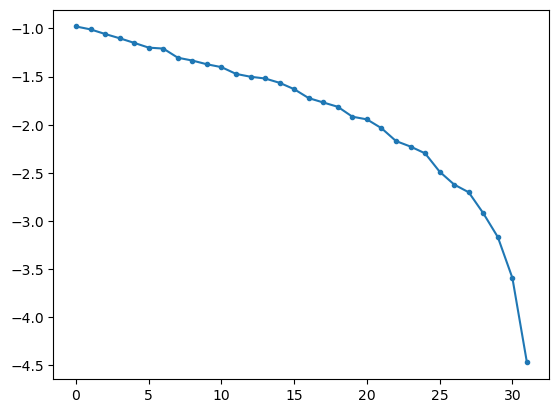

In [166]:
plt.plot(np.log10(zz),'.-')

In [78]:
ct_q.vec_history[-1]

array([0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j])

In [14]:
ct_q.half_system_entanglement_entropy()

2.569684963781355e-33

In [8]:
ct=CT_tensor(L=4,seed=[0,1],seed_vec=[2,3],seed_C=[4,5],x0=None,ancilla=True,store_vec=False,store_op=True,store_prob=True,complex128=True,gpu=False,ensemble=None,debug=True)
# ct=CT_tensor(L=4,seed=0,seed_vec=1,seed_C=3,x0=None,ancilla=True,store_vec=False,store_op=True,store_prob=True,complex128=True,gpu=False,ensemble=10,ensemble_m=4,debug=True)
# ct_r=CT_tensor(L=4,seed=0,seed_vec=1,seed_C=3,x0=None,ancilla=True,store_vec=False,store_op=True,store_prob=True,complex128=True,gpu=False,ensemble=10,ensemble_m=4,debug=True)

TypeError: CT_tensor.__init__() got an unexpected keyword argument 'x0'

In [ ]:
# zz=ct.S_tensor(vec=ct.vec_history[-1],rng=ct.rng_C,size=ct.ensemble)
# ct.P_tensor_(vec=ct.vec_history[-1],n=1)
# zz=ct.control_map(vec=ct.vec, n=0)
# zz=ct.projection_map(vec=ct.vec, pos=ct.L-1, n=0)
for _ in range(10):
    ct.random_control(p_ctrl=0.5, p_proj=.5)

In [306]:
ct.prob_history

[tensor([[0.6144],
         [0.2264]], dtype=torch.float64),
 tensor([[1.],
         [1.]], dtype=torch.float64),
 tensor([[0.4750],
         [0.3867]], dtype=torch.float64),
 tensor([[0.2169],
         [0.2129]], dtype=torch.float64),
 tensor([[1.0000],
         [0.7867]], dtype=torch.float64),
 tensor([[1.],
         [1.]], dtype=torch.float64),
 tensor([[0.2876],
         [0.1212]], dtype=torch.float64),
 tensor([[1.0000],
         [0.5198]], dtype=torch.float64),
 tensor([[0.2815],
         [1.0000]], dtype=torch.float64),
 tensor([[0.9106],
         [1.0000]], dtype=torch.float64)]

In [308]:
torch.stack(ct.prob_history).prod(dim=0)[1].item()

0.0009238603676732921

In [277]:
ct.op_history[0]

({True: tensor([], dtype=torch.int64),
  False: tensor([[0, 0],
          [1, 0]])},
 {},
 {3: {True: tensor([[1, 0]]), False: tensor([[0, 0]])},
  2: {True: tensor([[0, 0],
           [1, 0]]),
   False: tensor([], dtype=torch.int64)}},
 {3: {True: tensor([[1, 0]]), False: tensor([], dtype=torch.int64)},
  2: {True: tensor([], dtype=torch.int64),
   False: tensor([[0, 0],
           [1, 0]])}})

In [233]:
ct.vec[...,0,0].flatten()

tensor([ 0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,
        -0.1239+0.9014j,  0.0000+0.0000j,  0.2750+0.2340j,  0.0000+0.0000j,
         0.0000+0.0000j,  0.0000+0.0000j,  0.1722-0.1102j,  0.0000+0.0000j,
         0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j],
       dtype=torch.complex128)

In [139]:
ct_r.reference_control(op_history=ct.op_history,)

In [48]:
torch.equal(ct.vec[...,0,0],ct_r.vec[...,0,0])

True

In [ ]:
np.sum([ct.op_history[i][2][ct.L-2][True].shape[0] for i in range(200)])

In [72]:
zz=torch.rand(6,4)

In [73]:
zz[ct.op_history[0][1][True][:,0],ct.op_history[0][1][True][:,1]]

tensor([0.3530, 0.8777, 0.5152, 0.9547, 0.7874, 0.1415, 0.3368, 0.3143, 0.6516,
        0.8548, 0.2560, 0.2486, 0.8772, 0.2159])

In [76]:
zz[tuple(ct.op_history[0][1][True].T)]

tensor([0.3530, 0.8777, 0.5152, 0.9547, 0.7874, 0.1415, 0.3368, 0.3143, 0.6516,
        0.8548, 0.2560, 0.2486, 0.8772, 0.2159])

In [77]:
ct.op_history[0][0]

{True: tensor([[0],
         [1],
         [2],
         [3],
         [4],
         [5]]),
 False: tensor([[6],
         [7],
         [8],
         [9]])}

In [101]:
ct.op_history[0][2]

{3: {True: tensor([[6]]),
  False: tensor([[7],
          [8],
          [9]])},
 2: {True: tensor([[7],
          [8],
          [9]]),
  False: tensor([[6]])}}

In [61]:
ct.op_history[0][0]

{True: tensor([[0],
         [1],
         [2],
         [3],
         [4],
         [5]]),
 False: tensor([[6],
         [7],
         [8],
         [9]])}

In [ ]:
ct.op_history[0]

({True: tensor([[0],
          [1],
          [2],
          [3],
          [4]]),
  False: tensor([], size=(0, 1), dtype=torch.int64)},
 {True: tensor([[0, 0],
          [0, 2],
          [0, 3],
          [1, 0],
          [1, 1],
          [1, 2],
          [2, 0],
          [2, 1],
          [2, 2],
          [2, 3],
          [3, 0],
          [3, 1],
          [3, 2],
          [3, 3],
          [4, 2],
          [4, 3]]),
  False: tensor([[0, 1],
          [1, 3],
          [4, 0],
          [4, 1]])},
 {},
 {})

In [14]:
ct_r.op_history

[({True: tensor([[0],
           [1],
           [2],
           [3],
           [4]]),
   False: tensor([], size=(0, 1), dtype=torch.int64)},
  {True: tensor([[0, 0],
           [0, 2],
           [0, 3],
           [1, 0],
           [1, 1],
           [1, 2],
           [2, 0],
           [2, 1],
           [2, 2],
           [2, 3],
           [3, 0],
           [3, 1],
           [3, 2],
           [3, 3],
           [4, 2],
           [4, 3]]),
   False: tensor([[0, 1],
           [1, 3],
           [4, 0],
           [4, 1]])},
  {},
  {})]

In [15]:
ct.vec[...,0,0].flatten()

tensor([ 0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,
         0.0000+0.0000j,  0.0000+0.0000j, -0.0415-0.0027j, -0.0618-0.2716j,
        -0.0672+0.3659j, -0.2235-0.0201j,  0.2075-0.3246j,  0.1817-0.0403j,
         0.1165+0.3384j,  0.0730-0.2230j,  0.0000+0.0000j,  0.0000+0.0000j,
         0.0000+0.0000j,  0.0000+0.0000j, -0.0338+0.2037j,  0.3849-0.2738j,
        -0.1939-0.0386j,  0.1394-0.1285j,  0.0073-0.0198j, -0.0452-0.0638j,
        -0.0840-0.0254j,  0.0782+0.0684j,  0.0000+0.0000j,  0.0000+0.0000j,
         0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j],
       dtype=torch.complex128)

In [16]:
ct_r.vec[...,0,0].flatten()

tensor([ 0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,
         0.0000+0.0000j,  0.0000+0.0000j, -0.0415-0.0027j, -0.0618-0.2716j,
        -0.0672+0.3659j, -0.2235-0.0201j,  0.2075-0.3246j,  0.1817-0.0403j,
         0.1165+0.3384j,  0.0730-0.2230j,  0.0000+0.0000j,  0.0000+0.0000j,
         0.0000+0.0000j,  0.0000+0.0000j, -0.0338+0.2037j,  0.3849-0.2738j,
        -0.1939-0.0386j,  0.1394-0.1285j,  0.0073-0.0198j, -0.0452-0.0638j,
        -0.0840-0.0254j,  0.0782+0.0684j,  0.0000+0.0000j,  0.0000+0.0000j,
         0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j],
       dtype=torch.complex128)

In [17]:
torch.equal(ct.vec[...,0,0],ct_r.vec[...,0,0])

True

In [107]:
ct.op_history[0][3]

{}

In [29]:
ct.von_Neumann_entropy_pure([ct.L])

tensor([[0.6931],
        [0.6931],
        [0.6931]], dtype=torch.float64)

In [31]:
ct.half_system_entanglement_entropy()

tensor([[2.9633],
        [2.9706],
        [2.9796]], dtype=torch.float64)

In [ ]:
ct.random_control(p_ctrl=0.5, p_proj=0.5)

In [10]:
ct.vec[...,0,0].flatten()

tensor([ 0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,
         0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,
         0.1694-0.1035j, -0.0110+0.2062j,  0.0000+0.0000j,  0.0000+0.0000j,
         0.3950+0.5337j, -0.6903+0.0242j,  0.0000+0.0000j,  0.0000+0.0000j,
         0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,
         0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,
         0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,
         0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j],
       dtype=torch.complex128)

In [ ]:
ct.vec[...,0,0].flatten()

tensor([ 0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,
         0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,
         0.1694-0.1035j, -0.0110+0.2062j,  0.0000+0.0000j,  0.0000+0.0000j,
         0.3950+0.5337j, -0.6903+0.0242j,  0.0000+0.0000j,  0.0000+0.0000j,
         0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,
         0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,
         0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,
         0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j],
       dtype=torch.complex128)

In [198]:
torch.abs(zz[...,1,0].cpu().flatten()-ct_q.vec_history[-1].flatten()).max()

tensor(8.4415e-17, dtype=torch.float64)

In [120]:
zz[...,1,0].flatten()

NameError: name 'zz' is not defined

In [712]:
zz=ct.encoding()

In [192]:
ct.von_Neumann_entropy_pure([ct.L])/torch.log(torch.tensor([2],device='cuda'))

tensor([1., 1., 1.], device='cuda:0')

In [181]:
ct.vec_history[-1][...,0].dtype

torch.complex64

In [98]:
ct.vec_history[-1].is_cuda

True

In [67]:
def run2(seed):
    ct_q=CT_quantum(L=12,seed=seed,seed_vec=0,seed_C=2,x0=None,ancilla=False,store_vec=False,store_op=True,store_prob=True,normalization=True)
    for _ in range(10):
        ct_q.encoding()
    return ct_q

In [70]:
ct_q2=run2(seed=1)

In [72]:
ct_q2.half_system_entanglement_entropy()

3.6477298361840886

In [ ]:
%lprun -f CT_quantum.T_tensor ct_q=run(seed=1)

In [104]:
%lprun -f CT_quantum.S_tensor ct_q=run(seed=1)

Timer unit: 1e-09 s

Total time: 0.00125835 s
File: /tmp/ipykernel_2079821/324975775.py
Function: S_tensor at line 560

Line #      Hits         Time  Per Hit   % Time  Line Contents
   560                                               def S_tensor(self,vec,rng):
   561                                                   '''directly convert to tensor and apply to the last two indices'''
   562        10     750271.0  75027.1     59.6          U_4=U(4,rng)
   563        10       2807.0    280.7      0.2          if not self.ancilla:
   564        10     119140.0  11914.0      9.5              vec=vec.reshape((2**(self.L-2),2**2)).T
   565        10     386136.0  38613.6     30.7              return (U_4@vec).T
   566                                                   else:
   567                                                       vec=vec.reshape((2**(self.L-2),2**2,2)).transpose((1,0,2)).reshape((2**2,2**(self.L-1)))
   568                                                       return (U

In [105]:
ct_q.half_system_entanglement_entropy()

3.6498934911676093

In [5]:
ct_q.half_system_entanglement_entropy()

3.6498934911676093

In [17]:
ct_q.op_history

['C1',
 'chaotic',
 'C1',
 'chaotic_P30_P21',
 'C1',
 'chaotic_P31',
 'chaotic_P21',
 'chaotic',
 'chaotic',
 'C1']

In [15]:
ct_q.vec_history[-1]

array([ 0.01508081-0.00245061j, -0.01445984+0.00554831j,
       -0.02698403-0.00343834j,  0.00858612-0.00330114j,
       -0.00160692+0.00179818j,  0.00638048+0.0013796j ,
        0.01962915+0.00662288j, -0.00482073-0.00789898j,
        0.02123161-0.02061891j,  0.00347919+0.01058837j,
        0.00892751-0.02246267j, -0.02988244-0.01244492j,
        0.        +0.j        ,  0.        +0.j        ,
        0.        +0.j        ,  0.        +0.j        ])

In [410]:
ct_q.von_Neumann_entropy_pure([ct_q.L])/np.log(2)

1.0000000000000002

In [274]:
haar_U=U(2**6)

In [275]:
haar_U[:,0].conj().T@haar_U[:,-1]

(-1.3877787807814457e-17-3.2959746043559335e-17j)

In [178]:
ct_q.order_parameter()

-0.06042439762302422

In [179]:
ct.half_system_entanglement_entropy()

tensor([0.8868])

In [122]:
ct_q.vec_history[-1]

array([ 0.        +0.j        ,  0.        +0.j        ,
        0.        +0.j        ,  0.49204362-0.4663262j ,
        0.17407208-0.25127124j,  0.26619817-0.09731108j,
       -0.02888886-0.30832863j,  0.        +0.j        ,
        0.        +0.j        , -0.00672618+0.01697749j,
       -0.36795636+0.28178448j,  0.23336779-0.0334246j ,
        0.0067986 -0.00328639j,  0.        +0.j        ,
        0.        +0.j        ,  0.        +0.j        ])

In [32]:
ct_q.half_system_entanglement_entropy()

0.8868175830531069

In [39]:
ct_q.vec_history[-1]

array([-0.02189571-0.00950564j,  0.16636573-0.07545342j,
       -0.08110606-0.24086351j,  0.22760555-0.30256946j,
       -0.05195836-0.0325729j ,  0.08521488-0.04941045j,
        0.22208019-0.06658098j,  0.27454483+0.23896516j,
        0.08807009+0.26613718j, -0.25587263+0.00154074j,
        0.00724904-0.06738779j,  0.21145557+0.07358847j,
        0.08723817+0.05396683j,  0.0662047 +0.13370657j,
       -0.05140242+0.24138354j, -0.25331547+0.11297635j,
        0.05248793-0.01275735j, -0.04253466+0.13687058j,
        0.06590441+0.04385892j,  0.01567158+0.03730747j,
        0.06087825+0.03534783j,  0.00260159+0.08058638j,
        0.04899901-0.06454962j,  0.12482792-0.01432296j,
       -0.03133922-0.07899648j,  0.23392337+0.14754355j,
        0.0720602 -0.05077399j, -0.10745183+0.02702867j,
        0.05589089-0.06285468j,  0.01345107+0.00256699j,
       -0.07365314-0.03019141j, -0.07785825+0.02043671j])

In [40]:
np.abs(ct_q.vec_history[-1]-ct.vec.cpu()[...,9].flatten().numpy()).max()


0.0

In [19]:
torch.bernoulli(torch.tensor([0.1,0.2]))

tensor([0., 0.])

In [102]:
ct_q.half_system_entanglement_entropy()

2.886579864025403e-15

In [103]:
ct_q.tripartite_mutual_information(np.arange(ct_q.L//4),np.arange(ct_q.L//4)+ct_q.L//4,np.arange(ct_q.L//4)+(ct_q.L//4)*2,selfaverage=False)

3.941291737419306e-15

In [19]:
ct_q.von_Neumann_entropy_pure(np.concatenate([np.arange(ct_q.L//4)+ct_q.L//4,np.arange(ct_q.L//4)+(ct_q.L//4)*2]))

0.351120319974112

In [22]:
x=1
ct_q.von_Neumann_entropy_pure(np.concatenate([np.arange(ct_q.L//4)+x,np.arange(ct_q.L//4)+(x)+ct_q.L//4]))

0.2427919668773737

In [156]:
ct_q.half_system_entanglement_entropy()

1.110223024625156e-15

In [158]:
ct_q.tripartite_mutual_information(np.arange(ct_q.L//4),np.arange(ct_q.L//4)+ct_q.L//4,np.arange(ct_q.L//4)+(ct_q.L//4)*2,selfaverage=False)

-2.3071822230491534e-16

### tensor pytorch

In [91]:
torch.cuda.memory_allocated()/1024/1024/1024

6.0079345703125

In [121]:
ct.adder_tensor_(ct.vec,new_idx,old_idx)

In [16]:
ct.von_Neumann_entropy_pure(np.concatenate([np.arange(ct.L//4)+ct.L//4,np.arange(ct.L//4)+(ct.L//4)*2]))

0.35112031997411175

In [54]:
%timeit ct.von_Neumann_entropy_pure(([ct.L-1]),driver='gesvda')

211 ms ± 544 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [55]:
%timeit ct.von_Neumann_entropy_pure(([ct.L-1]),)

45 ms ± 42.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [21]:
x=1
ct.von_Neumann_entropy_pure(np.concatenate([np.arange(ct.L//4)+x,np.arange(ct.L//4)+(x)+ct.L//4]))

0.2427919668794766

In [ ]:
%lprun -f  CT_tensor.von_Neumann_entropy_pure ct.von_Neumann_entropy_pure(np.concatenate([np.arange(ct.L//4)+x,np.arange(ct.L//4)+(x)+ct.L//4]),driver='gesvda')

In [ ]:
%lprun -f CT_tensor.von_Neumann_entropy_pure ct.von_Neumann_entropy_pure(np.concatenate([np.arange(ct.L//4)+ct.L//4,np.arange(ct.L//4)+(ct.L//4)*2]))

In [ ]:
%lprun -f CT_tensor.tripartite_mutual_information ct.tripartite_mutual_information(np.arange(ct.L//4),np.arange(ct.L//4)+ct.L//4,np.arange(ct.L//4)+(ct.L//4)*2,selfaverage=False)

In [ ]:
%lprun -f CT_tensor.adder_tensor_ ct.adder_tensor_(ct.vec,new_idx,old_idx)

In [52]:
zz=torch.rand((2,3,4))

In [192]:
nnz=[torch.count_nonzero(vec) for vec in ct.vec_history]

In [ ]:
plt.plot(np.array(nnz)/2**ct.L)

In [5]:
import torch

In [6]:
torch.cuda.memory_allocated()/1024/1024/1024

1.0

In [48]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [47]:
torch.cuda.empty_cache()

In [56]:
1/0

ZeroDivisionError: division by zero

In [14]:
del z_gpu

In [15]:
del U4_gpu

In [7]:
L=28

In [8]:
z=torch.rand((2,)*L,dtype=torch.complex128)

In [9]:
U4=torch.from_numpy(U(4,rng=np.random.default_rng(0)).astype(np.complex128).reshape((2,)*4))

In [ ]:
zp=torch.tensordot(z,U4,dims=([L-2,L-1],[2,3]))

In [10]:
z_gpu=z.cuda()
U4_gpu=U4.cuda()

In [12]:
z_gpu=torch.tensordot(z_gpu,U4_gpu,dims=([L-2,L-1],[2,3]))

In [21]:
del zm

In [438]:
%timeit zp=z.permute(list(range(1,L))+[0])

6.39 µs ± 479 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [439]:
%timeit zp_gpu=z_gpu.permute(list(range(1,L))+[0])

8.67 µs ± 195 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [409]:
old_idx=np.array([list(map(int,bin_pad(x,L))) for x in range(2**L)])

In [410]:
new_idx=np.hstack((old_idx[:,1:],old_idx[:,:1]))

In [411]:
idx=np.hstack((old_idx,new_idx,)).T.tolist()
vals=([0]*2**(L))
OO=torch.sparse_coo_tensor(idx,vals,size=(2,)*(2*L),dtype=torch.float).to_dense()

In [412]:
OO_gpu=OO.cuda()

In [414]:
%timeit zm=torch.tensordot(OO,z,dims=(list(range(L,2*L)),list(range(L))))

20.6 ms ± 1.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [415]:
%timeit zm_gpu=torch.tensordot(OO_gpu,z_gpu,dims=(list(range(L,2*L)),list(range(L))))

829 µs ± 10.1 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [ ]:
zm_gpu-zm

In [246]:
index_tensor.shape

torch.Size([2, 3])

In [247]:
values_tensor.shape

torch.Size([3])

In [164]:
ct.order_parameter()

0.3606434050376535

In [161]:
ct.half_system_entanglement_entropy()

8.881784197001248e-16

In [162]:
ct.tripartite_mutual_information(np.arange(ct.L//4),np.arange(ct.L//4)+ct.L//4,np.arange(ct.L//4)+(ct.L//4)*2,selfaverage=False)

8.951173136040325e-16

In [93]:
ct.op_history==ct_q.op_history

True

In [116]:
np.abs((ct.vec_history)[1].flatten()-ct_q.vec_history[1]).sum()

tensor(0., dtype=torch.float64)

In [112]:
len(ct.vec_history)

9

In [117]:
[np.abs((ct.vec_history)[x].flatten()-ct_q.vec_history[x]).sum() for x in range(len(ct.vec_history))]

[tensor(0., dtype=torch.float64),
 tensor(0., dtype=torch.float64),
 tensor(0., dtype=torch.float64),
 tensor(0., dtype=torch.float64),
 tensor(1.1444e-16, dtype=torch.float64),
 tensor(0., dtype=torch.float64),
 tensor(0., dtype=torch.float64),
 tensor(0., dtype=torch.float64),
 tensor(0., dtype=torch.float64)]

In [182]:
ct.control_map(ct.vec,bL=0)

tensor([[1.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j]], dtype=torch.complex128)

In [149]:
ct.projection_map(ct.vec,ct.L-1,0)

tensor([[[0.2307+0.5584j, 0.0670-0.6474j],
         [0.0000+0.0000j, 0.0000+0.0000j]],

        [[0.1945-0.1009j, 0.3918+0.0991j],
         [0.0000+0.0000j, 0.0000+0.0000j]]], dtype=torch.complex128)

In [ ]:
ct.XL_tensor(ct.vec, ).flatten()-ct_q.XL_tensor(ct_q.vec, )

tensor([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       dtype=torch.complex128)

In [ ]:
(ct.Bernoulli_map(ct.Bernoulli_map(ct.vec)))

In [ ]:
ct.vec.flatten()

In [ ]:
ct.P_tensor(ct.vec, n=0,)[...,1]

In [ ]:
vv=ct.S_tensor(ct.vec, ct.rng)

In [ ]:
vv

In [ ]:
vv=ct.T_tensor(ct.vec,left=True)

In [ ]:
torch.where(ct.vec)

(tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]))

In [ ]:
torch.where(vv)

(tensor([0, 0, 0, 0]),
 tensor([0, 0, 0, 0]),
 tensor([0, 0, 0, 0]),
 tensor([0, 0, 0, 0]),
 tensor([0, 0, 1, 1]),
 tensor([0, 1, 0, 1]))

In [ ]:
vv[0,0,0,0]

tensor([[ 0.0458-0.1982j, -0.0670-0.1189j],
        [ 0.2165+0.2635j, -0.1708+0.8914j]])

In [ ]:
ct.vec.shape


torch.Size([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [ ]:
zz=torch.zeros((2,)*4,)
zz_np=np.zeros((2,)*4)
# zz=torch.zeros((2,3,4))

In [ ]:
zz[...,0,:].shape

torch.Size([2, 2, 2])

In [ ]:
zz_np[...,0]

array([[[0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.]]])

In [ ]:
zz.permute([1,2,0]).shape

torch.Size([3, 4, 2])

In [ ]:
idx=dec2bin(0.5,10)

In [ ]:
zz[tuple(idx)]

tensor(0., dtype=torch.float64)

In [ ]:
z=numpy_test(x,y)

In [ ]:
%timeit z=numpy_test(x,y)

15.3 ms ± 44.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
# x_torch=torch.from_numpy(x)
# y_torch=torch.from_numpy(y)

x_torch=torch.rand(*(2,)*32)
y_torch=torch.rand(*(2,)*32)

def torch_test(x,y):
    return x+y

In [ ]:
z=torch_test(x_torch,y_torch)

In [ ]:
%timeit z=torch_test(x_torch,y_torch)

8.87 ms ± 77.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
from torch.utils.data import TensorDataset, DataLoader


In [ ]:
dataset = TensorDataset(x_torch, y_torch)

In [ ]:
batch_size = 1000  # adjust based on your needs
dataloader = DataLoader(dataset, batch_size=batch_size)


In [ ]:
dataloader

In [ ]:
x_chunks = torch.chunk(x_torch,chunks=2, dim=0)
y_chunks = torch.chunk(y_torch,chunks=2, dim=0)

In [ ]:
results = []
x_chunks = torch.chunk(x_torch,chunks=2, dim=0)
y_chunks = torch.chunk(y_torch,chunks=2, dim=0)
for x_batch, y_batch in zip(x_chunks,y_chunks):
    x_minibatches=x_batch.chunk(chunks=2,dim=1)
    y_minibatches=y_batch.chunk(chunks=2,dim=1)
    for x_minibatch, y_minibatch in zip(x_minibatches,y_minibatches):
        x_batch_gpu = x_minibatch.cuda()
        y_batch_gpu = y_minibatch.cuda()
        results.append(torch_gpu_test(x_minibatch, y_minibatch).cpu())
    


final_result = torch.cat(results, dim=0)


In [ ]:
x_torch_gpu=x_torch.cuda()
y_torch_gpu=y_torch.cuda()

def torch_gpu_test(x,y):
    return x+y

In [ ]:
z=torch_gpu_test(x_torch_gpu,y_torch_gpu)

In [ ]:
%timeit z=torch_gpu_test(x_torch_gpu,y_torch_gpu)

1.03 ms ± 49.2 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [ ]:
import torch

In [ ]:
np.zeros((2,)*32)

In [ ]:
torch.zeros((2,)*36, layout=torch.sparse_coo)

tensor(indices=tensor([], size=(36, 0)),
       values=tensor([], size=(0,)),
       size=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2),
       nnz=0, layout=torch.sparse_coo)

### CT_tensor multi-ensemble

In [59]:
L=12
16/2**(L-30)

4194304.0

In [41]:
ct=CT_tensor(L=4,gpu=False,seed=[1],ancilla=False,complex128=False,store_vec=False,store_op=True,store_prob=False,ensemble=None,xj=set([1]))
# ct=CT_tensor(L=4,gpu=False,seed=1,ancilla=False,complex128=False,store_vec=False,store_op=True,store_prob=False,ensemble=2,ensemble_m=3)


Using cpu


In [42]:
for _ in range(1):
    ct.random_control(p_ctrl=1, p_proj=0.)

tensor([ 0.0930-0.3668j,  0.0000+0.0000j, -0.1511+0.1636j,  0.0000+0.0000j,
         0.0080+0.1539j,  0.0000+0.0000j, -0.1357+0.1686j,  0.0000+0.0000j,
        -0.2201-0.0724j,  0.0000+0.0000j,  0.3643+0.2834j,  0.0000+0.0000j,
        -0.0492-0.1188j,  0.0000+0.0000j,  0.5962-0.3130j,  0.0000+0.0000j])
tensor([ 0.0930-0.3668j, -0.1511+0.1636j,  0.0080+0.1539j, -0.1357+0.1686j,
        -0.2201-0.0724j,  0.3643+0.2834j, -0.0492-0.1188j,  0.5962-0.3130j,
         0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,
         0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j])
tensor([ 0.5962-0.3130j,  0.0080+0.1539j, -0.1357+0.1686j,  0.0000+0.0000j,
         0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,
         0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,
         0.0000+0.0000j, -0.2201-0.0724j,  0.3643+0.2834j, -0.0492-0.1188j])


In [37]:
ct.vec[...,0,0].flatten()

tensor([ 0.5962-0.3130j,  0.0080+0.1539j, -0.1357+0.1686j,  0.0000+0.0000j,
         0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,
         0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,
         0.0000+0.0000j, -0.2201-0.0724j,  0.3643+0.2834j, -0.0492-0.1188j])

In [ ]:
ct.vec[...,0,0].flatten()

tensor([ 0.0673+0.1599j,  0.0643-0.2536j,  0.1762+0.0869j, -0.1045+0.1131j,
         0.0710+0.0572j,  0.0055+0.1064j, -0.1433-0.0317j, -0.0938+0.1166j,
         0.0077-0.0569j, -0.1522-0.0501j,  0.0016-0.0536j,  0.2519+0.1959j,
        -0.5277-0.3677j, -0.0340-0.0822j,  0.0416+0.0423j,  0.4122-0.2164j])

In [23]:
ct.old_idx

tensor([[0, 1, 2, 3],
        [4, 5, 6, 7]])

In [24]:
ct.new_idx

tensor([[15,  0,  1,  2],
        [13, 14, 15,  0]])

In [25]:
ct.not_new_idx

tensor([False, False, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False, False, False])

In [ ]:
ct.order_parameter()

tensor([[-0.0599]])

In [ ]:
ct.half_system_entanglement_entropy()

tensor([[0.4977]])

In [ ]:
%lprun -f CT_tensor.S_tensor ct.encoding()

In [38]:
torch.sum(torch.abs(ct.vec[...,0])**2)

tensor(1.0000, dtype=torch.float64)

In [ ]:
ct.half_system_entanglement_entropy()

In [ ]:
ct.von_Neumann_entropy_pure([ct.L])/np.log(2)

In [ ]:
ct.vec[...,2].flatten()

In [165]:
ct.order_parameter()

tensor([0.0194])

In [37]:
ct.half_system_entanglement_entropy()

tensor([0.6795])

In [123]:
ct.vec.flatten()

tensor([ 0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  0.4920-0.4663j,
         0.1741-0.2513j,  0.2662-0.0973j, -0.0289-0.3083j,  0.0000+0.0000j,
         0.0000+0.0000j, -0.0067+0.0170j, -0.3680+0.2818j,  0.2334-0.0334j,
         0.0068-0.0033j,  0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j])

In [15]:
torch.ones(2**(2),dtype=bool)

tensor([True, True, True, True])

In [42]:
def float2int_1_6(L):
    bin_=dec2bin(Fraction(1,6), L)
    bin_[-1]=1
    return int(''.join(map(str,bin_)),2)


In [57]:
torch.arange(2**(4-1)).reshape((2,-1))

tensor([[0, 1, 2, 3],
        [4, 5, 6, 7]])

In [54]:
int(Fraction(1,6)*2**9)|1

85

In [ ]:
[float2int_1_6(L=L)-(int(Fraction(1,6)*2**L)|1) for L in range(1,30)]

In [49]:
def float2int_1_3(L):
    bin_=dec2bin(Fraction(1,3), L)
    return int(''.join(map(str,bin_)),2)


In [ ]:
[float2int_1_3(L=L)-int(Fraction(1,3)*2**L) for L in range(1,30)]

In [ ]:
torch.vstack((np.arange(2**(6-2)),np.arange(2**(6-2),2**(6-1))))

In [237]:
def run_tensor():
    # ct=CT_tensor(L=18,gpu=True,seed=list(range(200)),x0=None,ancilla=False,history=False,complex128=True)
    ct=CT_tensor(L=18,gpu=True,seed=0,x0=None,ancilla=False,history=False,complex128=True,ensemble=200)
    for _ in range(50):
        ct.random_control(0.0,0)
    return ct
# [Fraction(15,2**4),Fraction(15,2**4),Fraction(15,2**4)]

In [236]:
ct=run_tensor()

Using cuda


In [ ]:
ct.tripartite_mutual_information(np.arange(ct.L//4),np.arange(ct.L//4)+ct.L//4,np.arange(ct.L//4)+ct.L//4*2)

In [ ]:
ct.half_system_entanglement_entropy()

In [ ]:
ee0.cpu()-ee1

In [ ]:
%lprun -f CT_tensor.von_Neumann_entropy_pure ct.half_system_entanglement_entropy()

In [ ]:
ct.order_parameter()

In [256]:
%lprun -f CT_tensor.U run_tensor()

Using cuda


Timer unit: 1e-09 s

Total time: 0.425079 s
File: /tmp/ipykernel_1012274/3764402697.py
Function: U at line 450

Line #      Hits         Time  Per Hit   % Time  Line Contents
   450                                               def U(self,n,size,):
   451        50     170698.0   3414.0      0.0          dtype=torch.float64 if torch.float64 else torch.float32
   452        50    2304676.0  46093.5      0.5          im = torch.randn((size,n, n), device=self.device,dtype=dtype)
   453        50     616414.0  12328.3      0.1          re = torch.randn((size,n, n), device=self.device,dtype=dtype)
   454        50    1716519.0  34330.4      0.4          z=torch.complex(re,im)
   455        50  392015417.0 7840308.3     92.2          Q,R=torch.linalg.qr(z)
   456        50    2586147.0  51722.9      0.6          r_diag=torch.diagonal(R,dim1=-2,dim2=-1)
   457        50   11548879.0 230977.6      2.7          Lambda=torch.diag_embed(r_diag/torch.abs(r_diag))
   458        50   14104379.0 2820

In [75]:
p_rand=torch.bernoulli(torch.tensor([0.5]*1000))
p_rand_gpu=p_rand.cuda()
p_rand_np=p_rand.numpy()

In [76]:
%timeit idx=torch.nonzero(p_rand,as_tuple=True)[0]

9.18 µs ± 1.45 µs per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [77]:
%timeit idx=torch.nonzero(p_rand_gpu,as_tuple=True)[0]

35.3 µs ± 222 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [78]:
%timeit idx=np.nonzero(p_rand_np)

9.37 µs ± 77.5 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [ ]:
{}

In [56]:
x = torch.randn (3, 288)

In [57]:
torch.max (x, torch.tensor ([0.0])).sum (dim = 1)

tensor([105.5327, 144.2502, 107.6863])

In [41]:
z=ct.generate_binary([0,1,2], 0.5)

In [21]:
torch.randint(0,10,(14,))

tensor([1, 1, 2, 8, 9, 9, 2, 1, 7, 5, 0, 1, 0, 1])

In [21]:
p=0.5
pp=torch.bernoulli(torch.tensor([.99,]*10))

In [22]:
pp

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [19]:
torch.nonzero(pp)

tensor([[0],
        [1],
        [2],
        [4],
        [6],
        [8],
        [9]])

In [20]:
torch.nonzero(pp,as_tuple=True)[0]

tensor([0, 1, 2, 4, 6, 8, 9])

In [70]:
def functest(vec):
    vec=torch.roll(vec,1)
    return vec

In [71]:
vec=torch.tensor([0,1,3])

In [72]:
functest(vec)

tensor([3, 0, 1])

In [73]:
lst = torch.tensor([0,1,2,3])

tensor([0, 1, 3])

In [13]:
ct=run_tensor()

Using cuda


In [19]:
ct.order_parameter()

array([-0.10877474])

In [50]:
ct.half_system_entanglement_entropy()

array([ 2.22044605e-16, -0.00000000e+00,  6.67033186e-32, -4.44089210e-16,
        2.22044605e-16,  2.22044605e-16, -4.44089210e-16, -4.44089210e-16,
        1.27574661e-31,  2.22044605e-16])

In [ ]:
ct.vec[...,2]

In [27]:
ct.tripartite_mutual_information(np.arange(ct.L//4),np.arange(ct.L//4)+ct.L//4,np.arange(ct.L//4)+ct.L//4*2)

array([0.69314718, 0.69314718, 0.69314718, 0.69314718, 0.69314718,
       0.69314718, 0.69314718, 0.69314718, 0.69314718, 0.69314718])

In [13]:
run_tensor()

Using cuda


In [15]:
np.array([]).shape[0]

0

In [17]:
torch.tensor([[]]).shape[0]

1

In [54]:
oo=ct.order_parameter()

In [19]:
torch.tensor([np.random.default_rng(s) for s in [0,1,3]])

RuntimeError: Could not infer dtype of numpy.random._generator.Generator

In [26]:
torch.mean([1,2])

TypeError: mean(): argument 'input' (position 1) must be Tensor, not list

In [56]:
ee=ct.half_system_entanglement_entropy()

In [57]:
ee[-1]

-0.0

In [111]:
ct.vec[...,0]

tensor([[[[[ 0.1843+0.1023j,  0.0000+0.0000j],
           [ 0.0631+0.2186j,  0.0000+0.0000j]],

          [[-0.2815+0.2908j,  0.0000+0.0000j],
           [ 0.0898+0.0933j,  0.0000+0.0000j]]],


         [[[ 0.1297+0.0320j,  0.0000+0.0000j],
           [ 0.2032-0.0774j,  0.0000+0.0000j]],

          [[-0.1283+0.0709j,  0.0000+0.0000j],
           [-0.3696+0.0044j,  0.0000+0.0000j]]]],



        [[[[ 0.0000+0.0000j, -0.0452-0.2819j],
           [ 0.0000+0.0000j, -0.2282+0.3306j]],

          [[ 0.0000+0.0000j,  0.0793+0.0824j],
           [ 0.0000+0.0000j, -0.2468-0.0020j]]],


         [[[ 0.0000+0.0000j,  0.1737-0.0340j],
           [ 0.0000+0.0000j, -0.3222+0.0128j]],

          [[ 0.0000+0.0000j,  0.0614+0.1031j],
           [ 0.0000+0.0000j, -0.1249-0.1335j]]]]], dtype=torch.complex128)

In [172]:
A=np.random.rand(2000,2000)
A_gpu=torch.from_numpy(A)

In [174]:
%timeit scipy.linalg.svdvals(A)

1.48 s ± 239 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [173]:
%timeit torch.linalg.svdvals(A_gpu)

1.61 s ± 387 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
zz[(0,0)]

tensor([0.7576, 0.2793, 0.4031, 0.7347])

In [ ]:
ct.vec.shape

torch.Size([3, 2, 2, 2, 2])

In [ ]:
ct.vec[0][]

tensor([[[[1., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.]]],


        [[[0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.]]]])

In [ ]:
np.where(ct.vec[2])

(array([0]), array([0]), array([1]), array([0]))

In [ ]:
ct.vec[...,0]

tensor([[[[0., 1.],
          [0., 0.]],

         [[0., 0.],
          [0., 1.]]],


        [[[0., 0.],
          [0., 0.]],

         [[1., 0.],
          [0., 0.]]]], device='cuda:0')

In [ ]:
ct.vec

(tensor([0, 1, 0]), tensor([1, 1, 0]), tensor([1, 0, 0]), tensor([1, 0, 1]))

In [ ]:
torch.manual_seed(0)

In [ ]:
torch.rand(size=(2,3))

tensor([[0.4963, 0.7682, 0.0885],
        [0.1320, 0.3074, 0.6341]])

In [ ]:
torch.cuda.manual_seed(0)


In [ ]:
torch.rand(size=(2,3),device=device)

tensor([[0.3990, 0.5167, 0.0249],
        [0.9401, 0.9459, 0.7967]], device='cuda:0')

In [ ]:
x=torch.rand(size=(2,3))

In [ ]:
x[[0,1],[0,1]]=1

In [ ]:
x

tensor([[1.0000, 0.9564, 0.4371],
        [0.2294, 1.0000, 0.4516]])

In [ ]:
(1,)+(2,)

(1, 2)

In [ ]:
x = torch.Tensor(2, 3) 

In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = torch.device("cuda")

In [ ]:
device

device(type='cuda')

In [ ]:
x_dev=x.to(device)

In [ ]:
x_dev

tensor([[1.6801e-07, 1.3542e-05, 1.3385e+22],
        [4.3119e-08, 2.3077e-12, 2.6302e+20]], device='cuda:0')

In [ ]:
x_dev+x_dev

tensor([[3.3602e-07, 2.7084e-05, 2.6769e+22],
        [8.6237e-08, 4.6155e-12, 5.2604e+20]], device='cuda:0')

In [ ]:
x = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)


In [ ]:
y=x[0]+x[1]**2


In [ ]:
x.grad

tensor([1., 4., 0.])

In [ ]:
x = torch.Tensor(2,3,4)

In [ ]:
y = torch.rand(2, 3,4)

In [ ]:
x+y

tensor([[[ 1.5793e+29,  2.7829e-01,  1.4041e+29,  5.9099e-01],
         [ 2.5293e-01,  5.4142e-01,  5.0797e-01,  3.0336e-01],
         [ 1.9480e+27,  5.8344e-01, -3.8906e+04,  3.0295e-01]],

        [[ 2.1983e-01,  7.9270e-01,  1.7967e-01,  5.9936e-01],
         [ 1.9227e-01,  3.4586e-01,  4.6975e-01,  9.4621e-01],
         [ 1.6422e-01,  5.8234e-01,  2.4773e-01,  4.7345e-01]]])

In [ ]:
torch.is_tensor(x)

True

In [ ]:
x.shape

torch.Size([2, 3, 4])

In [ ]:
chunks = torch.chunk(x, 2, dim=-1)


In [ ]:
device = torch.device("cuda")

In [ ]:
print('Using',device)

Using cuda


In [ ]:
chunks

(tensor([[[ 1.5793e+29,  3.0956e-41],
          [ 8.9683e-44,  0.0000e+00],
          [ 1.9480e+27,  3.0956e-41]],
 
         [[ 0.0000e+00, -3.2485e-06],
          [-3.6636e-30,  4.5758e-41],
          [ 1.4013e-45,  0.0000e+00]]]),
 tensor([[[ 1.4041e+29,  3.0956e-41],
          [ 1.1210e-43,  0.0000e+00],
          [-3.8907e+04,  4.5757e-41]],
 
         [[ 2.9287e-43,  0.0000e+00],
          [-3.6636e-30,  4.5758e-41],
          [ 0.0000e+00,  0.0000e+00]]]))

In [ ]:
x[0,1,1]

tensor(0.)

In [ ]:
torch.tensordot(x,y,dims=([0,1],[0,1]))

tensor([[ 1.0843e+29,  4.5087e+28,  9.2471e+28,  9.3925e+28],
        [-7.1411e-07, -2.5751e-06, -5.8366e-07, -1.9470e-06],
        [ 9.4708e+28,  3.9076e+28,  8.0867e+28,  8.2984e+28],
        [ 7.4373e-41,  5.1138e-41,  7.4944e-41,  7.5453e-41]])

In [263]:
torch.cuda.reset_peak_memory_stats()

In [264]:
torch.cuda.max_memory_allocated()/ (1024 ** 2)

8.15625

: 

In [ ]:
41*1000/3600

11.38888888888889

In [ ]:
207*1000/3600

57.5

In [ ]:
A = np.zeros((2, 2, 2, 2, 2, 2))

In [ ]:
A[...,[0,1]]=A[...,[1,0]]

In [ ]:
zz=np.zeros((2,3,4,5,6))

In [ ]:
zz[...,0]

In [ ]:
idx_list=np.arange(5)

In [ ]:
subregion=([1,2])

In [ ]:
not_subregion=[i for i in range(5) if i not in subregion]

In [ ]:
not_subregion

[0, 3, 4]

In [ ]:
zz.shape

(2, 3, 4, 5, 6)

In [ ]:
zz.transpose(subregion+not_subregion).shape

(3, 4, 2, 5, 6)

In [ ]:
mask=(idx_list==subregion)

/tmp/ipykernel_5057/1855678240.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  mask=(idx_list==subregion)


In [ ]:
idx_list[]

In [ ]:
class MPS:
    def __init__(self,Bs,Ss,bc='fininte'):
        self.Bs=Bs
        self.Ss=Ss
        self.bc=bc
        self.L=len(Bs)
        self.nbonds=self.L-1 if self.bc=='finite' else self.L

    def get_theta1(self, i):
        """Calculate effective single-site wave function on sites i in mixed canonical form.

        The returned array has legs ``vL, i, vR`` (as one of the Bs).
        """
        return np.tensordot(np.diag(self.Ss[i]), self.Bs[i], [1, 0])  # vL [vL'], [vL] i vR

    def get_theta2(self, i):
        """Calculate effective two-site wave function on sites i,j=(i+1) in mixed canonical form.

        The returned array has legs ``vL, i, j, vR``.
        """
        j = (i + 1) % self.L
        return np.tensordot(self.get_theta1(i), self.Bs[j], [2, 0])  # vL i [vR], [vL] j vR

    def norm(self):
        pass
    
    def site_expectation_value(self, op):
        """Calculate expectation values of a local operator at each site."""
        result = []
        for i in range(self.L):
            theta = self.get_theta1(i)  # vL i vR
            op_theta = np.tensordot(op, theta, axes=(1, 1))  # i [i*], vL [i] vR
            result.append(np.tensordot(theta.conj(), op_theta, [[0, 1, 2], [1, 0, 2]]))
            # [vL*] [i*] [vR*], [i] [vL] [vR]
        return np.real_if_close(result)
    
    def site_apply(self,op,op_i,replace=True):
        '''apply a single site operator at `op_i` to the MPS'''
        theta=self.get_theta1(op_i) # vL i vR
        op_theta=np.tensordot(op, theta, axes=(1, 1)) # i [i*], vL [i] vR
        op_theta=op_theta.transpose([1,0,2])
        if replace:
            self.Bs[op_i]=op_theta
        else:
            Bs=[B.copy() for B in self.Bs]
            Ss=[S.copy() for S in self.Ss]
            return MPS(Bs,Ss)



    # def correlation_function(self, op_i, i, op_j, j):
    #     """Correlation function between two distant operators on sites i < j.

    #     Note: calling this function in a loop over `j` is inefficient for large j >> i.
    #     The optimization is left as an exercise to the user.
    #     Hint: Re-use the partial contractions up to but excluding site `j`.
    #     """
    #     assert i < j
    #     theta = self.get_theta1(i) # vL i vR
    #     C = np.tensordot(op_i, theta, axes=(1, 1)) # i [i*], vL [i] vR
    #     C = np.tensordot(theta.conj(), C, axes=([0, 1], [1, 0]))  # [vL*] [i*] vR*, [i] [vL] vR
    #     for k in range(i + 1, j):
    #         k = k % self.L
    #         B = self.Bs[k]  # vL k vR
    #         C = np.tensordot(C, B, axes=(1, 0)) # vR* [vR], [vL] k vR
    #         C = np.tensordot(B.conj(), C, axes=([0, 1], [0, 1])) # [vL*] [k*] vR*, [vR*] [k] vR
    #     j = j % self.L
    #     B = self.Bs[j]  # vL k vR
    #     C = np.tensordot(C, B, axes=(1, 0)) # vR* [vR], [vL] j vR
    #     C = np.tensordot(op_j, C, axes=(1, 1))  # j [j*], vR* [j] vR
    #     C = np.tensordot(B.conj(), C, axes=([0, 1, 2], [1, 0, 2])) # [vL*] [j*] [vR*], [j] [vR*] [vR]
    #     return C

In [ ]:
def init_PM_MPS(L, d=2, bc='finite'):
    """Return a ferromagnetic MPS (= product state with all spins up)"""
    B = np.zeros([1, d, 1], dtype=float)
    B[0, 0, 0] = 1./np.sqrt(2)
    B[0, 1, 0] = 1./np.sqrt(2)
    S = np.ones([1], dtype=float)
    Bs = [B.copy() for i in range(L)]
    Ss = [S.copy() for i in range(L)]
    return MPS(Bs, Ss, bc=bc)

In [ ]:
def vec2MPS(vec):
    Bs=[]
    Ss=[]
    while vec.shape[0]>2:
        L,S,vec=np.linalg.svd(vec.reshape((2,vec.shape[0]//2)))
        L=L[np.newaxis,:,:]
        Bs.append(L)
        Ss.append(S)

    # should stop of vec.shape[0]==2

    Bs.append(vec)


        vec=R

    


In [ ]:
z=np.zeros((8,))
z[0]=1/np.sqrt(2)
z[-1]=1/np.sqrt(2)

In [ ]:
l,s,r=np.linalg.svd(z.reshape((2,z.shape[0]//2)))

In [ ]:
r

array([[ 1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.],
       [ 0.,  0.,  1.,  0.],
       [ 0., -1.,  0.,  0.]])

In [ ]:
np.tensordot(r.conj(), r,axes=([0],[0]))

array([[1., 0.],
       [0., 1.]])

In [ ]:
sm=np.zeros((2,4))
for i,s in enumerate(s):
    sm[i,i]=s

In [ ]:
sm

array([[0.70710678, 0.        , 0.        , 0.        ],
       [0.        , 0.70710678, 0.        , 0.        ]])

In [ ]:
np.linalg.svd(np.tensordot(sm, r,axes=1))

(array([[1., 0.],
        [0., 1.]]),
 array([0.70710678, 0.70710678]),
 array([[ 1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1.],
        [ 0.,  0.,  1.,  0.],
        [ 0., -1.,  0.,  0.]]))

In [ ]:
np.linalg.svd()

In [ ]:
psi_PM=init_PM_MPS(L=10)

In [ ]:
P={n:np.diag([1-n,n]) for n in range(2)}

In [ ]:
psi_PM.site_apply(P[0], 0)

In [ ]:
psi_PM.Bs

[array([[[0.70710678],
         [0.        ]]]),
 array([[[0.70710678],
         [0.70710678]]]),
 array([[[0.70710678],
         [0.70710678]]]),
 array([[[0.70710678],
         [0.70710678]]]),
 array([[[0.70710678],
         [0.70710678]]]),
 array([[[0.70710678],
         [0.70710678]]]),
 array([[[0.70710678],
         [0.70710678]]]),
 array([[[0.70710678],
         [0.70710678]]]),
 array([[[0.70710678],
         [0.70710678]]]),
 array([[[0.70710678],
         [0.70710678]]])]

In [ ]:
psi_PM.site_apply(op, op_i)

In [ ]:
np_tensor = np.random.rand(2,2,2,2,2,2,2,2)


In [ ]:
tensor_traced_04 = np.einsum('ijklinop->jklnop', np_tensor)
tensor_traced_015 = np.einsum('jkljop->klop', tensor_traced_04)


In [ ]:
tensor_traced_015.reshape((4,4))

array([[2.69030216, 1.67345587, 0.59615568, 2.05122443],
       [2.43767124, 2.36070498, 2.46932725, 1.93139318],
       [2.45986428, 1.845028  , 1.23895861, 2.23394806],
       [0.9549765 , 2.81024116, 1.77545573, 1.35964452]])

In [ ]:
tensor_traced_all = np.einsum('ijklijop->klop', np_tensor)


In [ ]:
z=np.array([1,2,3])

In [ ]:
z[]

TypeError: int() argument must be a string, a bytes-like object or a number, not 'NoneType'

In [ ]:
tensor_traced_all.reshape((4,4))

array([[2.69030216, 1.67345587, 0.59615568, 2.05122443],
       [2.43767124, 2.36070498, 2.46932725, 1.93139318],
       [2.45986428, 1.845028  , 1.23895861, 2.23394806],
       [0.9549765 , 2.81024116, 1.77545573, 1.35964452]])

In [ ]:
np.einsum( np_tensor,np.array([0,1,2,3,0,1,6,7]),np.array([2,3,6,7])).reshape((4,4))

array([[2.69030216, 1.67345587, 0.59615568, 2.05122443],
       [2.43767124, 2.36070498, 2.46932725, 1.93139318],
       [2.45986428, 1.845028  , 1.23895861, 2.23394806],
       [0.9549765 , 2.81024116, 1.77545573, 1.35964452]])

In [ ]:
z=np.array([[f"{row},{col}" for col in range(8)] for row in range(8)])

In [ ]:
"".join([chr(ord('A')+i) for i in range(26)]+[chr(ord('a')+i) for i in range(26)])

'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'

In [ ]:
z=np.arange(64).reshape((8,8))

In [ ]:
z=np.arange(16).reshape((4,4))

In [ ]:
z_t=z.reshape((2,2,2,2,2,2))

In [ ]:
z_t[0,0,1,1,1,1]

15

In [ ]:
np.trace(z_t,axis1=0,axis2=3).reshape((2*2,2*2))

array([[36, 38, 40, 42],
       [52, 54, 56, 58],
       [68, 70, 72, 74],
       [84, 86, 88, 90]])

In [ ]:
dec2bin(Fraction(1,6), L=6)

array([0, 0, 1, 0, 1, 0])

In [ ]:
(2,)*10

(2, 2, 2, 2, 2, 2, 2, 2, 2, 2)

In [ ]:
dec2bin(Fraction(1,3), L=6)

array([0, 1, 0, 1, 0, 1])

In [ ]:
adder(3).toarray()

array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.]])

In [ ]:
np.where(adder(4)@np.eye(16)[7]==1)

(array([12]),)

In [ ]:
dec2bin(Fraction(1,3), 3)

array([0, 1, 0])

In [ ]:
z

array([0, 0, 1, 0, 1, 0])

In [ ]:
int(''.join(map(str,z)),2)

10

In [ ]:
ct.vec.conj()@ct.vec

1.0

In [ ]:
P(2,0).toarray()

array([[1., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 0.]])

In [ ]:
print(np.round(S(3).toarray(),1))

[[-0.7+0.1j -0.2-0.2j -0.3-0.5j  0.1-0.1j  0. +0.j   0. +0.j   0. +0.j
   0. +0.j ]
 [-0.1-0.4j  0.3-0.3j -0.5+0.5j  0.2-0.4j  0. +0.j   0. +0.j   0. +0.j
   0. +0.j ]
 [ 0. -0.2j  0. -0.1j -0.4+0.j  -0.7+0.6j  0. +0.j   0. +0.j   0. +0.j
   0. +0.j ]
 [-0.5+0.1j  0.7+0.5j  0.2+0.1j -0.2+0.1j  0. +0.j   0. +0.j   0. +0.j
   0. +0.j ]
 [ 0. +0.j   0. +0.j   0. +0.j   0. +0.j  -0.7+0.1j -0.2-0.2j -0.3-0.5j
   0.1-0.1j]
 [ 0. +0.j   0. +0.j   0. +0.j   0. +0.j  -0.1-0.4j  0.3-0.3j -0.5+0.5j
   0.2-0.4j]
 [ 0. +0.j   0. +0.j   0. +0.j   0. +0.j   0. -0.2j  0. -0.1j -0.4+0.j
  -0.7+0.6j]
 [ 0. +0.j   0. +0.j   0. +0.j   0. +0.j  -0.5+0.1j  0.7+0.5j  0.2+0.1j
  -0.2+0.1j]]


In [ ]:
U_list=[U(4) for _ in range(200)]

In [ ]:
zz=np.array([np.abs(U@np.array([1,0,0,0]))**2 for U in U_list])

In [ ]:
zz.mean(axis=0)

array([0.25328493, 0.23786293, 0.2391547 , 0.26969744])

In [ ]:
Q,R=U(4)

array([[ 2.08732878+0.j        , -0.35776538+0.00439414j,
         0.09301646-1.30949599j,  0.38209433+1.73070757j],
       [ 0.        +0.j        ,  2.44565907+0.j        ,
         0.86455433+1.09909663j, -2.26023631+0.49424634j],
       [ 0.        +0.j        ,  0.        +0.j        ,
         3.21475399+0.j        ,  0.10253019+0.57242888j],
       [ 0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.9250791 +0.j        ]])

In [ ]:
Q,R=np.linalg.qr(zz)

In [ ]:
Q.conj().T@Q

array([[ 1.00000000e+00+0.00000000e+00j, -3.46944695e-18+4.16333634e-17j,
         0.00000000e+00+0.00000000e+00j, -1.11022302e-16-5.55111512e-17j],
       [-3.46944695e-18-4.16333634e-17j,  1.00000000e+00+0.00000000e+00j,
         1.73472348e-16-9.71445147e-17j,  0.00000000e+00+2.77555756e-17j],
       [ 0.00000000e+00+0.00000000e+00j,  1.73472348e-16+9.71445147e-17j,
         1.00000000e+00+0.00000000e+00j,  1.11022302e-16-7.45931095e-17j],
       [-1.11022302e-16+5.55111512e-17j,  0.00000000e+00-2.77555756e-17j,
         1.11022302e-16+7.45931095e-17j,  1.00000000e+00+0.00000000e+00j]])

In [ ]:
print(np.round(Q.conj().T@Q,4))

[[ 1.+0.j -0.+0.j  0.+0.j -0.-0.j]
 [-0.-0.j  1.+0.j  0.-0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  1.+0.j  0.-0.j]
 [-0.+0.j  0.-0.j  0.+0.j  1.+0.j]]


In [ ]:
print(np.round(R,4))

[[ 2.0873+0.j     -0.3578+0.0044j  0.093 -1.3095j  0.3821+1.7307j]
 [ 0.    +0.j      2.4457+0.j      0.8646+1.0991j -2.2602+0.4942j]
 [ 0.    +0.j      0.    +0.j      3.2148+0.j      0.1025+0.5724j]
 [ 0.    +0.j      0.    +0.j      0.    +0.j      0.9251+0.j    ]]


In [ ]:
[np.where(T(3).toarray()@np.eye(2**3)[x])[0] for x in range(2**3)]

[array([0]),
 array([2]),
 array([4]),
 array([6]),
 array([1]),
 array([3]),
 array([5]),
 array([7])]

In [ ]:
[np.where(T(3,left=False).toarray()@np.eye(2**3)[x])[0] for x in range(2**3)]

[array([0]),
 array([4]),
 array([1]),
 array([5]),
 array([2]),
 array([6]),
 array([3]),
 array([7])]

In [ ]:
ct=CT_quantum(L=6,x0=Fraction(1,64),seed=0,history=True)

In [ ]:
ct.random_control(p_ctrl=0.1,p_proj=0)

In [ ]:
ct.vec_history

[array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([-0.17126526+0.76152412j,  0.02136082+0.18520864j,
         0.36643358-0.00617383j,  0.43080195+0.18997022j,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.   

In [ ]:
ct.control_map(ct.vec_history[-1],1)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
ct.control_map(ct.vec, 0)

AssertionError: norm is zero 0.0 after projection with bL=0

In [ ]:
ct.random_control(p=0)

In [ ]:
ct.vec_history

[array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([ 0.04065932-0.0619859j , -0.13406435+0.34416977j,
        -0.68555678+0.45938339j,  0.24499543-0.3421031j ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.   

In [ ]:
ct.vec.shape

(64,)

In [ ]:
np.roll(np.arange(4),-1)

array([1, 2, 3, 0])

In [ ]:
np.random.permutation(np.arange(4))

array([2, 1, 0, 3])

In [ ]:
add_binary(np.array([1,1,1,0]), np.array([0,0,1,1]))

[0, 0, 0, 1]

In [ ]:
def bin2dec(vec):
    '''
    convert vec to decimal
    vec: np.array of L
    '''
    

In [ ]:
ct=CT_classical(L=80,x0=None,seed=100,history=True)
for _ in range(ct.L**2):
    ct.random_control(p=.0)

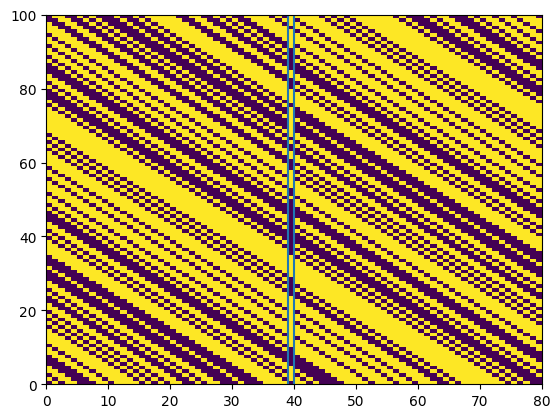

In [ ]:
plt.pcolormesh(np.roll(np.array(ct.vec_history[:100]),shift=-40,axis=1))
# plt.xlim([195,200])
plt.axvline(x=40)
plt.axvline(x=39)

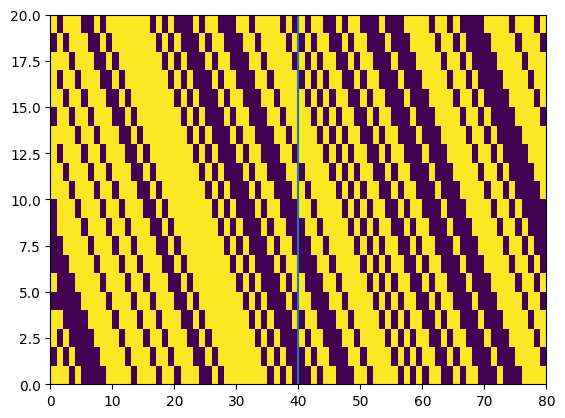

In [ ]:
plt.pcolormesh(np.roll(np.array(ct.vec_history[:20]),shift=1))
# plt.xlim([195,200])
plt.axvline(x=40)

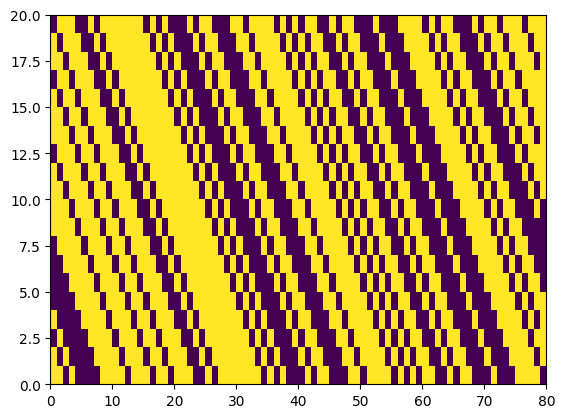

In [ ]:
plt.pcolormesh(np.array(ct.vec_history[:20]))
# plt.xlim([195,200])

In [ ]:
fdw=[np.where(np.diff(ct.vec_history[x])==0)[0][0] if len(np.where(np.diff(ct.vec_history[x])==0)[0])>0 else 80 for x in range(len(ct.vec_history))]

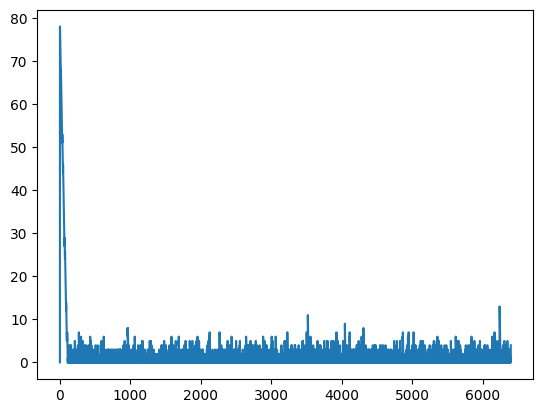

In [ ]:
plt.plot(fdw)

In [ ]:
ct.vec_history[-1]

array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
ct.binary[1/6]

array([0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
ct.binary[1/3]

array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
from fractions import Fraction

In [ ]:
int(Fraction(1,3)*2)

0

In [ ]:
dec2bin(Fraction(1,3), L=80)

array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1])

### Benchmark

In [293]:
2**(8**2*0.4)

50859008.46224668

In [30]:
ct_q=CT_quantum(L=8,seed=seed_list[0],seed_vec=0,seed_C=seed_C_list[5],x0=None,ancilla=False,store_vec=False,store_op=True,store_prob=True,normalization=True)
for _ in range(2*ct_q.L**2):
        ct_q.random_control(p_ctrl, p_proj)
prob_log(ct_q)

0

In [28]:
ct_q.prob_history

[0.5016572952860143]

In [ ]:
p_ctrl=0
p_proj=0.01
seed_C_list=np.arange(0,10)
seed_list=np.arange(0,3200)
logp_q=np.zeros((seed_C_list.shape[0],seed_list.shape[0]))
logp_r=np.zeros((seed_C_list.shape[0],seed_list.shape[0]))
for seed_C_idx,seed_C in tqdm(enumerate(seed_C_list[5:6])):
    for seed_idx,seed in enumerate(seed_list):
        ct_q=CT_quantum(L=8,seed=seed,seed_vec=0,seed_C=seed_C,x0=None,ancilla=False,store_vec=False,store_op=True,store_prob=True,normalization=True)
        for _ in range(2*ct_q.L**2):
            ct_q.random_control(p_ctrl, p_proj)
        ct_r=CT_quantum(L=8,seed=seed,seed_vec=1,seed_C=seed_C,x0=None,ancilla=False,store_vec=False,store_op=True,store_prob=True,normalization=True)
        ct_r.reference_control(ct_q.op_history)
        logp_q[seed_C_idx,seed_idx]=(prob_log(ct_q))
        logp_r[seed_C_idx,seed_idx]=(prob_log(ct_r))

In [295]:
np.unique(logp_r[1]).shape

(9039,)

In [296]:
np.unique(logp_q[1]).shape

(9039,)

In [298]:
Chi_C=[Chi(np.unique(logp_q_C),np.unique(logp_r_C)) for logp_q_C,logp_r_C in zip(logp_q,logp_r)]

In [299]:
Chi_C

[1.2204434095850862,
 1.4832580052899909,
 1.6849989707741282,
 1.9461484203251758,
 1.2565635552282273]

In [ ]:
Chi_C

[7.271780941179475,
 3.0204472768884774,
 11.63427729243071,
 1.663607681322898,
 2.210607960591803,
 1.960302521171351,
 0.31708449391710963,
 1.7609272408790098,
 1.9169870278670584,
 0.3990319796602644,
 0.44508019261165976,
 5.356262237702293,
 1.6722956512715366,
 0.26148276362415546,
 1.0605101318729389]

In [199]:
np.mean(Chi_C)

2.456715949374477

In [ ]:
np.mean(Chi_C)

2.7300456928660495

In [326]:
p1=np.random.rand(10**8)
p2=np.random.rand(10**8)
p1/=p1.sum()
p2/=p2.sum()


In [342]:
p1@p2/(p2@p2),p1[:200]@p2[:200]/(p2[:200]@p2[:200])

(0.7499311788414372, 0.7937864299502843)

In [270]:
def Chi(logp_q,logp_r):
    logp_qr=logp_q+logp_r # p_qr = p_q* p_r
    logp_rr=2*logp_r # p_r*2
    return np.exp(scipy.special.logsumexp(logp_qr)-scipy.special.logsumexp(logp_rr))

    # np.logaddexp(logp_q,logp_r)
    # return p_q@p_r/p_r@p_r

In [344]:
def sample_Born(logp_r):

    logp_rr=scipy.special.logsumexp(2*np.unique(logp_r))
    return np.exp(scipy.special.logsumexp(logp_r)-logp_rr-np.log(logp_r.shape[0]))
    # -logp_rr
    # np.exp(scipy.special.logsumexp(logp_r))/logp_r.shape[0]

In [ ]:
Still problem with too sparse exploration of the space

In [345]:
[sample_Born(logp_r_C) for logp_r_C in logp_r]

[3.1092641985084093,
 2.3221447656528102,
 2.973992334967399,
 7.661138317920852,
 2.548968201739089]

In [ ]:
[sample_Born(logp_r_C) for logp_r_C in logp_r]

[3.109264198508412,
 2.322144765652812,
 2.973992334967402,
 7.661138317920859,
 2.5489682017390916]

In [275]:
[np.unique(logp_r_C).shape for logp_r_C in logp_r]

[(128,), (638,), (128,), (997,), (637,)]

In [84]:
(np.exp(logp_q)@np.exp(logp_r))/(np.exp(logp_r)@np.exp(logp_r))

1.0974274907182509

In [ ]:
2**18

In [24]:
2**18*16*900/1024**2

3600.0

In [27]:
def run_tensor():
    torch.cuda.reset_peak_memory_stats()
    st0=time.time()
    # ct=CT_tensor(L=18,gpu=True,seed=list(range(200)),x0=None,ancilla=False,history=False,complex128=True)
    ct=CT_tensor(L=18,gpu=True,seed=0,x0=None,ancilla=False,history=False,complex128=True,ensemble=900)
    for _ in range(10):
        ct.random_control(0.0,0)
    evo_timestamp=time.time()
    _=ct.order_parameter()
    OP_timestamp=time.time()
    _=ct.half_system_entanglement_entropy()
    EE_timestamp=time.time()
    _=ct.tripartite_mutual_information(np.arange(ct.L//4),np.arange(ct.L//4)+ct.L//4,np.arange(ct.L//4)+ct.L//4*2)
    peak_memory_MB = TMI_timestamp=time.time()
    torch.cuda.max_memory_allocated()/ (1024 ** 2)
    return evo_timestamp-st0,OP_timestamp-evo_timestamp,EE_timestamp-OP_timestamp,TMI_timestamp-EE_timestamp,peak_memory_MB

In [ ]:
run_tensor()

### XEB_GPU

In [39]:
def prob_log(CT):
    if len(CT.prob_history)>0:
        return torch.log(torch.stack(CT.prob_history)).sum(axis=0)
    else:
        return 0
def run_xeb(inputs):
    L,p_ctrl,p_proj,ensemble,ensemble_m,seed_C,seed=inputs
    ct_q=CT_tensor(L=L,seed=seed,seed_vec=seed_C,seed_C=seed_C,ancilla=False,store_vec=False,store_op=True,store_prob=True,complex128=False,gpu=False,ensemble=ensemble,ensemble_m=ensemble_m,xj=set([0]),)
    for _ in range(L**2*2):
        ct_q.random_control(p_ctrl=0, p_proj=0)
    for _ in range(L**2*2):
        ct_q.random_control(p_ctrl, p_proj)
    op_history=ct_q.op_history.copy()
    log_q=prob_log(ct_q)
    tensor_size=ct_q.vec.numel()*ct_q.vec.element_size()/1024**2
    del ct_q
    # gc.collect()
    torch.cuda.empty_cache()
    ct_r=CT_tensor(L=L,seed=seed,seed_vec=1+seed_C,seed_C=seed_C,ancilla=False,store_vec=False,store_op=True,store_prob=True,complex128=False,gpu=False,ensemble=ensemble,ensemble_m=ensemble_m,xj=set([0]))
    for op in op_history:
        ct_r.reference_control(op)
    log_r=prob_log(ct_r)
    del ct_r
    # gc.collect()
    torch.cuda.empty_cache()
    ct_r_=CT_tensor(L=L,seed=seed,seed_vec=1+seed_C,seed_C=seed_C,ancilla=False,store_vec=False,store_op=True,store_prob=True,complex128=False,gpu=False,ensemble=ensemble,ensemble_m=ensemble_m,xj=set([0]))
    for _ in range(L**2*2):
        ct_r_.random_control(p_ctrl=0, p_proj=0)
    for _ in range(L**2*2):
        ct_r_.random_control(p_ctrl, p_proj)
    log_r_=prob_log(ct_r_)
    del ct_r_
    # gc.collect()
    torch.cuda.empty_cache()
    return log_q,log_r,log_r_
    # return ct_q


In [40]:
ts=run_xeb((4,0.5,0.5,4,4,0,0))

Using cpu
Using cpu


Using cpu


In [41]:
ts

(tensor([[-14.7859, -15.3558, -12.5596, -17.2298],
         [-15.2582, -14.7426, -14.6319, -13.9210],
         [-13.2048, -13.1717, -14.9522, -16.3799],
         [-13.5163, -15.0137, -16.0329, -13.9236]]),
 tensor([[-14.5377, -18.0983, -14.0975, -18.7984],
         [-15.3880, -15.3493, -15.2040, -13.9356],
         [-14.3937, -13.9388, -14.3721, -16.6902],
         [-14.8097, -18.6251, -15.3069, -14.0433]]),
 tensor([[-14.5377, -14.0586, -14.0975, -13.8965],
         [-15.3880, -16.5013, -15.2040, -13.9356],
         [-14.3937, -13.9478, -13.6228, -15.2143],
         [-12.8433, -16.6880, -15.3069, -14.0433]]))

In [8]:
%load_ext pytorch_memlab


The pytorch_memlab extension is already loaded. To reload it, use:
  %reload_ext pytorch_memlab


In [11]:
%%mlrun -f run_xeb
ts=run_xeb((8,0,0.1,200,100,0,0))

Using cuda


/home/hnpan/.pyenv/versions/anaconda3-2023.03/lib/python3.10/site-packages/pytorch_memlab/line_profiler/line_records.py:225: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  .hide_index()
/home/hnpan/.pyenv/versions/anaconda3-2023.03/lib/python3.10/site-packages/pytorch_memlab/line_profiler/line_records.py:226: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  .render())


active_bytes,reserved_bytes,line,code
all,all,,
peak,peak,,
75.41M,94.00M,6,def run_xeb(inputs):
75.41M,94.00M,7,"L,p_ctrl,p_proj,ensemble,ensemble_m,seed_C,seed=inputs"
155.41M,174.00M,8,"ct_q=CT_tensor(L=L,seed=seed,seed_vec=seed_C,seed_C=seed_C,x0=None,ancilla=False,store_vec=False,store_op=True,store_prob=True,complex128=False,gpu=True,ensemble=ensemble,ensemble_m=ensemble_m,debug=False)"
133.92M,268.00M,9,for _ in range(L**2*2):
256.25M,268.00M,10,"ct_q.random_control(p_ctrl, p_proj)"
133.92M,268.00M,11,op_history=ct_q.op_history.copy()
153.45M,268.00M,12,log_q=prob_log(ct_q)
134.00M,268.00M,13,tensor_size=ct_q.vec.numel()*ct_q.vec.element_size()/1024**2


In [12]:
ts

In [9]:
from pytorch_memlab import MemReporter
reporter = MemReporter()
reporter.report()

Element type                                            Size  Used MEM
-------------------------------------------------------------------------------
Storage on cuda:0
Tensor0                                             (1, 200)     2.00K
Tensor1                                              (1, 27)   512.00B
Tensor2                                             (1, 173)     1.50K
Tensor3                                            (2, 1396)    22.00K
Tensor4                                            (2, 1304)    20.50K
Tensor5                                              (1, 24)   512.00B
Tensor6                                             (1, 176)     1.50K
Tensor7                                            (2, 1236)    19.50K
Tensor8                                            (2, 1164)    18.50K
Tensor9                                             (1, 200)     2.00K
Tensor10                                             (1, 30)   512.00B
Tensor11                                          

/home/hnpan/.pyenv/versions/anaconda3-2023.03/lib/python3.10/site-packages/torch/distributed/distributed_c10d.py:293: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn(
/home/hnpan/.pyenv/versions/anaconda3-2023.03/lib/python3.10/site-packages/pytorch_memlab/mem_reporter.py:95: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  fact_numel = tensor.storage().size()


In [36]:
log_p_q2,log_p_r2,log_p_r_2=run_xeb((8,0,0.1,200,100,0,0))

Using cuda


Using cuda
Using cuda


In [5]:
%lprun -f run_xeb log_p_q,log_p_r,log_p_r_=run_xeb((8,0,0.1,200,100,0,0))

Using cuda


Using cuda
Using cuda


Timer unit: 1e-09 s

Total time: 16.3689 s
File: /tmp/ipykernel_451014/1106983791.py
Function: run_xeb at line 6

Line #      Hits         Time  Per Hit   % Time  Line Contents
     6                                           def run_xeb(inputs):
     7         1       1223.0   1223.0      0.0      L,p_ctrl,p_proj,ensemble,ensemble_m,seed_C,seed=inputs
     8         1 2623749924.0 2623749924.0     16.0      ct_q=CT_tensor(L=L,seed=seed,seed_vec=seed_C,seed_C=seed_C,x0=None,ancilla=False,store_vec=False,store_op=True,store_prob=True,complex128=False,gpu=True,ensemble=ensemble,ensemble_m=ensemble_m,debug=False)
     9       128      45020.0    351.7      0.0      for _ in range(L**2*2):
    10       128 6114290052.0 47767891.0     37.4          ct_q.random_control(p_ctrl, p_proj)
    11         1       1734.0   1734.0      0.0      op_history=ct_q.op_history.copy()
    12         1     236647.0 236647.0      0.0      log_q=prob_log(ct_q)
    13         1        251.0    251.0      0.0  

In [18]:
%lprun -f run_xeb log_p_q2,log_p_r2,log_p_r_2=run_xeb((8,0,0.1,200,100,0,0))

Using cuda


Using cuda
Using cuda


Timer unit: 1e-09 s

Total time: 15.0881 s
File: /tmp/ipykernel_451014/1106983791.py
Function: run_xeb at line 6

Line #      Hits         Time  Per Hit   % Time  Line Contents
     6                                           def run_xeb(inputs):
     7         1       1322.0   1322.0      0.0      L,p_ctrl,p_proj,ensemble,ensemble_m,seed_C,seed=inputs
     8         1   12405800.0 12405800.0      0.1      ct_q=CT_tensor(L=L,seed=seed,seed_vec=seed_C,seed_C=seed_C,x0=None,ancilla=False,store_vec=False,store_op=True,store_prob=True,complex128=False,gpu=True,ensemble=ensemble,ensemble_m=ensemble_m,debug=False)
     9       128      44966.0    351.3      0.0      for _ in range(L**2*2):
    10       128 6141916141.0 47983719.9     40.7          ct_q.random_control(p_ctrl, p_proj)
    11         1       1403.0   1403.0      0.0      op_history=ct_q.op_history.copy()
    12         1      63602.0  63602.0      0.0      log_q=prob_log(ct_q)
    13         1        221.0    221.0      0.0    

In [37]:
torch.equal(log_p_q2,log_p_q)

True

In [28]:
torch.abs(log_p_q2-log_p_q).max()

tensor(0.0021, device='cuda:0')

In [21]:
log_p_q

tensor([[-19.6495, -20.2078, -20.7177,  ..., -17.2914, -19.1965, -22.8226],
        [-17.6598, -17.4176, -16.3721,  ..., -17.7974, -17.8186, -17.2100],
        [-17.8616, -19.4916, -17.8644,  ..., -20.6029, -17.8874, -17.5374],
        ...,
        [-17.4403, -19.1702, -20.5600,  ..., -19.7264, -18.2033, -17.2442],
        [-17.0506, -17.9160, -17.0333,  ..., -18.2037, -18.8724, -17.0232],
        [-18.7347, -20.4137, -18.4396,  ..., -21.0473, -19.6338, -20.8487]],
       device='cuda:0')

In [313]:
def sample_Born(log_p_r,log_p_r_):
    return torch.exp(torch.logsumexp(log_p_r,dim=1)-torch.logsumexp(log_p_r_,dim=1))

In [324]:
torch.mean(sample_Born(log_p_r, log_p_r_))

tensor(0.7700, device='cuda:0')

### Monitor EE

In [3]:
import pandas as pd

In [4]:
def unzip(op_history):
    for op in op_history:
        if 'B' in op[0]:
            yield 'U'
            yield 'Tl'
        if 'C' in op[0]:
            yield f'R{op[0][1]}'
            yield 'Tr'
            yield 'A'

In [5]:
def run_monitor_EE(inputs):
    # set([Fraction(1,3),Fraction(2,3)]) , set([0])
    L,p_ctrl,p_proj,xj,idx=inputs
    ct_q=CT_quantum(L=L,seed=idx,seed_vec=None,seed_C=None,x0=None,ancilla=False,store_vec=True,store_op=True,store_prob=False,normalization=True,xj=xj,monitor=True)
    for _ in range(2*ct_q.L**2):
        ct_q.random_control(p_ctrl=p_ctrl,p_proj=p_proj)
    df_diff=pd.DataFrame({'op':list(unzip(ct_q.op_history)),'EE':np.array(ct_q.EE_history[1:])-np.array(ct_q.EE_history[:-1])})
    return df_diff

In [8]:
df_diff_0_list=[]
for idx in tqdm(range(100)):
    df_diff_0_list.append(run_monitor_EE((10,0.9,0.,set([1]),idx+1000)))

100%|██████████| 100/100 [00:05<00:00, 17.09it/s]


In [9]:
pd.concat(df_diff_0_list).groupby('op').agg(['mean','count'])

EE       
            mean  count
op                     
A   5.753153e-18  18024
R0 -2.085986e-02   2241
R1 -2.936476e-03  15783
Tl  7.118687e-17   1976
Tr -1.259375e-02  18024
U   1.197418e-02   1976

In [97]:
pd.concat(df_diff_0_list).groupby('op').agg(['mean','count'])

EE       
            mean  count
op                     
A   0.000000e+00  10014
R0 -2.576133e-02   5182
R1 -2.772197e-02   4832
Tl  2.461391e-17   9986
Tr -4.414981e-02  10014
U   4.364772e-02   9986

In [103]:
pd.concat(df_diff_0_list).groupby('op').agg(['mean','count'])

EE       
            mean  count
op                     
A   0.000000e+00  18024
R0 -2.924513e-03  15845
R1 -2.119572e-02   2179
Tl  5.298281e-17   1976
Tr -1.263151e-02  18024
U   1.203067e-02   1976

In [11]:
df_0={}
for L in [8,10,12]:
    df_0[L]=monitor_stat(L,xj=set([0]))

100%|██████████| 18/18 [07:09<00:00, 23.84s/it]


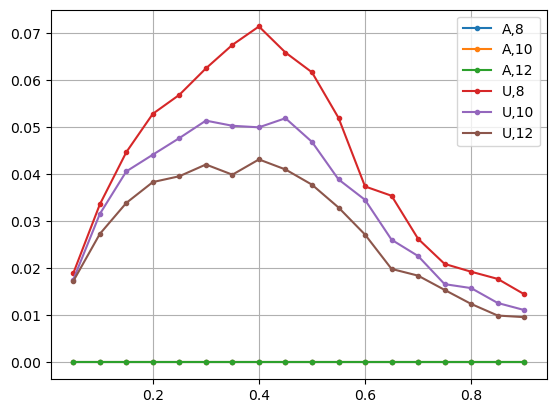

In [12]:
fig,ax=plt.subplots()
for op in ['A','U',]:
    for L in [8,10,12,]:
        ax.plot(df_0[L].xs(key=op, level='op').xs(key=L,level='L')[('EE', 'mean')],'.-',label=f'{op},{L}')
ax.legend()
ax.grid('on')

In [5]:
def monitor_stat(L,xj):
    p_ctrl_list=np.arange(0.05,0.95,0.05)
    dict_df=[]
    for p_ctrl in tqdm(p_ctrl_list):
        df_diff_1_3_list=[]
        for idx in (range(200)):
            df_diff_1_3_list.append(run_monitor_EE((L,p_ctrl,0.,xj,idx)))
        tmp=pd.concat(df_diff_1_3_list).groupby('op').agg(['mean','count'])
        tmp.index=pd.MultiIndex.from_tuples([(L,p_ctrl,x,) for x in tmp.index],names=['L','p_ctrl','op'])
        dict_df.append(tmp)
    dict_df=pd.concat(dict_df)
    return dict_df

In [10]:
df_1_3={}
for L in [8,10,12]:
    df_1_3[L]=monitor_stat(L,xj=set([Fraction(1,3),Fraction(2,3)]))

100%|██████████| 18/18 [19:05<00:00, 63.63s/it]


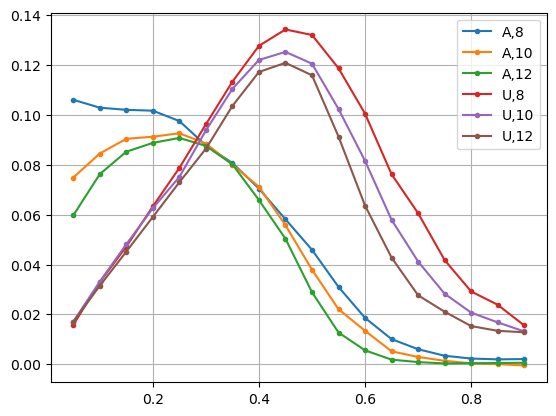

In [12]:
fig,ax=plt.subplots()
for op in ['A','U',]:
    for L in [8,10,12,]:
        ax.plot(df_1_3[L].xs(key=op, level='op').xs(key=L,level='L')[('EE', 'mean')],'.-',label=f'{op},{L}')
ax.legend()
ax.grid('on')

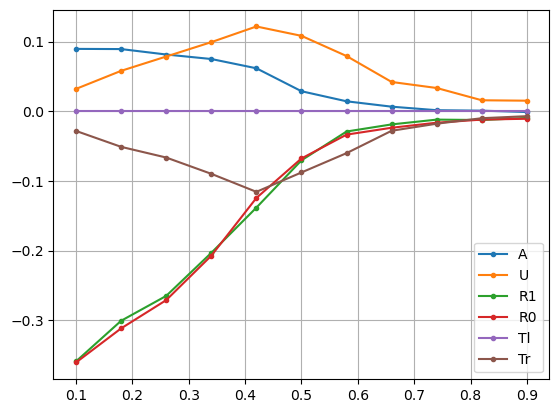

In [146]:

fig,ax=plt.subplots()
for op in ['A','U','R1','R0','Tl','Tr']:
    ax.plot(dict_1_3.xs(key=op, level='op')[('EE', 'mean')],'.-',label=op)
ax.legend()
ax.grid('on')

In [10]:
df_m1_3={}
for L in [8,10,12]:
    df_m1_3[L]=monitor_stat(L,xj=set([Fraction(1,3),Fraction(-1,3)]))

100%|██████████| 18/18 [15:37<00:00, 52.08s/it]


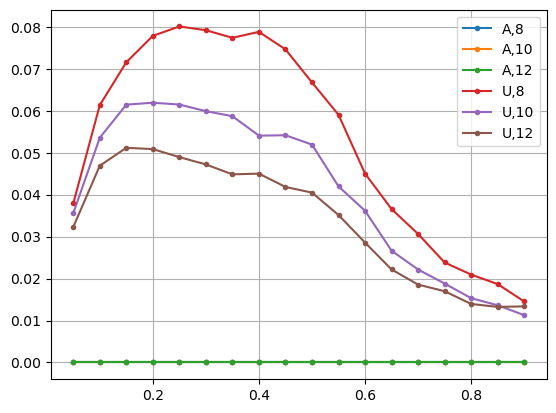

In [12]:
fig,ax=plt.subplots()
for op in ['A','U',]:
    for L in [8,10,12,]:
        ax.plot(df_m1_3[L].xs(key=op, level='op').xs(key=L,level='L')[('EE', 'mean')],'.-',label=f'{op},{L}')
ax.legend()
ax.grid('on')

In [125]:
tmp.index.tolist()

['A', 'R0', 'R1', 'Tl', 'Tr', 'U']

In [128]:
([(p_ctrl,)+(x,) for x in tmp.index])

[(0.1, 'A'), (0.1, 'R0'), (0.1, 'R1'), (0.1, 'Tl'), (0.1, 'Tr'), (0.1, 'U')]

In [ ]:
pd.DataFrame(df_1_3)

In [115]:
pd.concat(df_diff_1_3_list).groupby('op').agg(['mean','count']).index

Index(['A', 'R0', 'R1', 'Tl', 'Tr', 'U'], dtype='object', name='op')

In [118]:
tpd.concat(df_diff_1_3_list).groupby('op').agg(['mean','count'])

EE      
            mean count
op                    
A   8.963118e-02   204
R0 -3.608373e-01    93
R1 -3.592753e-01   111
Tl -8.740843e-17  1796
Tr -2.823428e-02   204
U   3.216208e-02  1796

In [99]:
pd.concat(df_diff_1_3_list).groupby('op').agg(['mean','count'])

EE       
            mean  count
op                     
A   3.805346e-02  10014
R0 -7.455251e-02   5066
R1 -7.259030e-02   4948
Tl -2.249983e-18   9986
Tr -1.089190e-01  10014
U   1.229653e-01   9986

In [101]:
pd.concat(df_diff_1_3_list).groupby('op').agg(['mean','count'])

EE       
            mean  count
op                     
A   9.432962e-02   5089
R0 -2.593128e-01   2589
R1 -2.598428e-01   2500
Tl -5.790074e-17  14911
Tr -7.862458e-02   5089
U   7.958349e-02  14911

In [105]:
pd.concat(df_diff_1_3_list).groupby('op').agg(['mean','count'])

EE       
            mean  count
op                     
A  -3.655002e-04  18024
R0 -8.815587e-03   9119
R1 -1.050830e-02   8905
Tl  4.799636e-17   1976
Tr -7.775009e-03  18024
U   1.228151e-02   1976

## Fix Adder

### average EE

In [296]:
def run_ave(L):
    ct_q=CT_quantum(L=L,seed=None,seed_vec=None,seed_C=None,ancilla=False,store_vec=False,store_op=False,store_prob=False,normalization=True,xj=set([Fraction(1,3),Fraction(2,3)]),monitor=True,)
    EE0=ct_q.half_system_entanglement_entropy(n=1,)
    vec=ct_q.R_tensor(ct_q.vec, n=[0],pos=[ct_q.L-1])
    vec=ct_q.T_tensor(vec, left=False)
    EE=ct_q.half_system_entanglement_entropy(n=1,vec=vec)
    vec=np.roll(vec,2**(ct_q.L//2-1))
    EE2=ct_q.half_system_entanglement_entropy(n=1,vec=vec)
    return EE0,EE,EE2
    
    


In [297]:
EE_list=np.array([[run_ave(L) for _ in range(1000)] for L in range(4,14,2)])

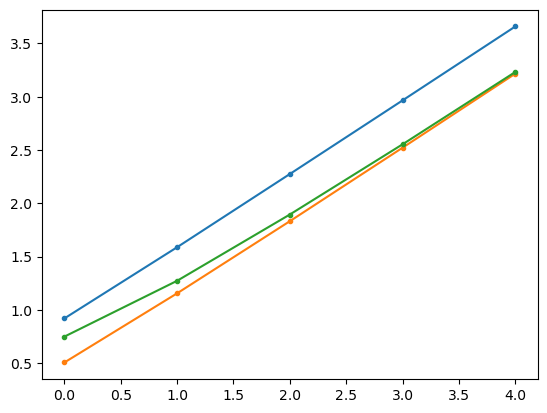

In [298]:
plt.plot(np.mean(EE_list[...,0],axis=1).T,'.-')
plt.plot(np.mean(EE_list[...,1],axis=1).T,'.-')
plt.plot(np.mean(EE_list[...,2],axis=1).T,'.-')

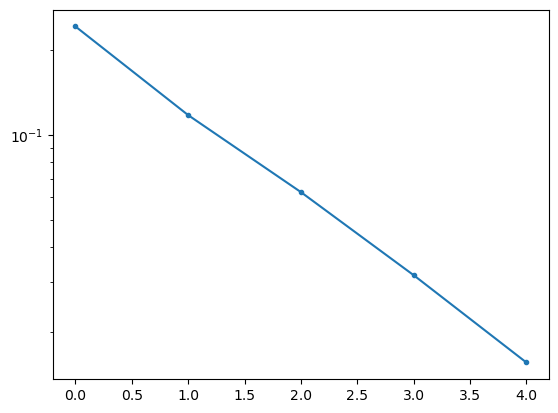

In [299]:
plt.plot(np.mean(EE_list[...,2]-EE_list[...,1],axis=1).T,'.-')
plt.yscale('log')

In [303]:
EE_list[...,0].mean(axis=1)/np.log(2)

array([1.3287302 , 2.29210411, 3.28249577, 4.27844491, 5.27836805])

In [306]:
EE_list[...,1].mean(axis=1)/np.log(2)

array([0.73269256, 1.66836604, 2.64410555, 3.63839011, 4.64015171])

In [305]:
np.log(2**(np.arange(2,7)))/np.log(2)-(1/(2*np.log(2)))

array([1.27865248, 2.27865248, 3.27865248, 4.27865248, 5.27865248])

In [317]:
def page_state(d_A,d_B):
    d_min=min(d_A,d_B)
    d_max=max(d_A,d_B)
    return np.log(d_min)/np.log(2)-(1/(2*np.log(2)))*(d_min/d_max)

In [322]:
page_state(2**4,2**5)

3.639326239777759

In [295]:
-np.log(2**(np.arange(2,8)+1)/(2**(2*np.arange(2,8))+1))

array([0.7537718 , 1.40179855, 2.08334018, 2.77356481, 3.46598001,
       4.15894412])

In [201]:
np.mean(EE_list/np.log(2))

0.8398369095501361

### trials

In [337]:
ct_q=CT_quantum(L=4,seed=1,seed_vec=None,seed_C=None,ancilla=False,store_vec=False,store_op=False,store_prob=False,normalization=True,xj=set([Fraction(1,3),Fraction(2,3)]),monitor=True,)
# ct_q.encoding()

In [338]:
ct_q.half_system_entanglement_entropy(n=2,vec=ct_q.vec)

0.47244145296335277

In [339]:
vec=ct_q.R_tensor(ct_q.vec, n=[0],pos=[ct_q.L-1])
vec=ct_q.T_tensor(vec, left=False)

In [340]:
vec=vec.reshape(4,4)

In [341]:
vec2=np.roll(vec,2**(ct_q.L//2-1))

In [342]:
vec2.shape

(4, 4)

In [343]:
ct_q.half_system_entanglement_entropy(n=2,vec=vec)

0.2999087408037949

In [344]:
ct_q.half_system_entanglement_entropy(n=2,vec=vec2)

0.36300026780010153

In [345]:
p=np.linalg.eigvals(np.array([[vec[i1]@vec[i2].conj() for i1 in range(2)] for i2 in range(2)]))

In [245]:
p2=np.linalg.eigvals(np.array([[vec2[i1]@vec2[i2].conj() for i1 in range(3)] for i2 in range(3)]))

In [246]:
np.sum(np.abs(vec)**2)

1.0000000000000002

### Get A,B matrices

In [532]:
def run_AB(L):
    ct_q=CT_quantum(L=L,seed=None,seed_vec=None,seed_C=None,ancilla=False,store_vec=False,store_op=False,store_prob=False,normalization=True,xj=set([Fraction(1,3),Fraction(2,3)]),monitor=True,)
    # ct_q.encoding()
    ct_q.half_system_entanglement_entropy(n=2,vec=ct_q.vec)
    vec=ct_q.R_tensor(ct_q.vec, n=[0],pos=[ct_q.L-1])
    vec=ct_q.T_tensor(vec, left=False)
    # vec2=np.roll(vec,2**(ct_q.L//2-1))
    A,B=get_AB(vec,L)
    ee=ct_q.half_system_entanglement_entropy(n=2,vec=vec)
    return A,B,ee

In [533]:
A_list=[]
B_list=[]
ee_list=[]
for _ in range(1000):
    A,B,ee=run_AB(6)
    A_list.append(A)
    B_list.append(B)
    ee_list.append(ee)

In [534]:
np.mean(ee_list)

1.017136536782258

In [487]:
-np.log((2**1+2**2)/(2**3+1))

0.40546510810816444

In [557]:
ff=lambda L:2**(L//2-2)/(2**(L-1)+1) * (2**(L//2-1)-1)/(2**(L//2-1))

In [558]:
ff(6)

0.045454545454545456

In [553]:
rho_list=[]
for A,B in zip(A_list,B_list):
    # rho=A@A.conj().T+B@B.conj().T
    # rhoA=A@A.conj().T
    # rhoB=B@B.conj().T
    # rho_list.append(np.trace(rho@rho))
    # rho_list.append(np.trace(rhoA@rhoA))


    A2=np.zeros((A.shape[0]*2,A.shape[1]*2),dtype=complex)
    B2=np.zeros((B.shape[0]*2,B.shape[1]*2),dtype=complex)
    A2[:A.shape[0],:A.shape[0]]=A
    B2[1:A.shape[0]+1,1:A.shape[0]+1]=B
    rhoA=A2@A2.conj().T
    rhoB=B2@B2.conj().T
    rho_list.append(np.trace(rhoA@rhoB))

In [554]:
(np.mean((rho_list)))

(0.04595583719186467+6.220609964635582e-21j)

In [530]:
def get_AB(vec,L):
    L=int(np.log2(vec.size))
    vec=vec.reshape((2,)*L)
    A=vec[(0,)+(slice(None),)*(L//2-1)+(0,)+(slice(None),)*(L//2-1)].reshape((2**(L//2-1),2**(L//2-1)))
    B=vec[(0,)+(slice(None),)*(L//2-1)+(1,)+(slice(None),)*(L//2-1)].reshape((2**(L//2-1),2**(L//2-1)))
    return A,B
    

In [403]:
A,B=get_AB(vec)

In [459]:
np.trace(A@A.conj().T+B@B.conj().T)

(1.0000000000000002+0j)

In [454]:
B

array([[ 0.09822321+0.07924527j, -0.1984157 -0.04389125j],
       [-0.73044227-0.50893856j,  0.05755977+0.05855094j]])

In [425]:
A1=np.zeros((A.shape[0]*2,A.shape[1]*2),dtype=complex)
B1=np.zeros((B.shape[0]*2,B.shape[1]*2),dtype=complex)
A1[:A.shape[0],:A.shape[0]]=A
B1[:A.shape[0],:A.shape[0]]=B

In [430]:
rho1=A1@A1.conj().T+B1@B1.conj().T

In [421]:
A2=np.zeros((A.shape[0]*2,A.shape[1]*2),dtype=complex)
B2=np.zeros((B.shape[0]*2,B.shape[1]*2),dtype=complex)
A2[:A.shape[0],:A.shape[0]]=A
B2[1:A.shape[0]+1,1:A.shape[0]+1]=B

In [427]:
rho2=A2@A2.conj().T+B2@B2.conj().T

In [431]:
np.round(rho1,2)

array([[ 0.19+0.j  , -0.15+0.03j,  0.  +0.j  ,  0.  +0.j  ],
       [-0.15-0.03j,  0.81+0.j  ,  0.  +0.j  ,  0.  +0.j  ],
       [ 0.  +0.j  ,  0.  +0.j  ,  0.  +0.j  ,  0.  +0.j  ],
       [ 0.  +0.j  ,  0.  +0.j  ,  0.  +0.j  ,  0.  +0.j  ]])

In [ ]:
np.round(rho2,2)

array([[ 0.13+0.j  , -0.02+0.03j,  0.  +0.j  ,  0.  +0.j  ],
       [-0.02-0.03j,  0.07+0.j  , -0.13+0.j  ,  0.  +0.j  ],
       [ 0.  +0.j  , -0.13-0.j  ,  0.8 +0.j  ,  0.  +0.j  ],
       [ 0.  +0.j  ,  0.  +0.j  ,  0.  +0.j  ,  0.  +0.j  ]])

In [450]:
2*np.trace(A1@A1.conj().T@(B2@B2.conj().T-B1@B1.conj().T))/(np.trace(rho@rho.conj().T))

(-0.06114246105398085+0j)

In [445]:
np.trace(B2@B2.conj().T)-np.trace(B1@B1.conj().T)

0j

In [451]:
np.trace(rho2@rho2.conj().T-rho@rho.conj().T)/(np.trace(rho@rho.conj().T))

(-0.06114246105398089+0j)

In [ ]:
np.array([[vec[i1]@vec[i2].conj() for i1 in range(4)] for i2 in range(4)])

In [373]:
rho=np.array([[vec[i1]@vec[i2].conj() for i1 in range(4)] for i2 in range(4)])

In [376]:
np.round(rho,3)

array([[ 0.189+0.j   , -0.151-0.029j,  0.   +0.j   ,  0.   +0.j   ],
       [-0.151+0.029j,  0.811+0.j   ,  0.   +0.j   ,  0.   +0.j   ],
       [ 0.   +0.j   ,  0.   +0.j   ,  0.   +0.j   ,  0.   +0.j   ],
       [ 0.   +0.j   ,  0.   +0.j   ,  0.   +0.j   ,  0.   +0.j   ]])

In [360]:
np.linalg.eigvals(rho)**2

array([0.02339405+0.j, 0.71749178+0.j])

In [435]:
-np.log(np.trace(rho@rho))

(0.2999087408037948-0j)

In [449]:
-np.log(np.trace(rho2@rho2))

(0.36300026780010164-0j)

In [452]:
-np.log(np.trace(rho2@rho2))-(-np.log(np.trace(rho@rho)))

(0.06309152699630682+0j)

In [371]:
np.round(np.array([[vec2[i1]@vec2[i2].conj() for i1 in range(4)] for i2 in range(4)]),3)

array([[ 0.132+0.j   , -0.025-0.028j,  0.   +0.j   ,  0.   +0.j   ],
       [-0.025+0.028j,  0.069+0.j   , -0.126-0.001j,  0.   +0.j   ],
       [ 0.   +0.j   , -0.126+0.001j,  0.799+0.j   ,  0.   +0.j   ],
       [ 0.   +0.j   ,  0.   +0.j   ,  0.   +0.j   ,  0.   +0.j   ]])

In [346]:
np.sum(-p*np.log(p))

(0.4277941575261357+0j)

In [250]:
np.sum(-p2*np.log(p2))

(0.5576068465310358+7.658243537805537e-17j)

In [108]:
-np.log((10+10)/(10*10+1))

1.6193882432872684

In [57]:
ct_q.vec

(2, 2, 2, 2)

In [59]:
p=np.sum(np.abs(ct_q.vec)**2,axis=(2,3))

1.3001018796677688

In [55]:
-np.sum(np.abs(ct_q.vec)**2*np.log(np.abs(ct_q.vec)**2))

2.3714883532190947

In [30]:
vec=ct_q.P_tensor(ct_q.vec, n=[0],pos=[ct_q.L-1])
vec=ct_q.T_tensor(vec, left=False)

# ct_q.vec_history[-1]=np.kron(Haar_state(ct_q.L//2,ensemble=1,k=1).flatten(),Haar_state(ct_q.L//2,ensemble=1,k=1).flatten())

ee0=ct_q.half_system_entanglement_entropy(vec=vec)
vec=np.roll(vec,2**(ct_q.L//2-1))
ee1=ct_q.half_system_entanglement_entropy(vec=vec)
dEE=ee1-ee0

In [31]:
dEE

0.09622726591284159

In [ ]:
ct_q.vec_history[-1].flatten()

In [131]:
dEE

2.220446049250313e-16

### Run delta EE

In [47]:
def run_dEE(adder):
    ct_q=CT_quantum(L=4,seed=None,seed_vec=None,seed_C=None,x0=None,ancilla=False,store_vec=True,store_op=True,store_prob=False,normalization=True,xj=set([Fraction(1,3),Fraction(2,3)]),monitor=True,)
    vec=ct_q.R_tensor(ct_q.vec, n=[0],pos=[ct_q.L-1])
    vec=ct_q.T_tensor(vec, left=False)
    ee0=ct_q.half_system_entanglement_entropy(vec=vec)
    vec=np.roll(vec,adder)
    ee1=ct_q.half_system_entanglement_entropy(vec=vec)
    return ee1-ee0

In [48]:
adder_list=np.arange(1,2**2)
dEE_list={}
for adder in adder_list:
    dEE_list[adder]=[run_dEE(adder) for _ in range(1000)]

Text(0, 0.5, '$\\Delta$EE')

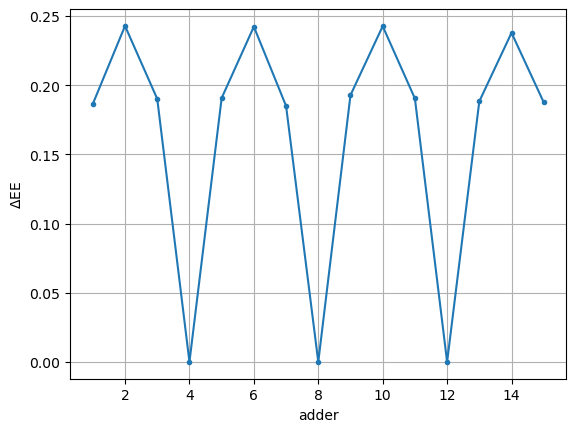

In [ ]:
fig,ax=plt.subplots()
ax.plot(adder_list,[np.mean(dEE_list[adder]) for adder in adder_list],'.-')
ax.grid('on')
ax.set_xlabel('adder')
ax.set_ylabel(r'$\Delta$EE')

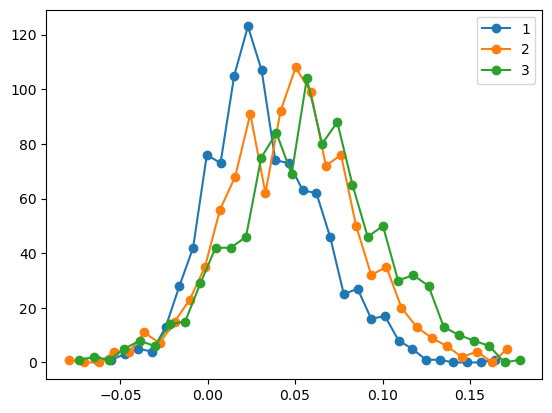

In [251]:
fig,ax=plt.subplots()
# for adder in adder_list:
for adder in [1,2,3]:
    counts, bin_edges = np.histogram(dEE_list[adder], bins=30)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    ax.plot(bin_centers, counts, linestyle='-', marker='o',label=adder)

    # ax.hist(np.array(dEE_list[adder]),bins=10,label=adder,histtype='step',alpha=0.5)
ax.legend()

In [225]:
dEE_list1=[run_dEE(1) for _ in range(1000)]

In [226]:
dEE_list2=[run_dEE(2) for _ in range(1000)]

In [227]:
dEE_list3=[run_dEE(3) for _ in range(1000)]

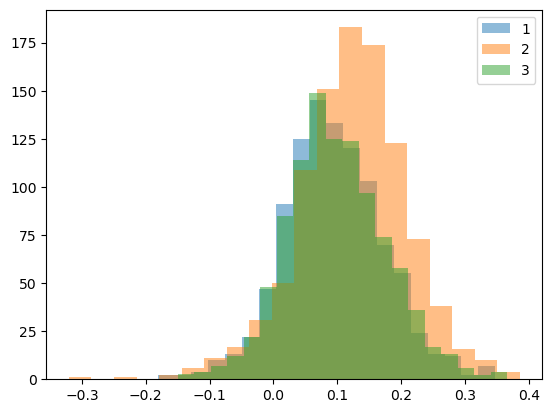

In [230]:
plt.hist(dEE_list1,bins=20,alpha=0.5,label='1')
plt.hist(dEE_list2,bins=20,alpha=0.5,label='2')
plt.hist(dEE_list3,bins=20,alpha=0.5,label='3')
plt.legend()

In [217]:
run_dEE(4)

0.0

In [67]:
ee1

8.289306334778565e-35

In [62]:
ee1-ee0

0.0

In [30]:
ct_q.vec_history[-1].flatten()

array([ 0.06726313+0.15991648j,  0.        +0.j        ,
        0.17621486+0.08688057j,  0.        +0.j        ,
        0.07095892+0.05724878j,  0.        +0.j        ,
       -0.14334049-0.03170814j,  0.        +0.j        ,
        0.00773135-0.05692262j,  0.        +0.j        ,
        0.00158476-0.05364225j,  0.        +0.j        ,
       -0.52768986-0.36767001j,  0.        +0.j        ,
        0.04158262+0.04229867j,  0.        +0.j        ])

In [27]:
vec

array([ 0.        +0.j        ,  0.06726313+0.15991648j,
        0.        +0.j        ,  0.17621486+0.08688057j,
        0.        +0.j        ,  0.07095892+0.05724878j,
        0.        +0.j        , -0.14334049-0.03170814j,
        0.        +0.j        ,  0.00773135-0.05692262j,
        0.        +0.j        ,  0.00158476-0.05364225j,
        0.        +0.j        , -0.52768986-0.36767001j,
        0.        +0.j        ,  0.04158262+0.04229867j])

In [16]:
ct_q.vec_history[-1]

array([[[[ 0.06726313+0.15991648j,  0.06431496-0.25364133j],
         [ 0.17621486+0.08688057j, -0.10451044+0.11310651j]],

        [[ 0.07095892+0.05724878j,  0.00553199+0.10641004j],
         [-0.14334049-0.03170814j, -0.09383778+0.11655704j]]],


       [[[ 0.00773135-0.05692262j, -0.15218755-0.05005887j],
         [ 0.00158476-0.05364225j,  0.25187142+0.19594481j]],

        [[-0.52768986-0.36767001j, -0.03401694-0.08217346j],
         [ 0.04158262+0.04229867j,  0.41220769-0.21643929j]]]])

### run dEE peak

In [366]:
def run_dEE_peak(L):
    ct_q=CT_quantum(L=L,seed=None,seed_vec=None,seed_C=None,x0=None,ancilla=False,store_vec=True,store_op=True,store_prob=False,normalization=True,xj=set([Fraction(1,3),Fraction(2,3)]),monitor=True,)
    vec=ct_q.R_tensor(ct_q.vec, n=[0],pos=[ct_q.L-1])
    vec=ct_q.T_tensor(vec, left=False)
    ee0=ct_q.half_system_entanglement_entropy(vec=vec,n=2)
    vec=np.roll(vec,2**(ct_q.L//2-1))
    ee1=ct_q.half_system_entanglement_entropy(vec=vec,n=2)
    return ee1-ee0

In [588]:
L_list=np.arange(4,16,2)
dEE_peak_list={}
for L in tqdm(L_list):
    dEE_peak_list[L]=[run_dEE_peak(L) for _ in range(1000)]

100%|██████████| 6/6 [00:21<00:00,  3.63s/it]


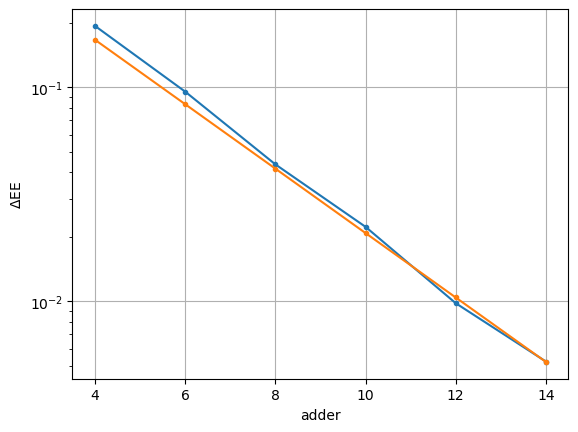

In [589]:
fig,ax=plt.subplots()
ax.plot(L_list,[np.mean(dEE_peak_list[adder]) for adder in L_list],'.-')
ax.plot(L_list,[dE(L) for L in L_list],'.-')
ax.grid('on')
ax.set_xlabel('adder')
ax.set_ylabel(r'$\Delta$EE')
ax.set_yscale('log')

In [560]:
[np.mean(dEE_peak_list[adder]) for adder in L_list]

[0.4240300451571951,
 0.1907519435824663,
 0.08547669205499764,
 0.04300923836418184,
 0.022226545284887295,
 0.009941061566369843,
 0.005208309788715089]

In [582]:
dE=lambda L:2/3*2**(-L/2)

In [584]:
dE(4)

0.16666666666666666

# Classical 

In [48]:
def run_classical(inputs):
    L,p,x0,xj=inputs
    ct=CT_classical(L=L,x0=x0,seed=None,store_vec=False,store_op=False,xj=xj)
    # for _ in range(10):
    for _ in range(2*ct.L**2):
        ct.random_control(p=p)
    return ct.order_parameter()
    # return ct

In [90]:
def run_classical_speed(inputs):
    L,p,x0,xj=inputs
    ct=CT_classical(L=L,x0=x0,seed=None,store_vec=False,store_op=False,xj=xj)
    step=0
    while ct.order_parameter()<1:
        ct.random_control(p=p)
        step+=1
    return step,ct.vec_history[-1]

In [58]:
def run_classical_thermalization(inputs):
    L,p,idx=inputs
    ct=CT_classical(L=L,x0=None,seed=idx,history=True)
    O_list=[]
    for _ in range(ct.L**2):
        ct.random_control(p=p)
        O_list.append(ct.order_parameter())
    return np.array(O_list)

In [23]:
ct=CT_classical(L=4,xj=set([Fraction(1,3),Fraction(2,3)]),x0=Fraction(5,2**4))

In [4]:
bin(ct.vec)

'0b101'

In [9]:
ct.binary_xj[Fraction(1,6)]

3

In [24]:
ct.control_map(ct.vec)

5

In [ ]:
vec=ct.vec
for _ in range(10):
    vec=ct.control_map(vec,)
    print(bin(vec))

In [43]:
ct=run_classical((L,1,Fraction(10,2**L),set([Fraction(1,3),Fraction(2,3)])),)


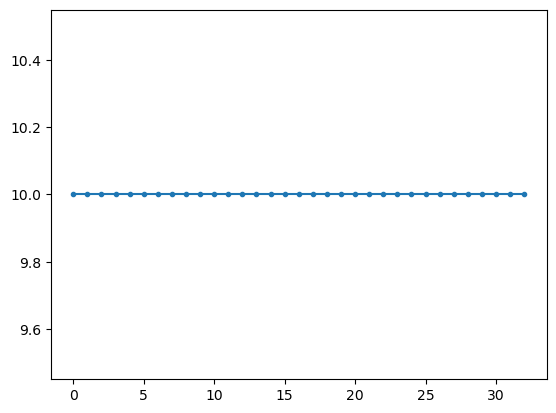

In [44]:
plt.plot(ct.vec_history,'.-')

In [ ]:
L=4
in_list=np.arange(2**L)
out_list=[]
for i in range(2**L):
    # ct=run_classical((L,1,Fraction(i,2**L),set([0])),)
    ct=run_classical((L,1,Fraction(i,2**L),set([Fraction(1,3),Fraction(2,3)])),)
    # ct=run_classical((L,1,Fraction(i,2**L),set([Fraction(1,3),Fraction(-1,3)])),)
    # ct=run_classical((L,1,Fraction(i,2**L),set([1])),)
    out_list.append(ct.vec_history[-1])
    # out_list.append(ct)

In [ ]:
L=8
in_list=np.arange(2**L)
out_list=[]
step_list=[]
for i in range(2**L):
    # step,vec=run_classical_speed((L,1,Fraction(i,2**L),set([0])),)
    # step,vec=run_classical_speed((L,1,Fraction(i,2**L),set([Fraction(1,3),Fraction(2,3)])),)
    # step,vec=run_classical_speed((L,1,Fraction(i,2**L),set([Fraction(1,3),Fraction(-1,3)])),)
    out_list.append(vec)
    step_list.append(step)

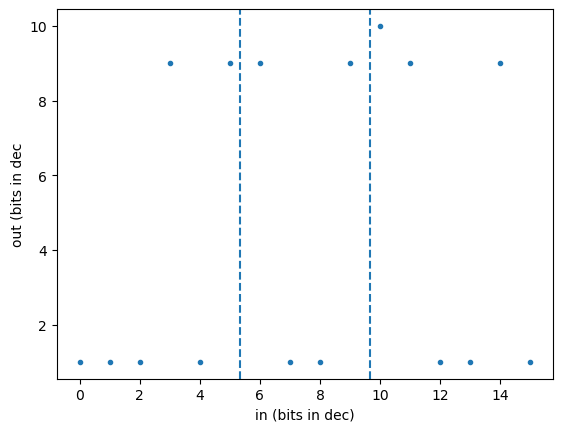

In [32]:
fig,ax=plt.subplots()
ax.plot(in_list,out_list,'.')
# ax.plot(in_list,step_list,'.')
ax.set_xlabel('in (bits in dec)')
ax.set_ylabel('out (bits in dec')
ax.axvline(x=1/3*2**L,ls='dashed')
ax.axvline(x=2/3*2**L-1,ls='dashed')

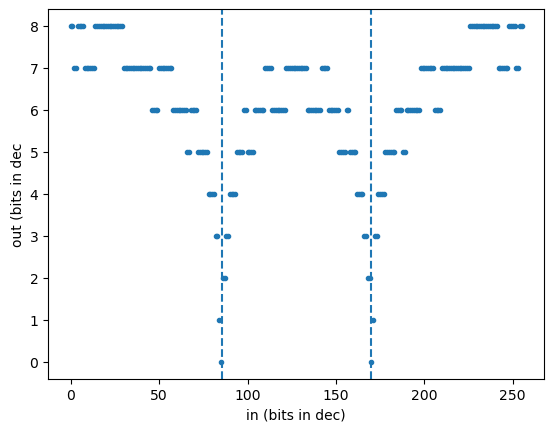

In [102]:
fig,ax=plt.subplots()
# ax.plot(in_list,out_list,'.')
ax.plot(in_list,step_list,'.')
ax.set_xlabel('in (bits in dec)')
ax.set_ylabel('out (bits in dec')
ax.axvline(x=1/3*2**L,ls='dashed')
ax.axvline(x=2/3*2**L-1,ls='dashed')

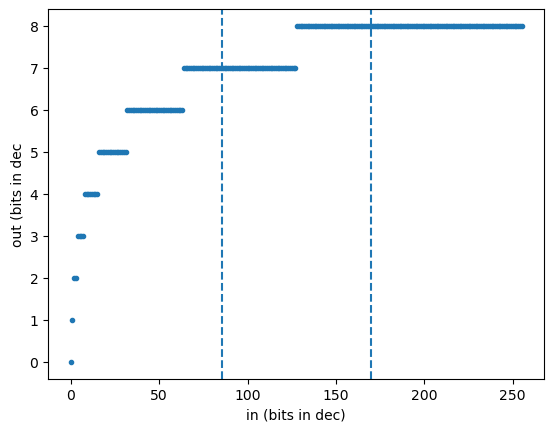

In [104]:
fig,ax=plt.subplots()
# ax.plot(in_list,out_list,'.')
ax.plot(in_list,step_list,'.')
ax.set_xlabel('in (bits in dec)')
ax.set_ylabel('out (bits in dec')
ax.axvline(x=1/3*2**L,ls='dashed')
ax.axvline(x=2/3*2**L-1,ls='dashed')

In [ ]:
from ipyparallel import Client
client = Client()

In [ ]:
dview = client[:]

In [ ]:
dview.execute('import numpy as np').wait()
dview.execute('from CT import *').wait()

True

In [55]:
L_list=np.array([10,12,])
p_list=np.linspace(0,1,11)
ensemble=1000
# inputs=[(L,p,None,set([Fraction(1,3),Fraction(-1,3)])) for L in L_list for p in p_list for idx in range(ensemble)]
inputs=[(L,p,None,set([Fraction(1,3),Fraction(2,3)])) for L in L_list for p in p_list for idx in range(ensemble)]

In [56]:
# results = dview.map_async(run_classical, inputs)
results=map(run_classical, inputs)

In [57]:
O_map=list(results)

In [58]:
O_map=np.array(O_map).reshape((L_list.shape[0],p_list.shape[0],ensemble))

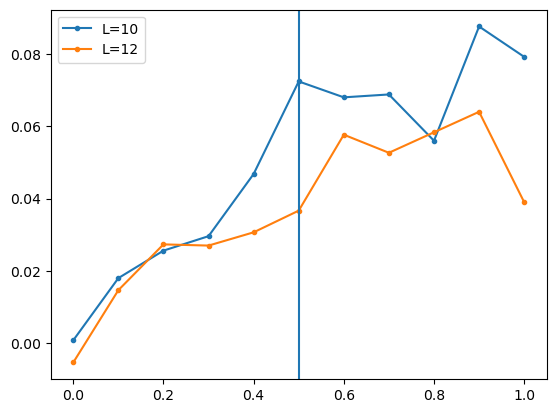

In [59]:
fig,ax=plt.subplots()
for i in range(O_map.shape[0]):
    ax.plot(p_list,O_map[i].mean(axis=-1),'.-',label=f'L={L_list[i]}')
ax.legend()
# plt.plot(p_list,O_map.mean(axis=-1).T)
ax.axvline(x=0.5)


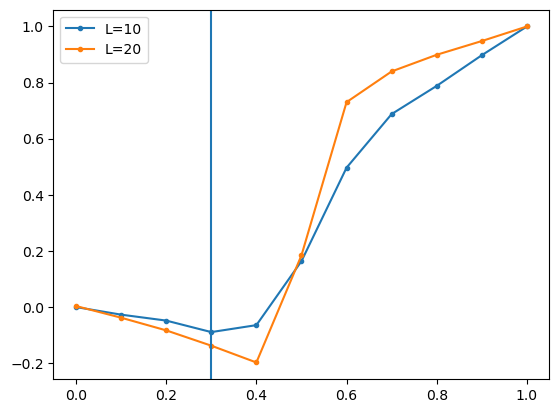

In [ ]:
fig,ax=plt.subplots()
for i in range(O_map.shape[0]):
    ax.plot(p_list,O_map[i].mean(axis=-1),'.-',label=f'L={L_list[i]}')
ax.legend()
# plt.plot(p_list,O_map.mean(axis=-1).T)
ax.axvline(x=0.3)

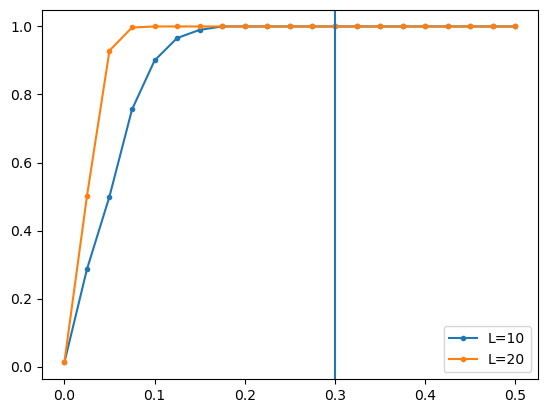

In [190]:
fig,ax=plt.subplots()
for i in range(O_map.shape[0]):
    ax.plot(p_list,O_map[i].mean(axis=-1),'.-',label=f'L={L_list[i]}')
ax.legend()
# plt.plot(p_list,O_map.mean(axis=-1).T)
ax.axvline(x=0.3)

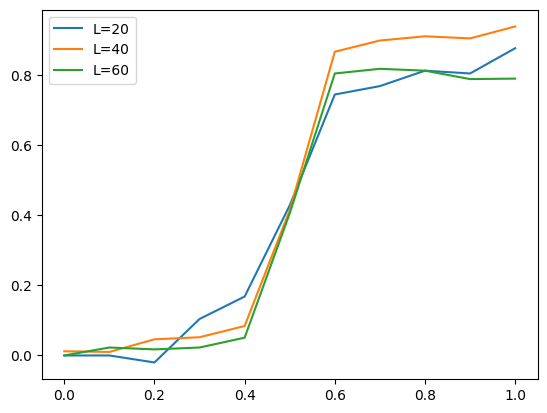

In [ ]:
fig,ax=plt.subplots()
for i in range(O_map.shape[0]):
    ax.plot(p_list,O_map[i].mean(axis=-1),label=f'L={L_list[i]}')
ax.legend()
# plt.plot(p_list,O_map.mean(axis=-1).T)

In [ ]:
# L_list=np.array([20,40,60])
# p_list=np.linspace(0,1,11)
ensemble=50
inputs=[(40,.95,idx) for idx in range(ensemble)]

In [ ]:
results_thermalization = dview.map_async(run_classical_thermalization, inputs)

In [ ]:
results_thermalization.progress

0

In [ ]:
O_map_therm=list(results_thermalization)

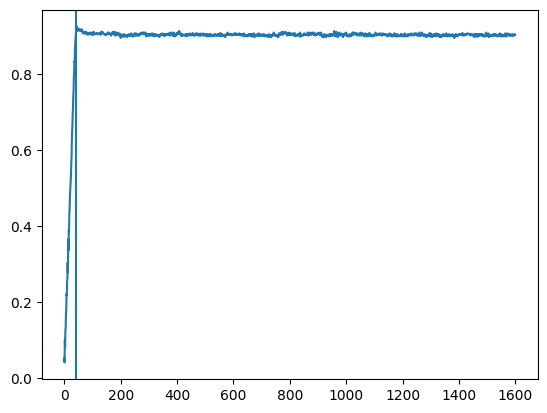

In [ ]:
plt.plot(np.array(O_map_therm).mean(axis=0))
plt.axvline(x=40)

In [ ]:
np.array(O_map_therm)

array([[ 0.2, -0.1,  0.2, ...,  0.9,  0.9,  0.9],
       [-0.1,  0.1, -0.2, ...,  0.9,  0.9,  0.9],
       [ 0.1,  0. ,  0. , ...,  0.9,  0.9,  0.9],
       ...,
       [ 0.1,  0.1,  0.2, ...,  0.9,  0.9,  0.9],
       [ 0.3, -0.2,  0.4, ...,  0.9,  0.9,  0.9],
       [ 0. ,  0. ,  0.1, ...,  0.9,  0.9,  0.9]])

In [ ]:
O_map_therm=np.array(O_map_therm).reshape((ensemble,))

ValueError: cannot reshape array of size 80000 into shape (50,)

In [ ]:
run_classical((20,0.1,1))

0.0

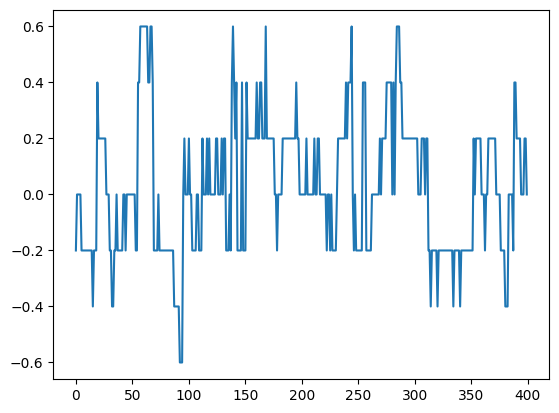

In [ ]:
plt.plot(run_classical_thermalization((20,0.1,1)))

In [ ]:
def 
p_list=np.linspace(0,1,11)
ensemble=20
O_list=np.zeros((p_list.shape[0],ensemble))
for p_idx,p in tqdm(enumerate(p_list)):
    for idx in tqdm(range(ensemble)):
        ct=CT(L=20,classical=True,x0=1/6,seed=idx,history=True)
        for _ in range(ct.L**2):
            ct.random_control(p=p)
        O_list[p_idx,idx]=(ct.order_parameter())

0it [00:00, ?it/s]

100%|██████████| 20/20 [00:00<00:00, 24.71it/s]
11it [00:07,  1.40it/s]


In [ ]:
O_list.shape

(11, 20)

In [ ]:
plt.plot(O_list.mean(axis=-1),'.-')

NameError: name 'O_list' is not defined

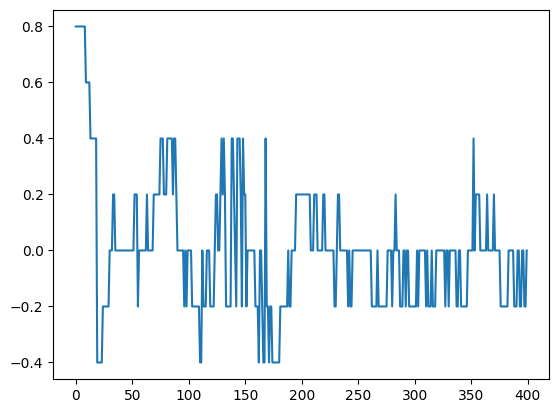

In [ ]:
plt.plot(O_list)

In [ ]:
ct.vec_history

[array([0, 0, 1, 0, 1, 0, 1, 0, 1, 0]),
 array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([0, 1, 0, 0, 1, 0, 1, 0, 0, 1]),
 array([0, 1, 0, 0, 1, 1, 1, 1, 1, 0]),
 array([0, 1, 0, 1, 0, 0, 1, 0, 0, 1]),
 array([1, 0, 1, 0, 0, 1, 0, 0, 1, 0]),
 array([1, 0, 1, 0, 0, 1, 1, 1, 1, 0]),
 array([1, 0, 1, 0, 1, 0, 0, 1, 0, 0]),
 array([1, 0, 1, 0, 1, 0, 0, 1, 1, 1]),
 array([0, 1, 0, 1, 0, 0, 1, 1, 1, 1]),
 array([0, 1, 0, 1, 0, 1, 0, 0, 0, 1]),
 array([1, 0, 1, 0, 1, 0, 0, 0, 0, 1]),
 array([1, 0, 1, 0, 1, 0, 0, 1, 0, 1]),
 array([0, 1, 0, 1, 0, 0, 1, 0, 1, 1]),
 array([0, 1, 0, 1, 0, 0, 1, 1, 1, 1]),
 array([0, 1, 0, 1, 0, 1, 0, 0, 0, 1]),
 array([0, 1, 0, 1, 0, 1, 0, 0, 1, 0]),
 array([0, 1, 0, 1, 0, 1, 0, 0, 1, 1]),
 array([0, 1, 0, 1, 0, 1, 0, 0, 1, 1]),
 array([0, 1, 0, 1, 0, 1, 0, 0, 1, 1]),
 array([0, 1, 0, 1, 0, 1, 0, 0, 1, 1]),
 array([0, 1, 0, 1, 0, 1, 0, 0, 1, 1]),
 array([1, 0, 1, 0, 1, 0, 0, 1, 1, 0]),
 array([1, 0, 1, 0, 1, 0, 1, 0, 0, 0]),
 array([1, 0, 1, 0, 1, 0, 1, 0, 0, 1]),


In [ ]:
ct.op_history

[True, True]

In [ ]:
ct.Bernoulli_map_classical(ct.vec)

array([1, 0, 1, 0, 1, 0, 1, 1, 0, 0])

In [ ]:
ct.vec

array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1])

In [ ]:
dec2bin(1/2, 10)

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
float.hex(1/3)

'0x1.5555555555555p-2'

In [ ]:
np.linalg.svd()

# Quantum

In [95]:
run_quantum((10,0.5,0,1))

(-0.04614952168288143, 1.319775146567285, 0.12989633291864022)

In [79]:
def run_quantum(inputs):
    L,p_ctrl,p_proj,idx=inputs
    ct=CT_quantum(L=L,seed=idx,x0=None,ancilla=False,store_vec=True,store_op=True,store_prob=False,normalization=True,xj=set([Fraction(1,3),Fraction(2,3)]))
    # for ii in range(100):
    for _ in range(2*ct.L**2):
        ct.random_control(p_ctrl=p_ctrl,p_proj=p_proj)
    O=ct.order_parameter()
    SA=ct.half_system_entanglement_entropy()
    TMI=ct.tripartite_mutual_information(np.arange(L//4),np.arange(L//4)+L//4,np.arange(L//4)+(L//4)*2,selfaverage=False)
    return O,SA, TMI
    # return ct

In [7]:
def run_quantum_anc(inputs):
    L,p_ctrl,p_proj,idx=inputs
    ct=CT_quantum(L=L,x0=None,seed=idx,history=True,ancilla=True,xj=[0])
    for _ in range(ct.L):
        ct.random_control_2(p_ctrl=0,p_proj=0)
    # for ii in range(100):
    for _ in range(ct.L**2//2):
        ct.random_control_2(p_ctrl=p_ctrl,p_proj=p_proj)
    O=ct.order_parameter()
    SA=ct.von_Neumann_entropy_pure([ct.L])
    return O,SA
    # return ct

In [5]:
def run_quantum_thermalization(inputs):
    L,p_ctrl,p_proj,idx=inputs
    ct=CT_quantum(L=L,x0=None,seed=idx,history=True)
    SA_list=[]
    for _ in range(2*ct.L**2):
        ct.random_control_2(p_ctrl=p_ctrl,p_proj=p_proj)
        SA=ct.half_system_entanglement_entropy()
        SA_list.append(SA)
    # O=ct.order_parameter()
    return np.array(SA_list)
    # return ct

In [8]:
def run_tensor(inputs):
    L,p_ctrl,p_proj,idx=inputs
    ct=CT_tensor(L=L,x0=None,seed=idx,history=False,)
    # for ii in range(100):
    for _ in range(2*ct.L**2):
        ct.random_control_2(p_ctrl=p_ctrl,p_proj=p_proj)
    O=ct.order_parameter()
    SA=ct.half_system_entanglement_entropy()
    TMI=ct.tripartite_mutual_information(np.arange(L//4),np.arange(L//4)+L//4,np.arange(L//4)+(L//4)*2,selfaverage=False)
    return O,SA, TMI
    # return ct

In [ ]:
def rescale(x,alpha):
    '''rescale the granularity near (a+b)/2, where a, b are boundary of the range x '''
    a,b=min(x),max(x)
    x1=(x-a)*2/(b-a)-1
    y1=np.sign(x1)*np.abs(x1)**alpha
    return (y1+1)*(b-a)/2+a

In [ ]:
SA_list=[]
O_list=[]
L=10
for idx in range(100):
    O,SA=run_quantum((L,0,0,idx))
    O_list.append(O)
    SA_list.append(SA)

In [ ]:
SA_2_list=[]
O_list=[]
L=10
for idx in range(100):
    O,SA_2=run_quantum((L,0.5,0,idx))
    O_list.append(O)
    SA_2_list.append(SA_2)

Text(0.5, 0, '$x_0$')

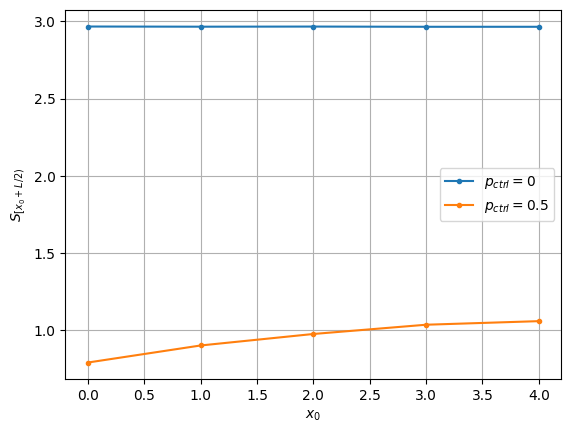

In [ ]:
plt.plot(np.mean(SA_list,axis=0),'.-',label='$p_{ctrl}=0$')
plt.plot(np.mean(SA_2_list,axis=0),'.-',label='$p_{ctrl}=0.5$')
plt.grid()
plt.legend()
plt.ylabel('$S_{[x_0+L/2)}$')
plt.xlabel('$x_0$')

In [ ]:
SA_map=[]
L=10
for idx in range(1000):
    SA_2=run_quantum_thermalization((10,0.5,0,idx))
    SA_map.append(SA_2)

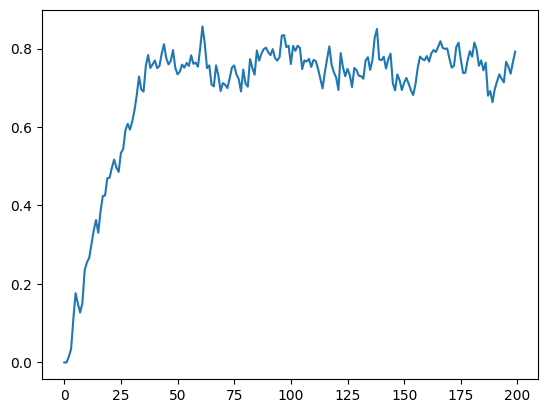

In [ ]:
plt.plot(np.mean(SA_map,axis=0)[:,0])

(200, 5)

Text(0.5, 0, '$x_0$')

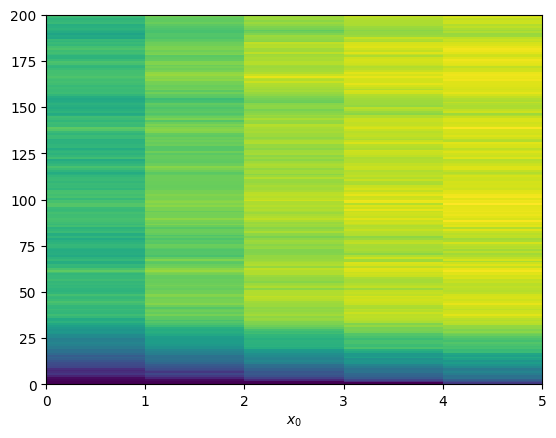

In [ ]:
fig,ax=plt.subplots()
ax.pcolormesh(np.mean(SA_map,axis=0))
ax.set_xlabel('$x_0$')

In [ ]:
np.array(SA_map).shape

(10, 200, 5)

In [ ]:
np.array(SA_list)

array([[2.95615988, 2.9545002 , 2.95218596, 2.97042591, 2.97015354],
       [2.99142741, 2.98224886, 2.99348063, 2.97498381, 3.00638644],
       [2.96444426, 2.96448419, 2.96250958, 2.97652622, 2.99537456],
       [2.98514777, 2.97024653, 2.97534065, 2.96991505, 2.9593723 ],
       [2.95655729, 2.98074337, 2.9860029 , 2.98254184, 2.98157822],
       [2.9968468 , 3.00432728, 2.97800095, 2.98013325, 2.97425851],
       [2.94451527, 2.96895904, 2.98118   , 2.9497661 , 2.93062058],
       [2.99987777, 2.99078147, 2.98702571, 2.99035881, 2.96635857],
       [2.95874235, 2.94888555, 2.97129637, 2.97685425, 2.9552041 ],
       [2.97266694, 2.97187236, 2.96224313, 2.97469608, 2.96774891]])

In [ ]:
check history statistics
check profiler

In [ ]:
run_quantum((10,.3,0,20+100))

(0.06512994146014676, 1.4429114472360913, -0.279259003099499)

In [ ]:
z=[run_quantum((10,.6,0,idx+100)) for idx in range(100)]

In [ ]:
EE,TMI=np.array(z)[:,1],np.array(z)[:,2]

In [ ]:
TMI.mean()

-9.047162691855108e-05

In [ ]:
from collections  import Counter

In [ ]:
rate=[]
for _ in range(10):
    ct=run_quantum((10,0.5,0.3,None))
    cc=Counter(ct.op_history)
    rate.append((cc['I'])/cc['chaotic']/2)

In [ ]:
sp.csr_matrix((2**2,1),dtype=complex)

<4x1 sparse matrix of type '<class 'numpy.complex128'>'
	with 0 stored elements in Compressed Sparse Row format>

In [ ]:
kron_list([sp.eye(2),sp.eye(2)])

<4x4 sparse matrix of type '<class 'numpy.float64'>'
	with 8 stored elements (blocksize = 2x2) in Block Sparse Row format>

In [ ]:
sp.kron(sp.csr_matrix([[1,0],[0,1]]),sp.csr_matrix([[1,0],[0,1]]))

<4x4 sparse matrix of type '<class 'numpy.int64'>'
	with 8 stored elements (blocksize = 2x2) in Block Sparse Row format>

In [ ]:
run_quantum_anc((10,1,0.0,11+100))

(1.0, -0.0)

In [ ]:
ct

(0.3807515810144653, -8.881784197001068e-16)

In [ ]:
zz=[ct.von_Neumann_entropy_pure([ct.L],vec) for vec in ct.vec_history]

AttributeError: 'tuple' object has no attribute 'vec_history'

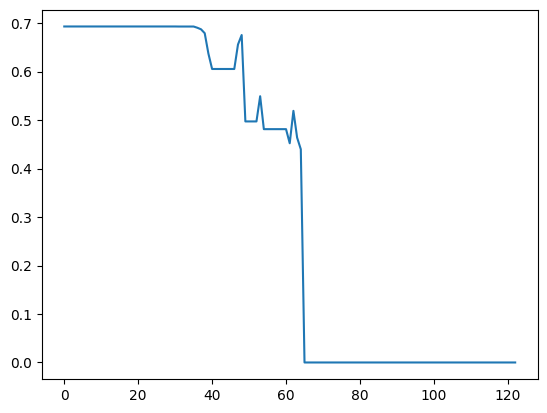

In [ ]:
plt.plot(zz)
# plt.axvline(x=)

In [ ]:
z=[run_quantum_anc((10,0.5,0.,idx+100))/np.log(2) for idx in range(100)]

In [ ]:
EE=np.array(z)[:,1]

In [ ]:
np.mean(EE)

0.5394040017047522

In [ ]:
EE[71]

-6.406853007629832e-16

In [ ]:
np.argsort(EE)

array([11, 71, 49, 51, 80, 59, 55, 17, 58, 23, 40, 96, 97, 85, 47, 15, 74,
       66, 62, 89, 79, 52, 46,  8,  3, 98, 18, 64, 38, 31, 84, 83, 36, 87,
       57, 39, 45, 88, 99, 73, 28, 44, 91, 12, 37, 42,  5, 43, 78,  7,  2,
        1, 60, 95, 14, 56, 76, 67, 82, 30, 48, 25, 24,  6, 20, 81, 21, 53,
       70, 35, 63, 19, 16, 13, 92, 65, 75, 54, 50, 77, 10, 61, 72, 86, 93,
       26, 27, 90,  0, 29, 68, 32, 69,  9, 34, 33, 41,  4, 94, 22])

(array([25.,  3.,  4.,  5.,  3.,  4., 11., 10.,  8., 27.]),
 array([-1.28137060e-15,  9.98794634e-02,  1.99758927e-01,  2.99638390e-01,
         3.99517854e-01,  4.99397317e-01,  5.99276780e-01,  6.99156244e-01,
         7.99035707e-01,  8.98915171e-01,  9.98794634e-01]),
 <BarContainer object of 10 artists>)

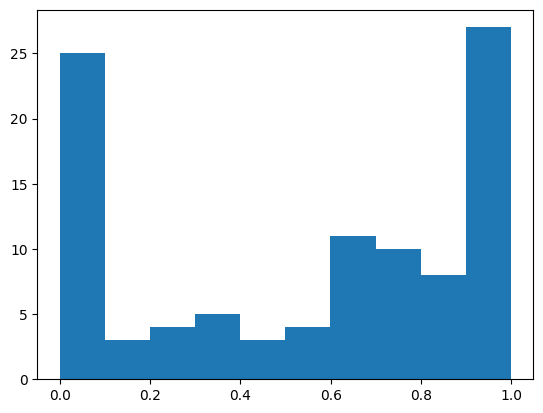

In [ ]:
plt.hist(EE)

In [ ]:
ct=run_quantum((10,0.5,0.0,1))

In [ ]:
ct

(0.49533099702668193, 0.08072210137152552)

In [ ]:
ct

(0.3796620018747443, 0.5668326833249968)

In [ ]:
run_quantum((12,0.5,0.0,0))

(0.3415532758171528, 0.5869314618074923)

In [ ]:
ct=run_quantum((12,0.5,0.0,0))

In [ ]:
ct

(0.46810194796277693, 0.5555716176088591)

In [ ]:
ct

(0.4681019479627768, 0.5555716176088593)

In [ ]:
ct=run_quantum((12,0.5,0.3,0))

In [ ]:
ct

(0.42218730423103235,
 [0.6001364942359211,
  0.7994308696649998,
  1.0318190232859812,
  0.9687606482207899,
  1.130049983640769,
  1.0272989796553442])

In [ ]:
ct

(0.4671499397040185, 0.5440313938731445)

In [12]:
run_quantum((16,0.5,0.5,0))

(0.3511116578961481, 1.0319706819286085, 0.1950265676690628)

In [175]:
%lprun -f CT_tensor.normalize ct=run_tensor((22,0.5,0.5,0))

Timer unit: 1e-09 s

Total time: 14.685 s
File: /tmp/ipykernel_3295823/997175121.py
Function: normalize at line 169

Line #      Hits         Time  Per Hit   % Time  Line Contents
   169                                               def normalize(self,vec):
   170                                                   # normalization after projection
   171       938 11778820844.0 12557378.3     80.2          norm=np.sqrt(torch.tensordot(vec.conj(),vec,dims=(list(range(self.L_T)),list(range(self.L_T)))))
   172                                                   # norm=np.sqrt(torch.sum(vec.conj()*vec))
   173                                           
   174       938   88428559.0  94273.5      0.6          assert norm != 0 , f'Cannot normalize: norm is zero {norm}'
   175       938 2817738631.0 3003985.7     19.2          return vec/norm

In [176]:
1. which is faster, matrix multiplication or index scrambling?
2. sparse vs dense
3. in place vs return a new
4. cpu vs gpu

SyntaxError: invalid syntax (2249880498.py, line 1)

In [173]:
%lprun -f CT_tensor.normalize ct=run_tensor((22,0.5,0.5,0))

Timer unit: 1e-09 s

Total time: 8.0237 s
File: /tmp/ipykernel_3295823/2812964600.py
Function: normalize at line 169

Line #      Hits         Time  Per Hit   % Time  Line Contents
   169                                               def normalize(self,vec):
   170                                                   # normalization after projection
   171                                                   # norm=np.sqrt(torch.tensordot(vec.conj(),vec,dims=(list(range(self.L_T)),list(range(self.L_T)))))
   172       938 6496914936.0 6926348.5     81.0          norm=np.sqrt(torch.sum(vec.conj()*vec))
   173                                           
   174       938   71934483.0  76689.2      0.9          assert norm != 0 , f'Cannot normalize: norm is zero {norm}'
   175       938 1454853809.0 1551016.9     18.1          return vec/norm

In [ ]:
ct=run_quantum((4,1,0.,4))

In [ ]:
ct.order_parameter()

1.0

In [ ]:
(ct.vec_history[-2].conj()*ct.vec_history[-2]).argmax()

10

In [ ]:
bin_pad(6,ct.L)

'0110'

In [ ]:
bin_pad(10,ct.L)

'1010'

In [ ]:
ct.order_parameter()

1.0

In [ ]:
ct.op_history[-5:]

['C1', 'C1', 'C1', 'C1', 'C1']

In [ ]:
ct.get_prob([ct.L-1],ct.vec_history[-1])

{(11, 0): 0.5237678599992799, (11, 1): 0.47623214000072045}

In [ ]:
def inner_prob(vec,pos,L):
    '''probability of `vec` of measuring 0 at L'''
    vec_tensor=vec.reshape((2,)*L)
    idx_list=np.arange(L)
    idx_list[[pos,0]]=idx_list[[0,pos]]
    vec_0=vec_tensor.transpose(idx_list).reshape((2,-1))[0]
    return vec_0.conj()@vec_0

In [ ]:
inner_prob(ct.vec_history[-1], ct.L-1, ct.L)

(0.5237678599992799+0j)

In [ ]:
cc=Counter(ct.op_history)

In [ ]:
cc

Counter({'C0': 23,
         'C1': 29,
         'chaotic': 48,
         'P110': 7,
         'P101': 7,
         'P111': 7,
         'I': 71,
         'P100': 4})

In [ ]:
sum([val for key,val in cc.items() if 'P' in key])

25

In [ ]:
cc['C0']+cc['C1']

52

In [ ]:
(cc['I'])

111

In [ ]:
sum([cc[x] for x in ['P71','P70','P61','P60']])/2/cc['chaotic']

0.23972602739726026

In [ ]:
cc['chaotic']

73

In [ ]:
from ipyparallel import Client
client = Client()

In [ ]:
dview = client[:]

In [ ]:
dview.execute('import numpy as np').wait()
dview.execute('from CT import *').wait()

True

In [ ]:
L_list=np.array([6,8,10,])
p_ctrl_list=np.linspace(0,1,11)
ensemble=100
inputs=[(L,p_ctrl,0,idx) for L in L_list for p_ctrl in p_ctrl_list for idx in range(ensemble)]

In [ ]:
results = dview.map_async(run_quantum, inputs)

In [ ]:
len(inputs)

12

In [ ]:
results.progress

6

In [ ]:
L_list=np.array([6,8,10,])
p_ctrl_list=np.linspace(0,0.8*0.99,11)
p_proj_list=np.linspace(0,0.1,5)
ensemble=1000
inputs=[(L,p_ctrl,p_proj,idx) for L in L_list for p_ctrl in p_ctrl_list for p_proj in p_proj_list for idx in range(ensemble)]

In [ ]:
np.array(list(results)).shape

(12, 2)

In [ ]:
rs=np.array(list(results)).reshape((L_list.shape[0],p_ctrl_list.shape[0],ensemble,2))

In [ ]:
O_map,EE_map=rs[:,:,:,0],rs[:,:,:,1]

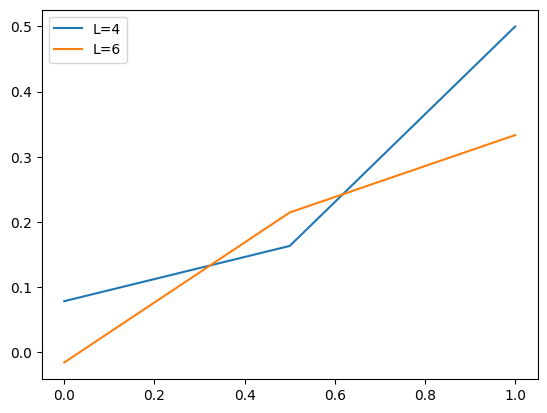

In [ ]:
fig,ax=plt.subplots()
for i in range(O_map.shape[0]):
    ax.plot(p_ctrl_list,O_map[i].mean(axis=-1),label=f'L={L_list[i]}')
ax.legend()

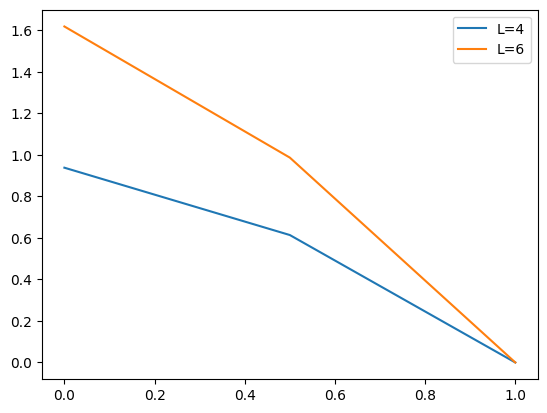

In [ ]:
fig,ax=plt.subplots()
for i in range(EE_map.shape[0]):
    ax.plot(p_ctrl_list,EE_map[i].mean(axis=-1),label=f'L={L_list[i]}')
ax.legend()

In [ ]:
rho=(np.tensordot(ct.vec.conj(),ct.vec,axes=0))

In [ ]:
cross ratio entropy

In [ ]:
ct=CT_quantum(L=6,x0=None,seed=100,history=True)
for _ in range(2*ct.L**2):
    ct.random_control(p_ctrl=0.3,p_proj=0.1)
    # ct.random_control(p_ctrl=0.5,p_proj=0.)

In [ ]:
ct.half_system_entanglement_entropy()

1.3016313795175396

In [ ]:
ct.order_parameter()

0.3366858476852739

In [ ]:
ct.von_Neumann_entropy([0,1,2])

1.2599853065106021

In [ ]:
ct.von_Neumann_entropy([1,2,3])

1.312984489034732

In [ ]:
ct.von_Neumann_entropy([2,3,4])

1.3319243430072847

In [ ]:
ct.von_Neumann_entropy([3,4,5])

1.259985306510601

In [ ]:
ct.von_Neumann_entropy([4,5,0])

1.3129844890347298

In [ ]:
ct.von_Neumann_entropy([5,0,1])

1.331924343007285

In [ ]:
dm=construct_density_matrix(ct.vec_history[-1])

In [ ]:
minus_rho_log_rho(dm)

1.1690277048712324e-14

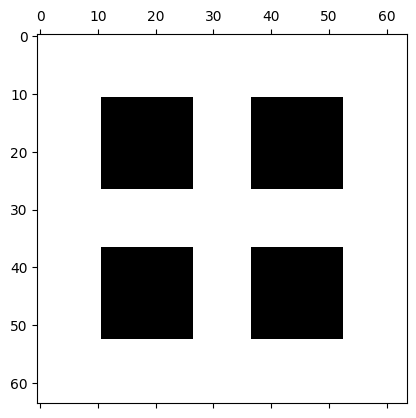

In [ ]:
plt.spy(dm)

In [ ]:
ct.op_history

In [ ]:
run_quantum((12,0.9,1))

1.0

In [ ]:
run_quantum((12,0.1,1))

-0.005221176507960079

In [ ]:
ct.order_parameter()

1.0

In [ ]:
ct.op_history

['C0',
 'C1',
 'C0',
 'C1',
 'C1',
 'chaotic',
 'chaotic',
 'chaotic',
 'C0',
 'chaotic']

In [ ]:
ct.order_parameter()

0.6000000000000002

In [ ]:
len([x for x in ct.op_history if x == 'chaotic'])/(2*ct.L**2)

0.09722222222222222

In [ ]:
[bin_pad(np.where(vec)[0][0],ct.L) for vec in ct.vec_history]

In [ ]:
bin_pad(np.where(ct.vec_history[-1])[0][0],ct.L)

'0101010101'

In [ ]:
ct.order_parameter()

0.600693549605928

In [ ]:
19/2**6

0.296875

In [ ]:
bin_pad(1,L=6)

'000001'

In [ ]:
z[[0,3]]=99

# Obsolete functions, for record only

In [ ]:



    # def von_Neumann_entropy(self,subregion,vec=None):
    #     '''`subregion` the spatial dof'''
    #     if vec is None:
    #         vec=self.vec_history[-1].copy()
    #     subregion=np.array(subregion)
    #     rho=construct_density_matrix(vec)
    #     rho_reduce=partial_trace(rho,self.L_T,subregion)
    #     return minus_rho_log_rho(rho_reduce)

    
# @lru_cache(maxsize=None)
# def T(L,left=True):
#     '''
#     circular right shift the computational basis `vec` : 
#     b_0 b_1 ... b_{L-1} -> right shift -> b_{L-1} b_0 ... b_{L-2}
#     b_0 b_1 ... b_{L-1} -> left shift ->  b_1 b_2... b_{L-2} b_{L-1}
#     Return: sparse matrix
#     '''
#     SWAP=sp.csr_array([[1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]],dtype=int)
#     I2=sp.eye(2,dtype=int)
#     op_list=[I2]*(L-1)
    
#     rs=sp.eye(2**L,dtype=int)
#     idx_list=np.arange(L-1)[::-1] if left else np.arange(L-1)
#     for i in idx_list:
#         op_list[i]=SWAP
#         rs=rs@kron_list(op_list)
#         op_list[i]=I2
#     return rs

def U(n,rng=None,size=1):
    '''Generate Haar random U(n)
    Return: dense matrix of Haar random U(4) `Q`'''
    if rng is None:
        rng=np.random.default_rng(None)
    # re=rng.normal(size=(n,n))
    # im=rng.normal(size=(n,n))
    # z=re+1j*im
    # Q,R=np.linalg.qr(z)
    # r_diag=np.diag(R)
    # Lambda=np.diag(r_diag/np.abs(r_diag))
    # Q=Q@Lambda
    # # R=Lambda.conj()@R
    # return Q
    return scipy.stats.unitary_group.rvs(n,random_state=rng,size=size)

def S(L,rng):
    '''construct quantum scrambler, Haar random U(4) applies to the last two digits only
    Return : sparse matrix'''
    # I2=sp.eye(2,dtype=int)
    # U_4=U(4,rng)
    # op_list=[I2]*(L-2)+[U_4]
    # return kron_list(op_list)

    I2=sp.eye(2**(L-2))
    # U_4=U(4,rng)
    U_4=scipy.stats.unitary_group.rvs(4,random_state=rng)

    return sp.kron(I2,U_4)


# @lru_cache(maxsize=None)
# def P(L,n,pos=None):
#     '''projection to n=0 or 1
#     Return : sparse matrix'''
#     if pos is None:
#         pos=L-1
#     PL=sp.diags([1-n,n])
#     I2=sp.eye(2,dtype=int)
#     op_list=[I2]*(L)
#     op_list[pos]=PL
#     return kron_list(op_list)

# @lru_cache(maxsize=None)
# def XL(L):
#     '''X_L for the last digits'''
#     sigma_x=sp.csr_matrix([[0,1],[1,0]],dtype=int)
#     I2=sp.eye(2,dtype=int).tocsr()
#     op_list=[I2]*(L-1)+[sigma_x]
#     return kron_list(op_list)


# @lru_cache(maxsize=None)
# def ZZ(L):
#     '''Z |0> = -|0>
#     Z |1> = |1>'''
#     sigma_Z= sp.csr_matrix([[-1,0],[0,1]],dtype=int)
#     I2=sp.eye(2,dtype=int)
#     op_list=[I2]*(L)
#     rs=0
#     for i in range(L):
#         # a little dumb here, swap can be used but anyway, profiling is a later step
#         # another simplied way is to note basis is the eigenvector of ZZ
#         op_list[i],op_list[(i+1)%L]=sigma_Z,sigma_Z
#         rs=rs+kron_list(op_list)
#         op_list[i],op_list[(i+1)%L]=I2,I2
#     return -rs/L

In [ ]:
# Obsolete, do not use
    # def adder_cpu(self):
    #     ''' This is not a full adder, which assume the leading digit in the input bitstring is zero (because of the T^{-1}R_L, the leading bit should always be zero).'''
    #     if self.xj==set([Fraction(1,3),Fraction(2,3)]):
    #         int_1_6=(int(Fraction(1,6)*2**self.L)|1)
    #         int_1_3=(int(Fraction(1,3)*2**self.L))
                
            
    #         old_idx=np.arange(2**(self.L-1)).reshape((2,-1))
    #         adder_idx=np.array([[int_1_6],[int_1_3]])
    #         new_idx=(old_idx+adder_idx)
    #         # handle the extra attractors, if 1..0x1, then 1..0(1-x)1, if 0..1x0, then 0..1(1-x)0 [shouldn't enter this branch..]
    #         mask_1=(new_idx&(1<<self.L-1) == (1<<self.L-1)) & (new_idx&(1<<2) == (0)) & (new_idx&(1) == (1))
    #         mask_2=(new_idx&(1<<self.L-1) == (0)) & (new_idx&(1<<2) == (1<<2)) & (new_idx&(1) == (0))

    #         new_idx[mask_1+mask_2]=new_idx[mask_1+mask_2]^(0b10)

    #         not_new_idx=np.ones(2**(self.L_T),dtype=bool,)
    #         not_new_idx[new_idx]=False


    #         return new_idx, old_idx, not_new_idx
    #     if self.xj==set([0]):
    #         return np.array([]), np.array([]), np.array([])

In [ ]:
# Obsolete version of protocol for measurement 
    # def random_control(self,p_ctrl,p_proj):
    #     '''
    #     p_ctrl: the control probability
    #     p_proj: the projection probability
    #     This is not the desired protocol, too strong measurement.
    #     '''
    #     vec=self.vec_history[-1].copy()

    #     p={}
    #     p[("L",0)]= vec.conj()@P(self.L,n=0,pos=self.L-1)@vec
    #     p[("L",1)] = vec.conj()@P(self.L,n=1,pos=self.L-1)@vec
    #     p[("L-1",0)] = vec.conj()@P(self.L,n=0,pos=self.L-2)@vec
    #     p[("L-1",1)] = vec.conj()@P(self.L,n=1,pos=self.L-2)@vec
        
    #     for key, val in p.items():
    #         assert np.abs(val.imag)<self._eps, f'probability for {key} is not real {val}'
    #         p[key]=val.real

    #     pool = ["C0","C1","PL0","PL1","PL-10","PL-11","chaotic"]
    #     probabilities = [p_ctrl * p[("L",0)], p_ctrl * p[("L",1)], p_proj * p[("L",0)], p_proj *  p[("L",1)], p_proj * p[("L-1",0)], p_proj * p[("L-1",1)], 1- p_ctrl-2*p_proj]

    #     op = self.rng.choice(pool,p=probabilities)

    #     op_list= {"C0":partial(self.control_map,bL=0),
    #               "C1":partial(self.control_map,bL=1),
    #               "PL0":partial(self.projection_map,pos=self.L-1,n=0),
    #               "PL1":partial(self.projection_map,pos=self.L-1,n=1),
    #               "PL-10":partial(self.projection_map,pos=self.L-2,n=0),
    #               "PL-11":partial(self.projection_map,pos=self.L-2,n=1),
    #               "chaotic":self.Bernoulli_map
    #               }

    #     vec=op_list[op](vec)
        
    #     if self.history:
    #         self.vec_history.append(vec)
    #         self.op_history.append(op)
    #     else:
    #         self.vec_history=[vec]
    #         self.op_history=[op]

In [ ]:
# Obsolete version that DOES NOT use tensor and index manipulation, instead most of them uses matrix multiplication
    def Bernoulli_map(self,vec):
        # vec=T(self.L,left=True)@vec
        vec=self.T_tensor(vec,left=True)
        # vec=S(self.L,rng=self.rng)@vec
        vec=self.S_tensor(vec,rng=self.rng_C)
        return vec
    def control_map(self,vec,bL):
            '''control map depends on the outcome of the measurement of bL'''
            # projection on the last bits
            # P_cached=P(self.L,bL)
            # vec=P_cached@vec
            vec=self.P_tensor(vec,bL)
            if bL==1:
                vec=self.XL_tensor(vec)
            if self.normalization:
                vec=self.normalize(vec)
            # right shift 
            # vec=T(self.L,left=False)@vec
            vec=self.T_tensor(vec,left=False)

            assert np.abs(vec[vec.shape[0]//2:]).sum() == 0, f'first qubit is not zero ({np.abs(vec[vec.shape[0]//2:]).sum()}) after right shift '

            # Adder
            if not self.ancilla:
                vec=self.adder()@vec
            else:
                vec=(self.adder()@vec.reshape((2**self.L,2))).flatten()
            
            return vec

def projection_map(self,vec,pos,n):
        '''projection to `pos` with outcome of `n`
        note that here is 0-index, and pos=L-1 is the last bit'''
        # vec=P(self.L,n=n,pos=pos)@vec
        vec=self.P_tensor(vec,n,pos)
        if self.normalization:
            vec=self.normalize(vec)

        # proj to any axis
        # U_2=U(2,self.rng)
        # # if not self.ancilla:
        # vec_tensor=vec.reshape((2,)*self.L_T)
        # idx_list=np.arange(self.L_T)
        # idx_list[pos],idx_list[0]=idx_list[0],idx_list[pos]
        # vec_tensor=vec_tensor.transpose(idx_list).reshape((2,2**(self.L_T-1)))
        # vec=(U_2@vec_tensor).reshape((2,)*self.L_T).transpose(idx_list).flatten()

        return vec
    def order_parameter(self,vec=None):
        if vec is None:
            vec=self.vec_history[-1].copy()
        # O=(vec.conj().T@ZZ(self.L)@vec).toarray()[0,0]
        # O=(vec.conj().T@ZZ(self.L)@vec)
        if self.xj== set([Fraction(1,3),Fraction(2,3)]):
            O=self.ZZ_tensor(vec)
        elif self.xj == set([0]):
            O=self.Z_tensor(vec)


        assert np.abs(O.imag)<self._eps, f'<O> is not real ({val}) '
        return O.real

    def get_prob(self,L_list,vec):
        '''get the probability of measuring 0 at site L_list'''
        # prob={(pos,n):(vec.conj().T@P(self.L,n=n,pos=pos)@vec).toarray()[0,0] for pos in L_list for n in [0,1]}
        prob={(pos,n):(vec.conj().T@P(self.L,n=n,pos=pos)@vec) for pos in L_list for n in [0,1]}
        for key, val in prob.items():
            assert np.abs(val.imag)<self._eps, f'probability for {key} is not real {val}'
            prob[key]=val.real
        return prob

    def normalize(self,vec):
        # normalization after projection
        # norm=np.sqrt(vec.conj().T@vec).toarray()[0,0]
        norm2=(vec.conj().T@vec).real
        self.update_history(None,None,norm2)
        # assert norm2 != 0 , f'Cannot normalize: norm is zero {norm2}'
        if norm2 > 0:
            return vec/np.sqrt(norm2)
        else:
            return vec

In [ ]:
## Simply create a GHZ state, (|0...0> + |1...1> )/sqrt(2)
            # vec=np.zeros((2**(self.L+1),),dtype=complex)
            # vec[0]=1/np.sqrt(2)
            # vec[-1]=1/np.sqrt(2)
            # # Randomize it 
            # for _ in range(self.L**2):
            #     vec=self.Bernoulli_map(vec)

In [ ]:
# def Haar_entangled_state(L,ensemble,rng=None):
#     # Haar random state with maximal entanglement
#     # (|s_1>|0>+|s_2>|1>)/sqrt(2)
#     if rng is None:
#         rng=np.random.default_rng(None)
#     state=rng.normal(size=(2**L,2,2,ensemble)) # wf, re/im, 0/1,ensemble
#     z=state[:,0,:,:]+1j*state[:,1,:,:] # wf, 0/1, ensemble
#     norm=np.sqrt((np.abs(z[:,0,:])**2).sum(axis=0)) # ensemble
#     z[:,0,:]=z[:,0,:]/norm
#     z[:,1,:]=z[:,1,:]-(z[:,0,:].conj()*z[:,1,:]).sum(axis=0)*z[:,0,:]
#     norm=np.sqrt((np.abs(z[:,1,:])**2).sum(axis=0))
#     z[:,1,:]=z[:,1,:]/norm
#     return z

In [ ]:
assert np.abs(vec[vec.shape[0]//2:]).sum() == 0, f'first qubit is not zero ({np.abs(vec[vec.shape[0]//2:]).sum()}) after right shift '

In [ ]:
    def random_control_2(self,p_ctrl,p_proj):
        """This is the same protocol as `random_control`, the only difference is the way to generate rng, and document operators.

        Parameters
        ----------
        p_ctrl : float, 0<=p_ctrl<=1
            probability of control
        p_proj : float, 0<=p_proj<=1
            probability of projection
        """
        vec=self.vec_history[-1].copy()
        
        p= self.get_prob_tensor([self.L-1],vec)

        pool = ["C0","C1","chaotic"]
        probabilities = [p_ctrl * p[(self.L-1,0)], p_ctrl * p[(self.L-1,1)],  1- p_ctrl]

        op = self.rng.choice(pool,p=probabilities)

        op_list= {"C0":partial(self.control_map,n=0),
                  "C1":partial(self.control_map,n=1),
                  f"P{self.L-1}0":partial(self.projection_map,pos=self.L-1,n=0),
                  f"P{self.L-1}1":partial(self.projection_map,pos=self.L-1,n=1),
                  f"P{self.L-2}0":partial(self.projection_map,pos=self.L-2,n=0),
                  f"P{self.L-2}1":partial(self.projection_map,pos=self.L-2,n=1),
                  "chaotic":self.Bernoulli_map,
                  "I":lambda x:x
                  }
        vec=op_list[op](vec)
        self.update_history(vec,op)

        if op=="chaotic":
            for pos in [self.L-1,self.L-2]:
                p_2=self.get_prob_tensor([pos], vec)
                pool_2=["I",f"P{pos}0",f"P{pos}1"]
                probabilities_2=[1-p_proj, p_proj * p_2[(pos,0)], p_proj *  p_2[(pos,1)],]
                op_2 = self.rng.choice(pool_2,p=probabilities_2)
                vec=op_list[op_2](vec)
                self.update_history(vec,op_2)

In [ ]:

    def get_prob(self,L_list,vec):
        '''get the probability of measuring 0 at site L_list'''
        prob={(pos,n):(vec.conj().T@P(self.L,n=n,pos=pos)@vec) for pos in L_list for n in [0,1]}
        for key, val in prob.items():
            assert np.abs(val.imag)<self._eps, f'probability for {key} is not real {val}'
            prob[key]=val.real
        return prob

In [ ]:
    def get_prob_tensor(self,L_list,vec):
        prob={(pos,0):self.inner_prob(vec,pos) for pos in L_list}
        prob.update({(pos,1):1-prob[(pos,0)] for pos in L_list})
        return prob

In [ ]:

    
def construct_density_matrix(vec):
    return np.tensordot(vec.conj(),vec,axes=0)
    
def partial_trace( rho, L, subregion):
    '''for a density matrix rho, of a system size L, (dim: 2**L), trace out the dof in `subregion`'''
    assert L<=16, f'L ({L}) cannot be longer than 16 because np.ndarray is restricted to 32 rank'
    rho_tensor=rho.reshape((2,)*(2*L))
    idx_list=np.arange(2*L)
    idx_list[subregion+L]=idx_list[subregion]
    mask=np.ones(2*L,dtype=bool)
    mask[subregion]=False
    mask[subregion+L]=False
    out_idx_list=idx_list[mask]
    rho_reduce=np.einsum(rho_tensor,idx_list,out_idx_list).reshape((2**(L-subregion.shape[0]),2**(L-subregion.shape[0])))
    return rho_reduce

def minus_rho_log_rho(rho):
    vals=np.linalg.eigvalsh(rho)
    vals_positive=vals[vals>0]
    return np.sum(-np.log(vals_positive)*vals_positive)

In [ ]:
def S(L,rng):
    '''construct quantum scrambler, Haar random U(4) applies to the last two digits only
    Return : sparse matrix'''

    I2=sp.eye(2**(L-2))
    U_4=scipy.stats.unitary_group.rvs(4,random_state=rng)
    return sp.kron(I2,U_4)

In [ ]:
kron_list=lambda x: reduce(sp.kron,x)


In [ ]:
self.tensor_true,self.tensor_false=torch.tensor(True,device=self.device), torch.tensor(False,device=self.device) # this is a workaround for generate_binary, because loop over tensor returns a tensor with a single value

In [ ]:
 # Simply create a GHZ state, (|0...0> + |1...1> )/sqrt(2)
            # vec=torch.zeros((2,)*(self.L_T)+(len(self.x0),),dtype=self.dtype['torch'],device=self.device)
            # vec[(0,)*self.L_T]=1/np.sqrt(2)
            # vec[(1,)*self.L_T]=1/np.sqrt(2)

            # # Randomize it 
            # if self.ensemble is None:
            #     for _ in range(self.L**2):
            #         vec=self.Bernoulli_map(vec,self.rng)
            # else:
            #     for _ in range(self.L**2):
            #         vec=self.Bernoulli_map(vec,len(self.x0))

In [ ]:
    # def _initialize_x0(self,x0):
    #     if self.ensemble is None:
    #         return [rng.random() if x is None else x for rng,x in zip(self.rng,([x0]*len(self.rng)) if x0 is None else x0)]
    #     else:
    #         if x0 is None:
    #             return torch.randint(0,2**self.L,(self.ensemble,),device=self.device)
    #         else:
    #             return x0

In [ ]:

    # def _check_mode(self,seed,seed_vec,seed_C):
    #     # First mode
    #     if isinstance(seed, list) and (seed_vec is None) and (seed_C is None) and (self.ensemble is None) and (self.ensemble_m is None):
    #         print('First mode')
    #         return 1
    #     # Second mode, ensemble = , ensemble_m =1 
    #     if isinstance(seed, int) and (seed_vec is None) and (seed_C is None) and (self.ensemble is int) and (self.ensemble_m == 1):
    #         print('Second mode')
    #         return 2
    #     # Third mode
    #     if isinstance(seed, int) and isinstance(seed_vec, int) and isinstance(seed_C, int) and (self.ensemble is int) and (self.ensemble_m is int):
    #         print('Third mode')
    #         return 3
    #     raise ValueError('Incompatible mode')

In [ ]:
        # return {"C0":partial(self.control_map,n=0),
        #         "C1":partial(self.control_map,n=1),
        #         f"P{self.L-1}0":partial(self.projection_map,pos=self.L-1,n=0),
        #         f"P{self.L-1}1":partial(self.projection_map,pos=self.L-1,n=1),
        #         f"P{self.L-2}0":partial(self.projection_map,pos=self.L-2,n=0),
        #         f"P{self.L-2}1":partial(self.projection_map,pos=self.L-2,n=1),
        #         "chaotic":self.Bernoulli_map,
        #         "I":lambda x:x
        #         }

In [ ]:
 # U_4=U(4,size=rng).astype(self.dtype['numpy'])
            # U_4=torch.tensor(U_4,device=self.device).view((rng,2,2,2,2))


In [ ]:


        
        # if not self.ancilla:
        #     if self.ensemble is None:
        #         vec=torch.from_numpy(np.array([Haar_state(self.L, ensemble=1,rng=rng,k=1).astype(self.dtype['numpy']).reshape((2,)*(self.L)) for rng in self.rng_vec])).permute(list(range(1,self.L+1))+[0]).unsqueeze(-1)
        #         if self.gpu:
        #             vec=vec.cuda()
        #     else:
        #         # if self.ensemble_m==1: # means each circuit is distinctive
        #         #     vec=self.Haar_state(k=1,ensemble=self.ensemble,rng=self.rng_vec)[...,0,:].view((2,)*(self.L_T)+(self.ensemble,1))
        #         # else: # for batch circuit, namely `ensemble` circuit and each circuit has `ensemble_m` outcomes
        #         #     # Make all circuit start same , I don't think this is correct, if the encoding stage is considered part of the circuit
        #         #     # vec=self.Haar_state(k=1,ensemble=1,rng=self.rng_vec)[...,0,:].unsqueeze(-1).repeat(*(1,)*self.L_T+(self.ensemble,self.ensemble_m,))
        #         #     # Make all circuit start differently , within ensemble_m, they are the same
        #         #     vec=self.Haar_state(k=1,ensemble=self.ensemble,rng=self.rng_vec)[...,0,:].unsqueeze(-1).repeat(*(1,)*self.L_T+(1,self.ensemble_m,))

        #         # This is a unified way --- make each circuit distintive initial state.
        #         vec=self.Haar_state(k=1,ensemble=self.ensemble,rng=self.rng_vec).unsqueeze(-1).repeat(*(1,)*self.L_T+(1,self.ensemble_m,))
        # else:
        #     if self.ensemble is None:
        #         vec=np.sqrt(0.5)*torch.from_numpy(np.array([Haar_state(self.L,ensemble=1,rng=rng,k=2).astype(self.dtype['numpy']).reshape((2,)*(self.L_T)) for rng in self.rng_vec])).permute(list(range(1,self.L_T+1))+[0]).unsqueeze(-1)
        #         if self.gpu:
        #             vec=vec.cuda()
        #     else:
        #         # if self.ensemble_m==1:
        #         #     vec=torch.sqrt(torch.tensor(0.5,device=self.device,dtype=self.dtype['torch']))*self.Haar_state(k=2,ensemble=self.ensemble,rng=self.rng_vec).view((2,)*(self.L_T)+(self.ensemble,1))
        #         # else:
        #         #     # Make all circuit start same , I don't think this is correct, if the encoding stage is considered part of the circuit
        #         #     # vec=torch.sqrt(torch.tensor(0.5,device=self.device,dtype=self.dtype['torch']))*self.Haar_state(k=2,ensemble=1,rng=self.rng_vec).unsqueeze(-1).repeat(*(1,)*self.L_T+(self.ensemble,self.ensemble_m,))
        #         #     # Make all circuit start differently , within ensemble_m, they are the same
        #         #     vec=torch.sqrt(torch.tensor(0.5,device=self.device,dtype=self.dtype['torch']))*self.Haar_state(k=2,ensemble=self.ensemble,rng=self.rng_vec).unsqueeze(-1).repeat(*(1,)*self.L_T+(1,self.ensemble_m,))
        #         vec=torch.sqrt(torch.tensor(0.5,device=self.device,dtype=self.dtype['torch']))*self.Haar_state(k=2,ensemble=self.ensemble,rng=self.rng_vec).unsqueeze(-1).repeat(*(1,)*self.L_T+(1,self.ensemble_m,))

In [ ]:





        if self.history:
            if vec is not None:
                self.vec_history.append(vec.cpu().clone())
            if ctrl_idx_dict is not None and ctrl_0_idx_dict is not None and proj_idx_dict is not None and proj_0_idx_dict is not None:
                op_map=np.empty((self.rng.shape[0] if self.ensemble is None else self.ensemble,),dtype='<U20')
                op_map[ctrl_0_idx_dict[True]]='C0'
                op_map[ctrl_0_idx_dict[False]]='C1'
                op_map[ctrl_idx_dict[False]]='chaotic'

                for pos,idx_dict in proj_0_idx_dict.items():
                    if len(idx_dict[True])>0:
                        op_map[idx_dict[True]]=np.char.add(op_map[idx_dict[True]],f'_P{pos}0')
                    if len(idx_dict[False])>0:
                        op_map[idx_dict[False]]=np.char.add(op_map[idx_dict[False]],f'_P{pos}1')

                self.op_history.append(op_map)

In [ ]:

    # def P_tensor(self,vec,n,pos=None):
    #     """Directly set zero at tensor[...,0] =0 for n==1 and tensor[...,1] =0 for n==0

    #     Parameters
    #     ----------
    #     vec : numpy.array, shape=(2**L_T,) or (2,)*L_T
    #         state vector
    #     n : int, {0,1}
    #         outcome of projection
    #     pos : int, optional
    #         position of projection, if None, apply to the last qubit excluding ancilla qubit, by default None

    #     Returns
    #     -------
    #     numpy.array, shape=(2,)*L_T
    #         state vector after projection
    #     """
    #     if vec.ndim!=self.L_T:
    #         vec=vec.reshape((2,)*self.L_T)
    #     if isinstance(n,list):
    #         n=n[0]
    #     if isinstance(pos,list):
    #         pos=pos[0]

    #     if pos is None or pos==self.L-1:
    #         # project the last site
    #         if not self.ancilla:
    #             vec[...,1-n]=0
    #         else:
    #             vec[...,1-n,:]=0
    #     if pos == self.L-2:
    #         if not self.ancilla:
    #             vec[...,1-n,:]=0
    #         else:
    #             vec[...,1-n,:,:]=0
    #     return vec


In [ ]:

def add_binary(vec1,vec2):
    ''' adder for two `vec1` and `vec2`
    both are np.array
    return vec1
    '''
    assert vec1.shape[0]==vec2.shape[0], f'len of {vec1.shape[0]} is not same as len of {vec2.shape[0]}'
    vec_bin1=int(''.join(map(str,vec1)),2)
    vec_bin2=int(''.join(map(str,vec2)),2)
    vec_bin1=vec_bin1+vec_bin2
    vec1_sum=bin(vec_bin1)[2:]
    vec1_sum=vec1_sum.rjust(vec1.shape[0],'0')
    
    vec1_sum=list(map(int,list(vec1_sum)))
    if len(vec1_sum)>(vec1.shape[0]):
        vec1_sum = np.array(vec1_sum[1:]) #drop carry
    else:
        vec1_sum = np.array(vec1_sum)

    if np.array_equal(vec1_sum[[0,-3,-1]],np.array([1,0,1])) or np.array_equal(vec1_sum[[0,-3,-1]],np.array([0,1,0])):
        vec1_sum[-2]=1-vec1_sum[-2]

    return (vec1_sum)